<a href="https://colab.research.google.com/github/Mhkkks/ASR-Bias-Computational-Analysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Before running my code, make sure u place the Analysis folder to your Google Drive under My Drive

csv_filename = '/content/drive/My Drive/Analysis/combined_audio_mapping.csv'

## Mounting Drive and Reading CSV

In [ ]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Mount Drive and Define Paths ---
drive.mount('/content/drive', force_remount=True)

# Define the input filename
csv_filename = '/content/drive/My Drive/Analysis/combined_audio_mapping.csv'

print("--- Colab Data Loader ---")
print(f"Loading input file: {csv_filename}")

# --- 2. Load the *input* CSV ---
try:
    df = pd.read_csv(csv_filename)
    print("Successfully loaded file into 'df'.")
    print(f"Total rows: {len(df)}")
except FileNotFoundError:
    print(f"Error: File not found at '{csv_filename}'.")
    print("Please make sure Google Drive is mounted and the file exists at that exact path.")
    raise
except Exception as e:
    print(f"Error reading CSV file '{csv_filename}': {e}")
    raise

print("\nFile loaded successfully. Here are the columns:")
print("--------------------")
for col in df.columns:
    print(f"- {col}")
print("--------------------")

print("\n--- Script Finished. 'df' is ready for the next cell. ---")


Mounted at /content/drive
--- Colab Data Loader ---
Loading input file: /content/drive/My Drive/Analysis/combined_audio_mapping.csv
Successfully loaded file into 'df'.
Total rows: 846

File loaded successfully. Here are the columns:
--------------------
- name
- file
- transcript
- text_length
- age
- gender
- race
- language
- wps
- readability
- f0mean
- YT_WER
- FB_WER
- MS_WER
- GM_WER
- WX_WER
- ZM_WER
- BJ_WER
- GM
- YT
- MS
- FB
- ZM
- BJ
- WX
- audio_filepath
--------------------

--- Script Finished. 'df' is ready for the next cell. ---


## Sentiment score and label

In [ ]:
# Install dependencies
!pip install transformers torch tqdm

import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import os
from transformers import pipeline, AutoTokenizer

# --- Define Input/Output Paths ---
# Input file (already loaded in previous block)
input_csv = '/content/drive/My Drive/Analysis/combined_audio_mapping.csv'

# Final output file with WPS (this is what we're checking for)
final_output_path = "/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_wps.csv"

# Intermediate file (sentiment only - will be deleted in Block 3)
save_path = "/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment.csv"

# --- Define column names based on your attributes ---
reference_col = "transcript"  # Reference transcription column
platforms = ['YT', 'FB', 'MS', 'GM', 'WX', 'ZM', 'BJ']  # Platform columns

# --- Helper: convert continuous score to categorical label ---
def to_label(score):
    """Convert sentiment score to categorical label"""
    if score > 0.2:
        return "positive"
    elif score < -0.2:
        return "negative"
    else:
        return "neutral"

# ============================================================================
# CHECK IF FINAL FILE (WITH WPS) ALREADY EXISTS
# ============================================================================
print("=" * 70)
print("BLOCK 2: SENTIMENT ANALYSIS")
print("=" * 70)

if os.path.exists(final_output_path):
    print(f"\n✓ FINAL FILE WITH WPS ALREADY EXISTS!")
    print(f"  File: {final_output_path}")
    print(f"\n✓ Loading pre-calculated sentiment + WPS data...")
    try:
        df = pd.read_csv(final_output_path)
        print(f"✓ Data loaded successfully!")
        print(f"  Total rows: {len(df)}")
        print(f"  Total columns: {len(df.columns)}")

        # Show what columns are available
        print(f"\n--- Available Columns ---")
        print(f"Sentiment columns: ref_sentiment, label")
        sentiment_cols = [col for col in df.columns if 'sentiment' in col or 'label' in col or 'wps' in col]
        print(f"Other relevant columns: {', '.join(sentiment_cols)}")

        print("\n--- Sentiment Distribution for Reference Column ---")
        if 'label' in df.columns:
            print(df['label'].value_counts())

        print("\n✓ Block 2 Complete - WPS file already processed!")
        print("=" * 70)
    except Exception as e:
        print(f"✗ Error loading final file: {e}")
        raise

else:
    # ========================================================================
    # FINAL FILE DOESN'T EXIST - RUN SENTIMENT ANALYSIS
    # ========================================================================
    print(f"\n✗ Final WPS file not found.")
    print(f"  Expected: {final_output_path}")
    print(f"\n✓ Starting sentiment analysis workflow...")

    # Check if intermediate sentiment file exists
    if os.path.exists(save_path):
        print(f"\n✓ Found intermediate sentiment file at: {save_path}")
        print(f"  Loading it...")
        try:
            df = pd.read_csv(save_path)
            print(f"✓ Loaded pre-calculated sentiment data.")
            print(f"  Total rows: {len(df)}")
        except Exception as e:
            print(f"✗ Error loading file: {e}")
            raise
    else:
        print(f"\n✗ Intermediate file not found. Loading original data...")

        # Verify df exists (from Block 1)
        if 'df' not in globals():
            print("✗ Error: DataFrame 'df' not found. Please run Block 1 first.")
            raise NameError("DataFrame 'df' not loaded. Run the data loader block first.")

        print(f"✓ Working with {len(df)} rows from Block 1")

        print("\n" + "-" * 70)
        print("--- Initializing Hugging Face Pipeline and Tokenizer ---")
        print("-" * 70)

        device = 0 if torch.cuda.is_available() else -1
        device_name = "GPU" if device == 0 else "CPU"
        print(f"Using device: {device_name}")

        model_name = "distilbert-base-uncased-finetuned-sst-2-english"
        print(f"Loading model: {model_name}")

        sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=device)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        MODEL_MAX_LENGTH = 512
        print("✓ Model and tokenizer loaded successfully")

        # --- Helper to convert HF pipeline result to signed score ---
        def process_hf_result(result):
            """Convert HuggingFace result to signed sentiment score"""
            if result['label'] == 'POSITIVE':
                return result['score']
            else:
                return -result['score']

        # --- Helper function: chunked sentiment for long texts ---
        def get_sentiment_for_long_text(text):
            """
            Process sentiment for texts of any length using chunking strategy
            """
            text = str(text)
            if not text.strip():
                return 0.0  # Return 0.0 for empty strings

            # Use tokenizer to get token count
            try:
                inputs = tokenizer(text, return_tensors=None, add_special_tokens=False)
                num_tokens = len(inputs['input_ids'])
            except Exception:
                # Handle potential tokenizer failures on weird inputs
                return 0.0

            # If text is short enough, process directly
            if num_tokens <= MODEL_MAX_LENGTH - 2:
                try:
                    result = sentiment_pipeline(text, truncation=True)[0]
                    return process_hf_result(result)
                except Exception:
                    return 0.0  # Handle pipeline failure

            # If text is long, process in chunks
            scores = []
            stride = 50  # Overlap between chunks
            input_ids = inputs['input_ids']
            chunk_size = MODEL_MAX_LENGTH - 2

            for i in range(0, num_tokens, chunk_size - stride):
                chunk_ids = input_ids[i:i+chunk_size]
                chunk_text = tokenizer.decode(chunk_ids)
                if not chunk_text.strip():
                    continue
                try:
                    result = sentiment_pipeline(chunk_text, truncation=True)[0]
                    scores.append(process_hf_result(result))
                except Exception:
                    continue  # Skip chunk if it fails

            if not scores:
                return 0.0
            return np.mean(scores)

        # --- 1) Process Reference Column (transcript) ---
        print(f"\n=== Processing Reference Column: '{reference_col}' ===")
        if reference_col not in df.columns:
            print(f"✗ Error: Reference column '{reference_col}' not found in DataFrame!")
            print(f"Available columns: {df.columns.tolist()}")
            raise KeyError(f"Column '{reference_col}' not found")

        ref_texts = df[reference_col].fillna("").astype(str).tolist()
        ref_results = []
        for text in tqdm(ref_texts, desc="Reference texts"):
            ref_results.append(get_sentiment_for_long_text(text))

        df['ref_sentiment'] = ref_results
        df['label'] = df['ref_sentiment'].apply(to_label)
        print(f"✓ Completed sentiment analysis for reference column")

        # --- 2) Process Platform Columns ---
        print(f"\n=== Processing Platform Columns ===")
        processed_platforms = []
        skipped_platforms = []

        for p in platforms:
            if p not in df.columns:
                print(f"⚠ Skipping platform '{p}': column not found in DataFrame.")
                skipped_platforms.append(p)
                continue

            sentiment_col = f"{p}_sentiment"
            label_col = f"{p}_label"
            print(f"\nProcessing platform: '{p}'")

            platform_texts = df[p].fillna("").astype(str).tolist()
            platform_results = []
            for text in tqdm(platform_texts, desc=f"{p} texts"):
                platform_results.append(get_sentiment_for_long_text(text))

            df[sentiment_col] = platform_results
            df[label_col] = df[sentiment_col].apply(to_label)
            processed_platforms.append(p)
            print(f"✓ Completed sentiment analysis for '{p}'")

        # --- Summary ---
        print("\n" + "=" * 60)
        print("SENTIMENT ANALYSIS SUMMARY")
        print("=" * 60)
        print(f"✓ Processed reference column: {reference_col}")
        print(f"✓ Processed platforms: {', '.join(processed_platforms)}")
        if skipped_platforms:
            print(f"⚠ Skipped platforms (not found): {', '.join(skipped_platforms)}")

        # --- 3) Save DataFrame ---
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_csv(save_path, index=False)
        print(f"\n✓ Sentiment scores + labels saved to: {save_path}")

    # ========================================================================
    # REMINDER: Run Block 3 to add WPS categories and finalize
    # ========================================================================
    print("\n" + "=" * 70)
    print("⚠ IMPORTANT: NEXT STEPS")
    print("=" * 70)
    print("\nYou have completed Block 2 (Sentiment Analysis).")
    print("You MUST run Block 3 to:")
    print("  1. Add WPS speed categories (Slow/Medium/Fast)")
    print("  2. Create final output file with WPS")
    print("  3. Delete this intermediate file")
    print(f"\nBlock 3 will create: {final_output_path}")
    print("=" * 70)

# --- Preview Results ---
print("\n" + "=" * 60)
print("PREVIEW OF RESULTS")
print("=" * 60)

# Display columns related to sentiment
sentiment_cols = ['ref_sentiment', 'label'] + [f"{p}_sentiment" for p in platforms if f"{p}_sentiment" in df.columns] + [f"{p}_label" for p in platforms if f"{p}_label" in df.columns]
available_sentiment_cols = [col for col in sentiment_cols if col in df.columns]

print(f"\nShowing first 5 rows with selected columns:")
display_cols = [reference_col] + available_sentiment_cols[:5]  # Show first few to avoid crowding
print(df[display_cols].head())

print("\n--- Sentiment Distribution for Reference Column ---")
if 'label' in df.columns:
    print(df['label'].value_counts())

print("\n✓ Block 2 Complete")
print("=" * 70)


BLOCK 2: SENTIMENT ANALYSIS

✓ FINAL FILE WITH WPS ALREADY EXISTS!
  File: /content/drive/My Drive/Analysis/labels_sentiment_with_wps.csv

✓ Loading pre-calculated sentiment + WPS data...
✓ Data loaded successfully!
  Total rows: 846
  Total columns: 43

--- Available Columns ---
Sentiment columns: ref_sentiment, label
Other relevant columns: wps, ref_sentiment, label, YT_sentiment, YT_label, FB_sentiment, FB_label, MS_sentiment, MS_label, GM_sentiment, GM_label, WX_sentiment, WX_label, ZM_sentiment, ZM_label, BJ_sentiment, BJ_label, wps_category

--- Sentiment Distribution for Reference Column ---
label
negative    566
neutral     161
positive    119
Name: count, dtype: int64

✓ Block 2 Complete - WPS file already processed!

PREVIEW OF RESULTS

Showing first 5 rows with selected columns:
                                          transcript  ref_sentiment     label  \
0  i m here today to show my photographs of the l...      -0.974569  negative   
1  i was in new york during hurricane

In [ ]:
# Block 3: Create WPS Speed Category Labels (Quantile Based) + Cleanup
import pandas as pd
import os

print("=" * 70)
print("BLOCK 3: WPS SPEED CATEGORIZATION (QUANTILES - FORCE UPDATE)")
print("=" * 70)

# --- Define file paths ---
intermediate_path = "/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment.csv"
output_path = "/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_wps.csv"

# --- Define the 4 Quantile Labels ---
# 4 buckets of equal size (25% each)
new_labels = ["Slow", "Moderate", "Fast", "Very Fast"]

# ========================================================================
# 1. LOAD DATA (Handle both existing Final file and Intermediate file)
# ========================================================================
df = None
source_type = None

if os.path.exists(output_path):
    print(f"✓ Found existing FINAL file: {output_path}")
    print(f"  Status: Loading to UPDATE/REPLACE categories with new 4-Quantile method...")
    df = pd.read_csv(output_path)
    source_type = "final"
elif os.path.exists(intermediate_path):
    print(f"✓ Final file not found. Loading INTERMEDIATE file: {intermediate_path}")
    df = pd.read_csv(intermediate_path)
    source_type = "intermediate"
else:
    print(f"✗ Error: Neither '{output_path}' nor '{intermediate_path}' found.")
    raise FileNotFoundError("No input data found to process.")

print(f"✓ Data loaded. Rows: {len(df)}")

# ========================================================================
# 2. CALCULATE 4 QUANTILES (ALWAYS RUNS)
# ========================================================================
wps_col = 'wps'

# Ensure WPS is numeric
if wps_col not in df.columns:
    raise KeyError(f"Column '{wps_col}' not found in the loaded file.")

df[wps_col] = pd.to_numeric(df[wps_col], errors='coerce')

print(f"\n--- Applying 4-Quantile Logic (qcut) ---")
print("Criterion: Splitting data into 4 equal-sized buckets (0-25%, 25-50%, 50-75%, 75-100%)")

try:
    # Use qcut to split into 4 buckets with the new labels
    df['wps_category'] = pd.qcut(
        df[wps_col],
        q=4,
        labels=new_labels
    )
    print(f"✓ Successfully replaced/created 'wps_category' with labels: {new_labels}")

except ValueError:
    # Fallback if there are too many duplicate values (e.g., too many 0s) preventing unique bins
    print(f"⚠ Warning: Non-unique bin edges detected. Using rank method to force buckets.")
    df['wps_category'] = pd.qcut(
        df[wps_col].rank(method='first'),
        q=4,
        labels=new_labels
    )

# ========================================================================
# 3. SHOW STATISTICS & PREVIEW
# ========================================================================
print(f"\n--- New WPS Speed Distribution ---")
wps_dist = df['wps_category'].value_counts().sort_index()

for category in new_labels:
    if category in wps_dist.index:
        count = wps_dist[category]
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count:>5} rows ({percentage:>5.1f}%)")
    else:
        print(f"  {category}: {0:>5} rows ({0:>5.1f}%)")

print(f"\n--- Preview (First 5 Rows) ---")
print(df[['wps', 'wps_category']].head(5).to_string())

# ========================================================================
# 4. SAVE & CLEANUP
# ========================================================================
print(f"\n--- Saving Updated Data ---")
df.to_csv(output_path, index=False)
print(f"✓ Saved to: {output_path}")

# Only delete the intermediate file if we started from it
if source_type == "intermediate" and os.path.exists(intermediate_path):
    print(f"\n--- Cleaning Up ---")
    try:
        os.remove(intermediate_path)
        print(f"✓ Deleted intermediate file: {intermediate_path}")
    except Exception as e:
        print(f"⚠ Could not delete intermediate file: {e}")

print("\n" + "=" * 70)
print("✓ BLOCK 3 COMPLETE: WPS LABELS UPDATED")
print("=" * 70)

BLOCK 3: WPS SPEED CATEGORIZATION (QUANTILES - FORCE UPDATE)
✓ Found existing FINAL file: /content/drive/My Drive/Analysis/labels_sentiment_with_wps.csv
  Status: Loading to UPDATE/REPLACE categories with new 4-Quantile method...
✓ Data loaded. Rows: 846

--- Applying 4-Quantile Logic (qcut) ---
Criterion: Splitting data into 4 equal-sized buckets (0-25%, 25-50%, 50-75%, 75-100%)
✓ Successfully replaced/created 'wps_category' with labels: ['Slow', 'Moderate', 'Fast', 'Very Fast']

--- New WPS Speed Distribution ---
  Slow:   212 rows ( 25.1%)
  Moderate:   214 rows ( 25.3%)
  Fast:   209 rows ( 24.7%)
  Very Fast:   211 rows ( 24.9%)

--- Preview (First 5 Rows) ---
     wps wps_category
0  2.380     Moderate
1  2.753         Fast
2  2.737         Fast
3  2.767         Fast
4  2.133         Slow

--- Saving Updated Data ---
✓ Saved to: /content/drive/My Drive/Analysis/labels_sentiment_with_wps.csv

✓ BLOCK 3 COMPLETE: WPS LABELS UPDATED


In [ ]:
print(df.columns.tolist())

['name', 'file', 'transcript', 'text_length', 'age', 'gender', 'race', 'language', 'wps', 'readability', 'f0mean', 'YT_WER', 'FB_WER', 'MS_WER', 'GM_WER', 'WX_WER', 'ZM_WER', 'BJ_WER', 'GM', 'YT', 'MS', 'FB', 'ZM', 'BJ', 'WX', 'audio_filepath', 'ref_sentiment', 'label', 'YT_sentiment', 'YT_label', 'FB_sentiment', 'FB_label', 'MS_sentiment', 'MS_label', 'GM_sentiment', 'GM_label', 'WX_sentiment', 'WX_label', 'ZM_sentiment', 'ZM_label', 'BJ_sentiment', 'BJ_label', 'wps_category']


# Analysis 1: The Relationship Between WER and Sentiment

## Finding A: Higher WER Strongly Correlates with Sentiment Shifts

--- Full Part A Analysis (Combined Visualization with Custom Colors) ---
Mounted at /content/drive
Plots will be saved to: plots_partA/

STEP 1: Loading/Creating Shift Data

✓ Found existing file at: /content/drive/My Drive/Analysis/labels_sentiment_with_shifts.csv
Loading it and skipping shift calculations.
✓ Loaded successfully. Rows: 846, Columns: 50

✓ Step 1 Complete. 'df' is loaded with shift data.

STEP 2: Auto-detecting WER columns

✓ Auto-detected WER columns: YT_WER, FB_WER, MS_WER, GM_WER, WX_WER, ZM_WER, BJ_WER
✓ Auto-detected platforms: BJ, FB, GM, MS, WX, YT, ZM

=== Step 2: Running Part A Analysis (Combined Plots) ===

✓ Created 'ref_sentiment_abs' column

--- Part 2.1: Creating Combined Correlation Plots ---


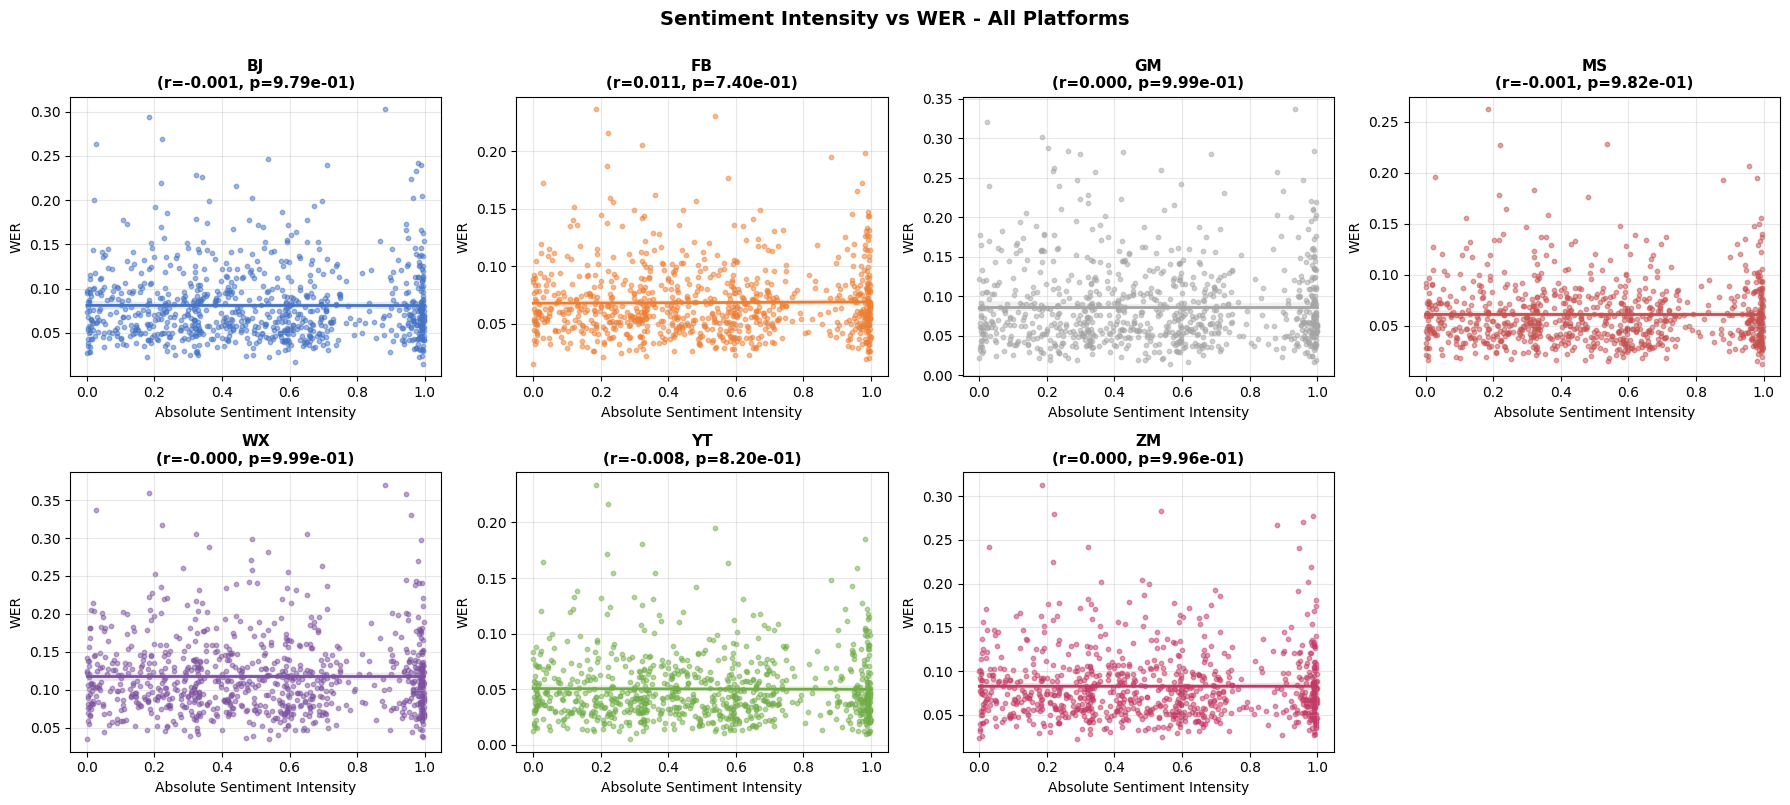

✓ Saved: plots_partA/01_combined_correlation_intensity_vs_wer.pdf
✓ Correlation table saved

--- Part 2.2: Creating Combined WER Range → Shift Rate (Single Grouped Bar Chart) ---

✓ Shift Rate for BJ:
   wer_bin  Shift_Rate_Percent Platform
  [0, 0.1)           14.528594       BJ
[0.1, 0.2)           20.329670       BJ
[0.2, 0.3)           25.000000       BJ
[0.3, 1.0]            0.000000       BJ

✓ Shift Rate for FB:
   wer_bin  Shift_Rate_Percent Platform
  [0, 0.1)           14.577657       FB
[0.1, 0.2)           20.370370       FB
[0.2, 0.3)            0.000000       FB

✓ Shift Rate for GM:
   wer_bin  Shift_Rate_Percent Platform
  [0, 0.1)           15.177066       GM
[0.1, 0.2)           15.277778       GM
[0.2, 0.3)           20.588235       GM
[0.3, 1.0]           33.333333       GM

✓ Shift Rate for MS:
   wer_bin  Shift_Rate_Percent Platform
  [0, 0.1)           12.109375       MS
[0.1, 0.2)           16.216216       MS
[0.2, 0.3)            0.000000       MS

✓ Shift Rate

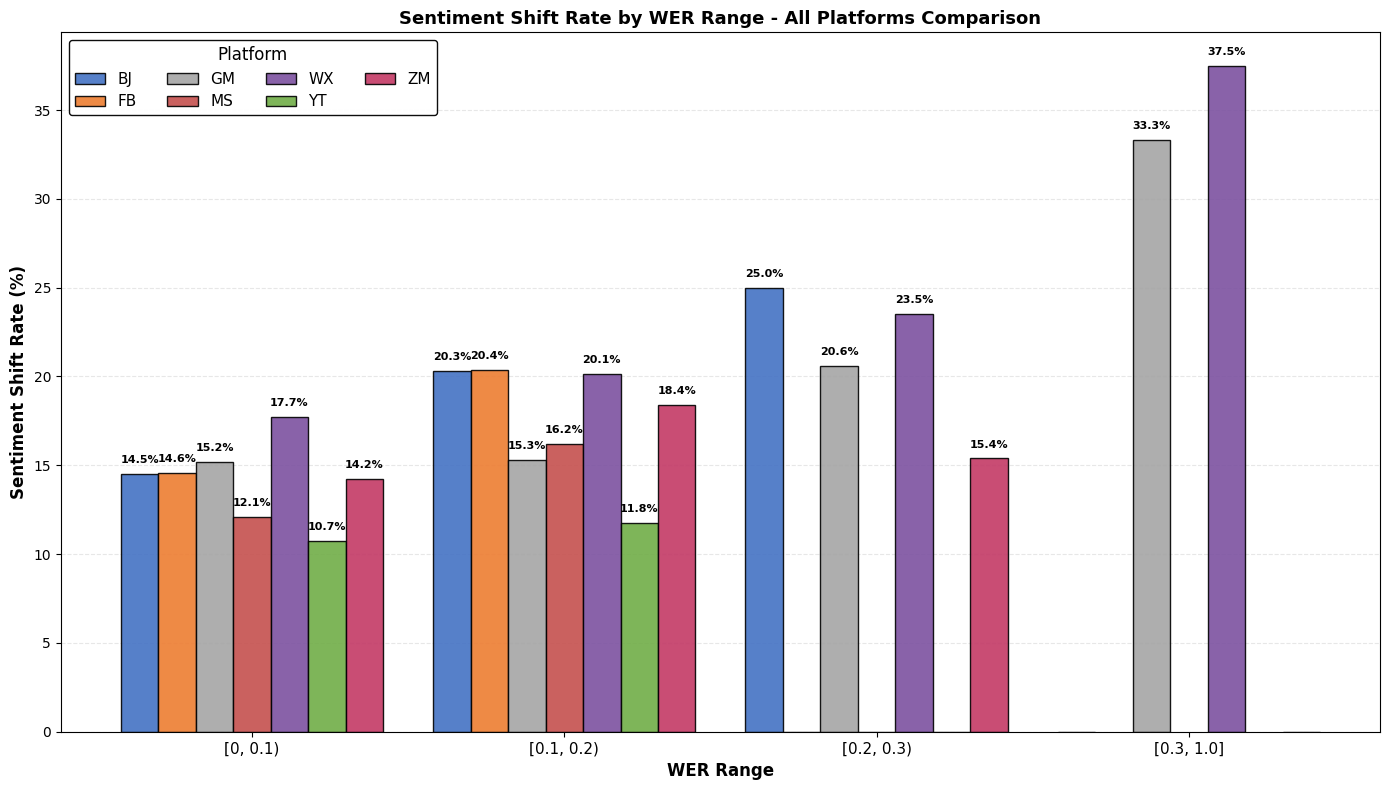

✓ Saved: plots_partA/02_combined_wer_range_shift_rate_all_in_one.pdf

--- Part 2.3: Creating Combined Logistic Regression Plots ---


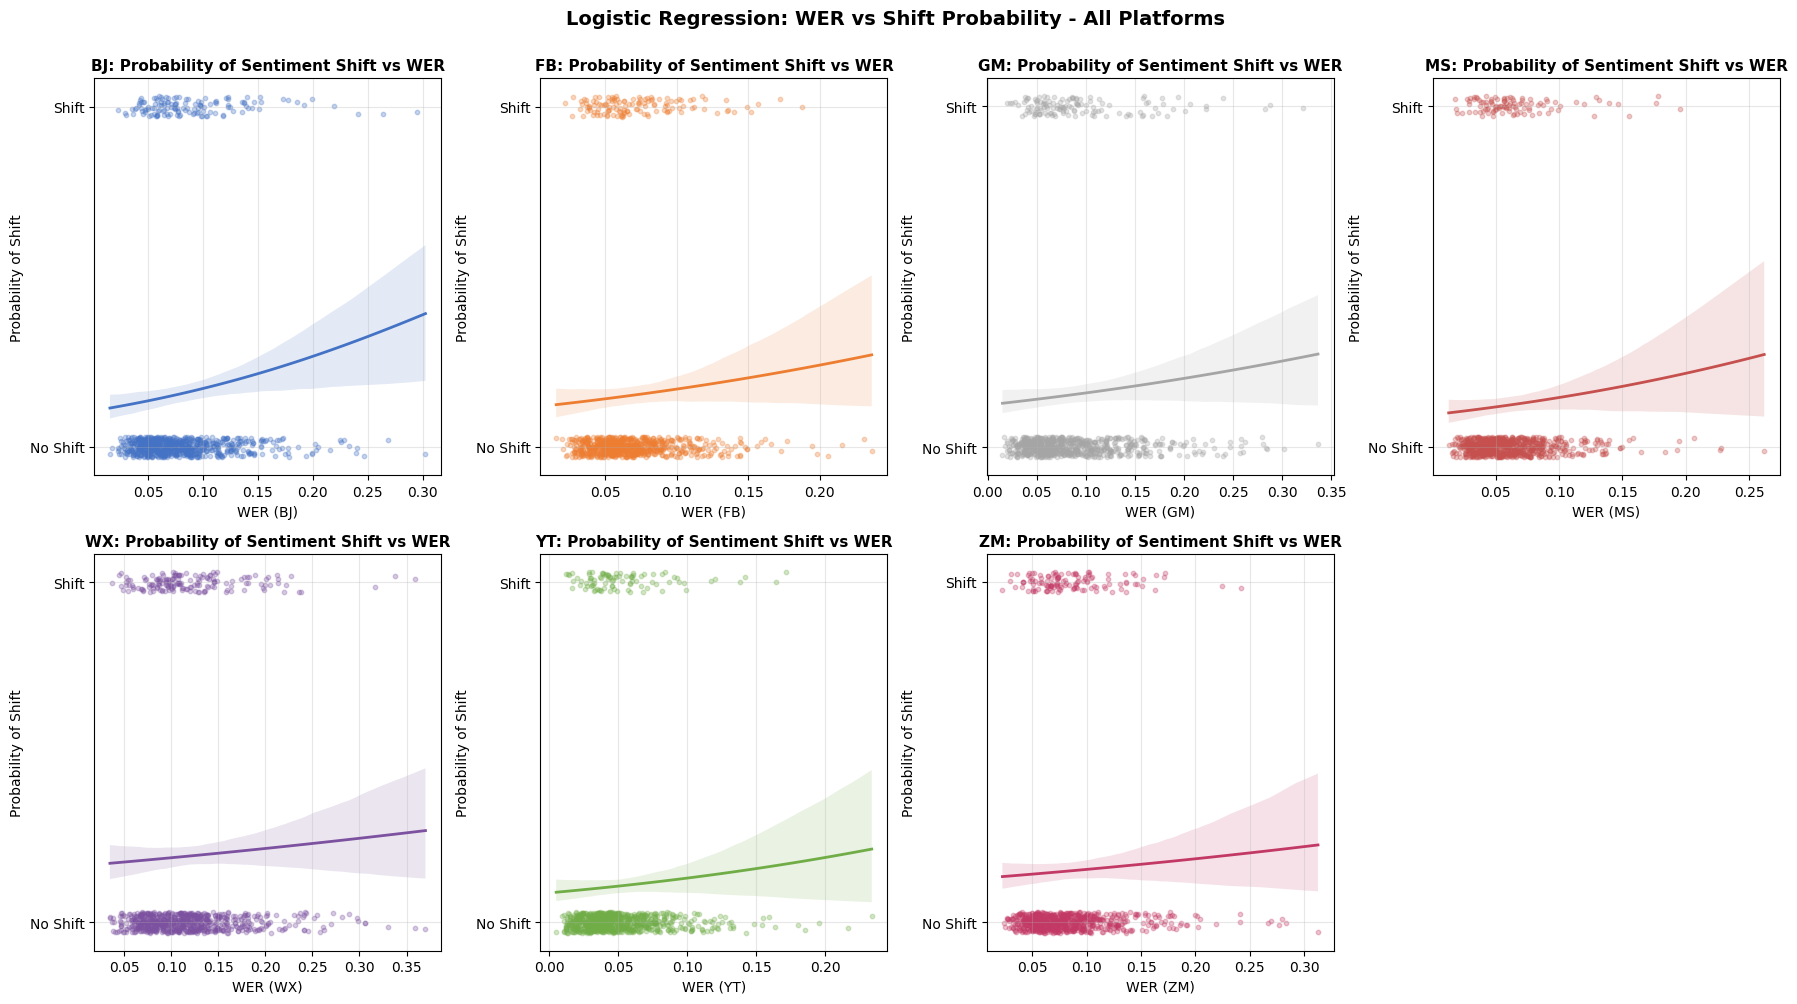

✓ Saved: plots_partA/03_combined_logistic_regression.pdf

=== Step 3: Generating Final Summary Table ===

✓ Aggregating final scores for platforms: BJ, FB, GM, MS, WX, YT, ZM
  BJ: Avg WER = 0.08092
  BJ: Sentiment Shift Rate = 15.96%
  FB: Avg WER = 0.06853
  FB: Sentiment Shift Rate = 15.25%
  GM: Avg WER = 0.08697
  GM: Sentiment Shift Rate = 15.48%
  MS: Avg WER = 0.06099
  MS: Sentiment Shift Rate = 12.41%
  WX: Avg WER = 0.11745
  WX: Sentiment Shift Rate = 19.50%
  YT: Avg WER = 0.05018
  YT: Sentiment Shift Rate = 10.76%
  ZM: Avg WER = 0.08282
  ZM: Sentiment Shift Rate = 15.13%

----------------------------------------------------------------------
FINAL AGGREGATE RESULTS TABLE
----------------------------------------------------------------------
 Overall_Rank Platform  Avg_WER  Sentiment_Shift_Rate_%
            1       YT 0.050179               10.756501
            2       MS 0.060995               12.411348
            3       FB 0.068528               15.248227
        

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import os
from google.colab import drive
import numpy as np

print("--- Full Part A Analysis (Combined Visualization with Custom Colors) ---")

# ================================
# SETUP: Mount Drive and Define Paths
# ================================
drive.mount('/content/drive', force_remount=True)

shift_input_file = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_wps.csv'
final_data_file = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'

output_plot_folder = "plots_partA"
os.makedirs(output_plot_folder, exist_ok=True)
print(f"Plots will be saved to: {output_plot_folder}/")

# ================================
# DEFINE CUSTOM COLORS (FROM YOUR LEGEND)
# ================================
platform_colors = {
    'BJ': '#4472C4',   # Blue
    'FB': '#ED7D31',   # Orange
    'GM': '#A5A5A5',   # Gray
    'MS': '#C5504E',   # Red
    'WX': '#7C51A0',   # Purple
    'YT': '#70AD47',   # Green
    'ZM': '#C33965'    # Pink/Magenta
}

# ================================
# STEP 1: LOAD OR CREATE SHIFT DATA
# ================================
print("\n" + "="*70)
print("STEP 1: Loading/Creating Shift Data")
print("="*70)

if os.path.exists(final_data_file):
    print(f"\n✓ Found existing file at: {final_data_file}")
    print("Loading it and skipping shift calculations.")
    try:
        df = pd.read_csv(final_data_file)
        print(f"✓ Loaded successfully. Rows: {len(df)}, Columns: {len(df.columns)}")
    except Exception as e:
        print(f"✗ Error loading existing file: {e}")
        raise
else:
    print(f"\n✗ File not found. Loading '{shift_input_file}' to calculate shifts...")
    try:
        df = pd.read_csv(shift_input_file)
        print(f"✓ Input file loaded successfully. Rows: {len(df)}, Columns: {len(df.columns)}")
    except FileNotFoundError:
        print(f"✗ Error: Input file not found at {shift_input_file}")
        raise
    except Exception as e:
        print(f"✗ Error loading input file: {e}")
        raise

    print("\n--- Calculating sentiment shifts ---")

    platforms_for_shift = [col.replace('_label', '') for col in df.columns if col.endswith('_label') and col != 'label']
    print(f"Auto-detecting platforms for shift calculation: {', '.join(platforms_for_shift)}")

    ref_label_col = 'label'

    if ref_label_col not in df.columns:
        print(f"✗ Error: Missing the reference column '{ref_label_col}'.")
        raise KeyError(f"Column '{ref_label_col}' not found")

    for p in platforms_for_shift:
        asr_label_col = f'{p}_label'
        shift_col = f'{p}_shift'

        if asr_label_col in df.columns:
            df[shift_col] = (df[ref_label_col] != df[asr_label_col]).astype(int)
            shift_count = df[shift_col].sum()
            print(f"✓ Created '{shift_col}' column. Shifts detected: {shift_count}")
        else:
            print(f"⚠ Skipping platform {p}: missing '{asr_label_col}'.")

    try:
        df.to_csv(final_data_file, index=False)
        print(f"\n✓ Successfully saved new file with shift data to: {final_data_file}")
    except Exception as e:
        print(f"✗ Error saving file: {e}")
        raise

print("\n✓ Step 1 Complete. 'df' is loaded with shift data.")

# ================================
# STEP 2: AUTO-DETECT PLATFORMS
# ================================

print("\n" + "="*70)
print("STEP 2: Auto-detecting WER columns")
print("="*70)

wer_columns = [col for col in df.columns if col.endswith('_WER')]
platforms = sorted([col.replace('_WER', '') for col in wer_columns])

if not platforms:
    print("\n✗ WARNING: No 'WER' columns found.")
    print(f"Available columns: {df.columns.tolist()}")
else:
    print(f"\n✓ Auto-detected WER columns: {', '.join(wer_columns)}")
    print(f"✓ Auto-detected platforms: {', '.join(platforms)}")

print("\n" + "="*70)
print("=== Step 2: Running Part A Analysis (Combined Plots) ===")
print("="*70)

# Create absolute sentiment intensity
if 'ref_sentiment' in df.columns:
    df['ref_sentiment_abs'] = df['ref_sentiment'].abs()
    print("\n✓ Created 'ref_sentiment_abs' column")
else:
    print("\n⚠ Warning: 'ref_sentiment' column not found.")
    platforms = []

if not platforms:
    print("⚠ No platforms to analyze.")
else:
    # =======================
    # 2.1: COMBINED CORRELATION PLOTS
    # =======================
    print("\n--- Part 2.1: Creating Combined Correlation Plots ---")

    num_platforms = len(platforms)
    cols = 4
    rows = (num_platforms + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 4*rows))
    axes = axes.flatten() if num_platforms > 1 else [axes]

    correlation_results = []

    for idx, p in enumerate(platforms):
        wer_col = f"{p}_WER"

        if wer_col not in df.columns:
            print(f"⚠ Skipping {p}: missing {wer_col}")
            continue

        temp_df = df[['ref_sentiment_abs', wer_col]].dropna()

        if temp_df.empty:
            print(f"⚠ Skipping {p}: No valid data.")
            continue

        if temp_df['ref_sentiment_abs'].nunique() <= 1 or temp_df[wer_col].nunique() <= 1:
            print(f"⚠ Skipping {p}: Not enough variance.")
            continue

        corr, pval = scipy.stats.pearsonr(temp_df['ref_sentiment_abs'], temp_df[wer_col])
        correlation_results.append([p, corr, pval])

        ax = axes[idx]
        # Use custom color for regression line
        sns.regplot(
            data=temp_df,
            x='ref_sentiment_abs',
            y=wer_col,
            scatter_kws={'s': 10, 'alpha': 0.5, 'color': platform_colors[p]},
            line_kws={'color': platform_colors[p], 'linewidth': 2},
            ax=ax
        )
        ax.set_title(f"{p}\n(r={corr:.3f}, p={pval:.2e})", fontweight='bold', fontsize=11)
        ax.set_xlabel("Absolute Sentiment Intensity", fontsize=10)
        ax.set_ylabel(f"WER", fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(len(platforms), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle("Sentiment Intensity vs WER - All Platforms", fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()

    pdf_path = f"{output_plot_folder}/01_combined_correlation_intensity_vs_wer.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_path}")

    # Save correlation table
    if correlation_results:
        corr_df = pd.DataFrame(correlation_results, columns=["Platform", "Correlation_r", "P_Value"])
        corr_df.to_csv(f"{output_plot_folder}/correlation_table_partA.csv", index=False)
        print(f"✓ Correlation table saved")

    # =======================
    # 2.2: COMBINED WER RANGE → SHIFT RATE (SINGLE GRAPH WITH CUSTOM COLORS)
    # =======================
    print("\n--- Part 2.2: Creating Combined WER Range → Shift Rate (Single Grouped Bar Chart) ---")

    bins = [0, 0.1, 0.2, 0.3, 1.0]
    labels = ['[0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 1.0]']

    all_shift_stats = []

    for p in platforms:
        wer_col = f"{p}_WER"
        shift_col = f"{p}_shift"

        if wer_col not in df.columns or shift_col not in df.columns:
            print(f"⚠ Skipping {p}: missing {wer_col} or {shift_col}")
            continue

        temp_df = df[[wer_col, shift_col]].dropna().copy()

        if temp_df.empty:
            print(f"⚠ Skipping {p}: No valid data.")
            continue

        temp_df['wer_bin'] = pd.cut(temp_df[wer_col], bins=bins, labels=labels, right=False, include_lowest=True)

        if not temp_df[temp_df[wer_col] == 1.0].empty:
            temp_df.loc[temp_df[wer_col] == 1.0, 'wer_bin'] = '[0.3, 1.0]'

        wer_stats = (temp_df.groupby('wer_bin', observed=True)[shift_col].mean() * 100).reset_index()
        wer_stats.rename(columns={shift_col: "Shift_Rate_Percent"}, inplace=True)
        wer_stats['Platform'] = p
        all_shift_stats.append(wer_stats)

        print(f"\n✓ Shift Rate for {p}:")
        print(wer_stats.to_string(index=False))

    # COMBINED: Create single bar chart with all platforms
    if all_shift_stats:
        combined_shift_df = pd.concat(all_shift_stats, ignore_index=True)
        combined_shift_df.to_csv(f"{output_plot_folder}/shift_rate_by_wer_bin_all.csv", index=False)
        print(f"\n✓ Shift rate table saved")

        # Create grouped bar chart with custom colors
        fig, ax = plt.subplots(figsize=(14, 8))

        # Prepare data for grouped bar chart
        pivot_data = combined_shift_df.pivot(index='wer_bin', columns='Platform', values='Shift_Rate_Percent')

        # Create x positions
        x = np.arange(len(pivot_data.index))
        width = 0.12  # width of each bar

        # Plot bars for each platform with custom colors
        for idx, platform in enumerate(platforms):
            if platform in pivot_data.columns:
                offset = (idx - len(platforms)/2 + 0.5) * width
                bars = ax.bar(x + offset, pivot_data[platform], width,
                             label=platform, color=platform_colors[platform],
                             edgecolor='black', alpha=0.90)

                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    if not np.isnan(height) and height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                               f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Customize plot
        ax.set_xlabel('WER Range', fontsize=12, fontweight='bold')
        ax.set_ylabel('Sentiment Shift Rate (%)', fontsize=12, fontweight='bold')
        ax.set_title('Sentiment Shift Rate by WER Range - All Platforms Comparison',
                    fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_data.index, fontsize=11)
        ax.legend(title='Platform', fontsize=11, title_fontsize=12, ncol=4, loc='upper left',
                 framealpha=0.95, edgecolor='black')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)

        plt.tight_layout()

        pdf_path = f"{output_plot_folder}/02_combined_wer_range_shift_rate_all_in_one.pdf"
        plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        print(f"✓ Saved: {pdf_path}")

    # =======================
    # 2.3: COMBINED LOGISTIC REGRESSION PLOTS
    # =======================
    print("\n--- Part 2.3: Creating Combined Logistic Regression Plots ---")

    cols = 4
    rows = (num_platforms + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5*rows))
    axes = axes.flatten() if num_platforms > 1 else [axes]

    for idx, p in enumerate(platforms):
        wer_col = f"{p}_WER"
        shift_col = f"{p}_shift"

        if wer_col not in df.columns or shift_col not in df.columns:
            print(f"⚠ Skipping {p}: missing {wer_col} or {shift_col}")
            continue

        temp_df = df[[wer_col, shift_col]].dropna().copy()

        if temp_df.empty:
            print(f"⚠ Skipping {p}: No valid data.")
            continue

        temp_df[shift_col] = temp_df[shift_col].astype(int)

        if temp_df[shift_col].nunique() <= 1:
            print(f"⚠ Skipping {p}: Only one outcome.")
            continue

        ax = axes[idx]
        sns.regplot(
            data=temp_df,
            x=wer_col,
            y=shift_col,
            logistic=True,
            y_jitter=0.03,
            scatter_kws={'s': 10, 'alpha': 0.3, 'color': platform_colors[p]},
            line_kws={'color': platform_colors[p], 'linewidth': 2},
            ax=ax
        )

        ax.set_title(f"{p}: Probability of Sentiment Shift vs WER", fontweight='bold', fontsize=11)
        ax.set_xlabel(f"WER ({p})", fontsize=10)
        ax.set_ylabel("Probability of Shift", fontsize=10)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['No Shift', 'Shift'])
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(len(platforms), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle("Logistic Regression: WER vs Shift Probability - All Platforms", fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()

    pdf_path = f"{output_plot_folder}/03_combined_logistic_regression.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_path}")

# ====================================================================
# STEP 3: GENERATE FINAL SUMMARY TABLE
# ====================================================================

print("\n" + "="*70)
print("=== Step 3: Generating Final Summary Table ===")
print("="*70)

results_list = []

if not platforms:
    print("⚠ Skipping final table: No platforms were detected.")
else:
    print(f"\n✓ Aggregating final scores for platforms: {', '.join(platforms)}")

    for p in platforms:
        platform_scores = {'Platform': p}

        wer_col = f"{p}_WER"
        if wer_col in df.columns:
            mean_wer = df[wer_col].mean()
            platform_scores['Avg_WER'] = mean_wer
            print(f"  {p}: Avg WER = {mean_wer:.5f}")
        else:
            platform_scores['Avg_WER'] = np.nan

        shift_col = f"{p}_shift"
        if shift_col in df.columns:
            shift_rate = df[shift_col].mean() * 100
            platform_scores['Sentiment_Shift_Rate_%'] = shift_rate
            print(f"  {p}: Sentiment Shift Rate = {shift_rate:.2f}%")
        else:
            platform_scores['Sentiment_Shift_Rate_%'] = np.nan

        results_list.append(platform_scores)

    if results_list:
        results_df = pd.DataFrame(results_list)
        results_df = results_df.sort_values(by='Avg_WER', ascending=True).reset_index(drop=True)
        results_df['Overall_Rank'] = np.arange(1, len(results_df) + 1)

        column_order = ['Overall_Rank', 'Platform', 'Avg_WER', 'Sentiment_Shift_Rate_%']
        results_df = results_df[column_order]

        print("\n" + "-"*70)
        print("FINAL AGGREGATE RESULTS TABLE")
        print("-"*70)
        print(results_df.to_string(index=False))

        results_df.to_csv(f"{output_plot_folder}/FINAL_summary_table.csv", index=False)
        print(f"\n✓ Final summary table saved to: {output_plot_folder}/FINAL_summary_table.csv")
    else:
        print("⚠ No results to display.")

print("\n" + "="*70)
print("✓ Full Analysis Complete")
print("="*70)
print(f"All combined PDFs and CSVs saved in folder: {output_plot_folder}/")
print("\nGenerated files:")
print("  1. 01_combined_correlation_intensity_vs_wer.pdf (all platforms in grid)")
print("  2. 02_combined_wer_range_shift_rate_all_in_one.pdf (SINGLE grouped bar chart)")
print("  3. 03_combined_logistic_regression.pdf (all platforms in grid)")
print("  4. correlation_table_partA.csv")
print("  5. shift_rate_by_wer_bin_all.csv")
print("  6. FINAL_summary_table.csv")


## PART B: WER vs SENTIMENT CHANGE TYPE

PART B: WER vs SENTIMENT CHANGE TYPE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loading data from: /content/drive/My Drive/Analysis/labels_sentiment_with_shifts.csv

✓ DataFrame loaded successfully.
  Total rows: 846
  Total columns: 50

✓ Output folder created: plots_partB/

✓ Auto-detected platforms: BJ, FB, GM, MS, WX, YT, ZM
✓ Using 'label' as the reference sentiment category

=== PART B: WER vs Sentiment Change Type ===

--- Processing Platform: BJ ---
✓ CSV saved: plots_partB/sentiment_change_table_BJ.csv
✓ Found 9 sentiment change types

--- BJ: Sentiment Change Statistics ---
BJ_sentiment_change  Average_WER  Row_Count
 neutral → positive     0.109121         23
negative → positive     0.095845          6
 positive → neutral     0.092322         14
 neutral → negative     0.087069         41
 negative → neutral     0.082766         42
negative → negative     0.081824        518
positive → neg

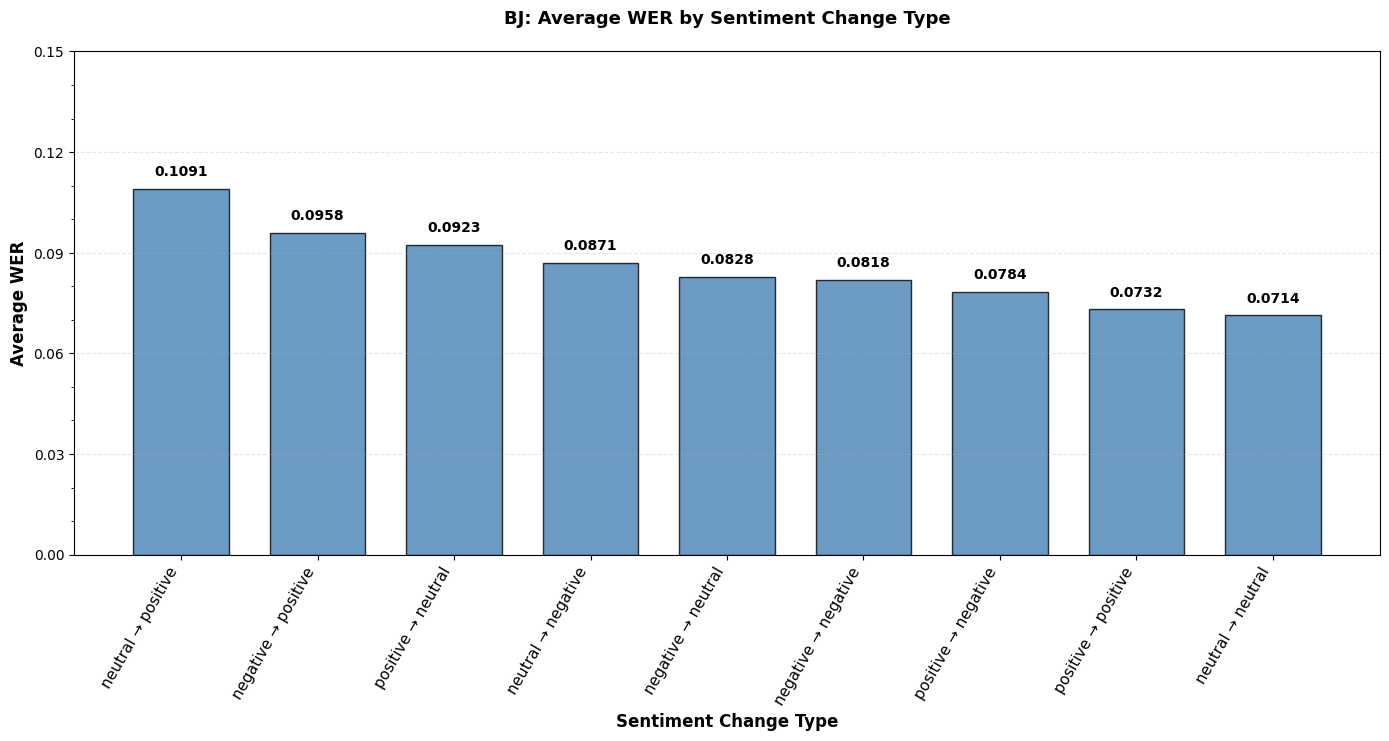


--- Processing Platform: FB ---
✓ CSV saved: plots_partB/sentiment_change_table_FB.csv
✓ Found 9 sentiment change types

--- FB: Sentiment Change Statistics ---
FB_sentiment_change  Average_WER  Row_Count
 neutral → negative     0.075285         32
 neutral → positive     0.074423         28
 negative → neutral     0.074023         42
negative → negative     0.069108        519
positive → positive     0.065055         97
 positive → neutral     0.064519         19
  neutral → neutral     0.064244        101
negative → positive     0.062562          5
positive → negative     0.056110          3
✓ PDF saved: plots_partB/sentiment_change_FB.pdf


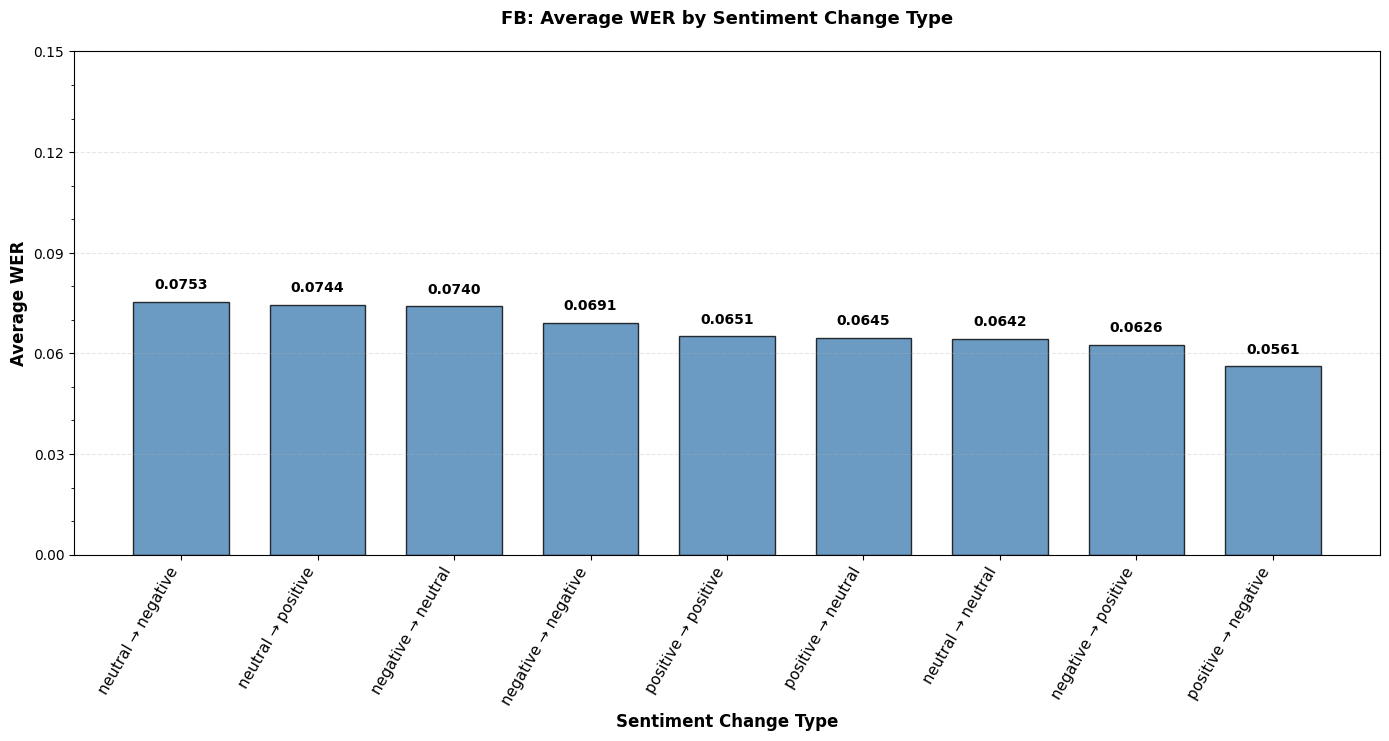


--- Processing Platform: GM ---
✓ CSV saved: plots_partB/sentiment_change_table_GM.csv
✓ Found 9 sentiment change types

--- GM: Sentiment Change Statistics ---
GM_sentiment_change  Average_WER  Row_Count
 neutral → negative     0.111098         41
 neutral → positive     0.094223         20
 negative → neutral     0.091870         45
negative → negative     0.088246        519
positive → positive     0.081644         96
 positive → neutral     0.078808         16
  neutral → neutral     0.076264        100
positive → negative     0.055784          7
negative → positive     0.043635          2
✓ PDF saved: plots_partB/sentiment_change_GM.pdf


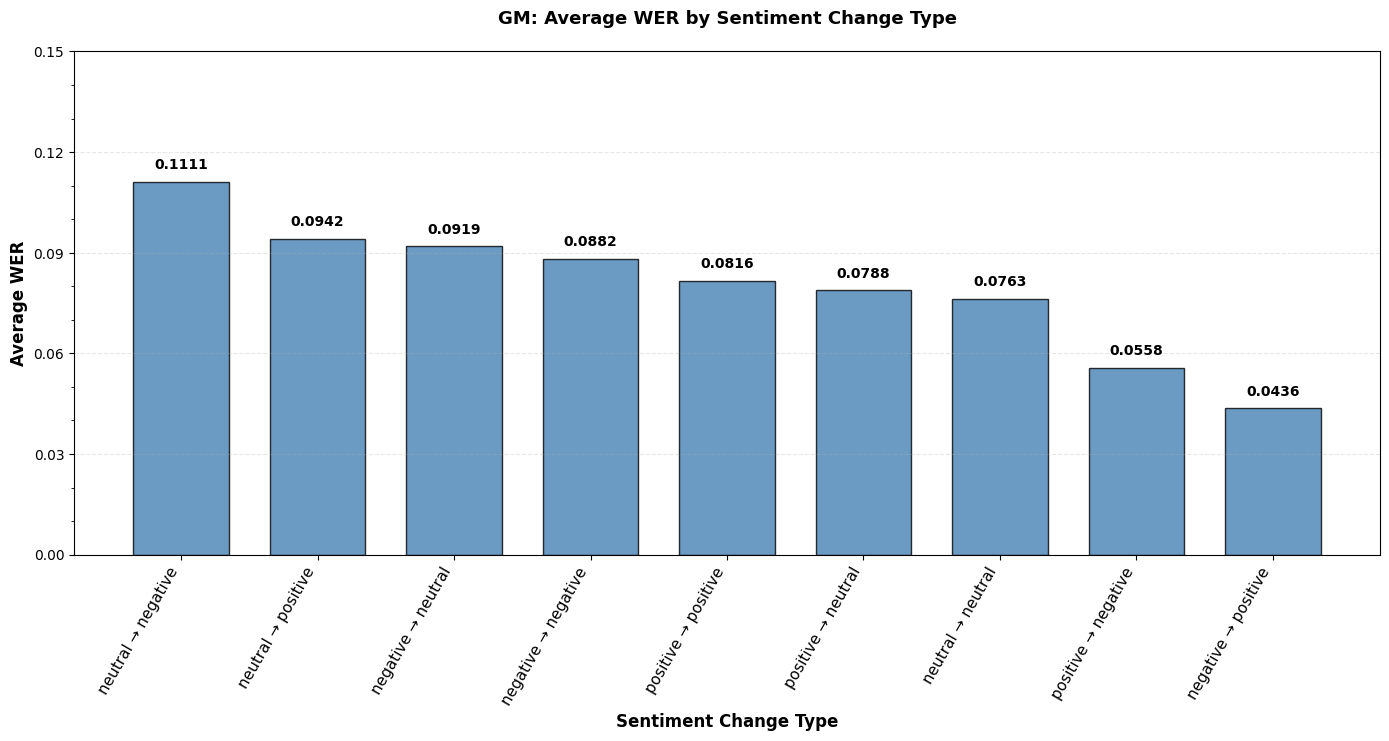


--- Processing Platform: MS ---
✓ CSV saved: plots_partB/sentiment_change_table_MS.csv
✓ Found 9 sentiment change types

--- MS: Sentiment Change Statistics ---
MS_sentiment_change  Average_WER  Row_Count
 neutral → positive     0.075769         17
 negative → neutral     0.066244         38
positive → negative     0.065460          1
 positive → neutral     0.063707         16
 neutral → negative     0.061647         28
negative → negative     0.060832        523
  neutral → neutral     0.059777        116
positive → positive     0.058490        102
negative → positive     0.053980          5
✓ PDF saved: plots_partB/sentiment_change_MS.pdf


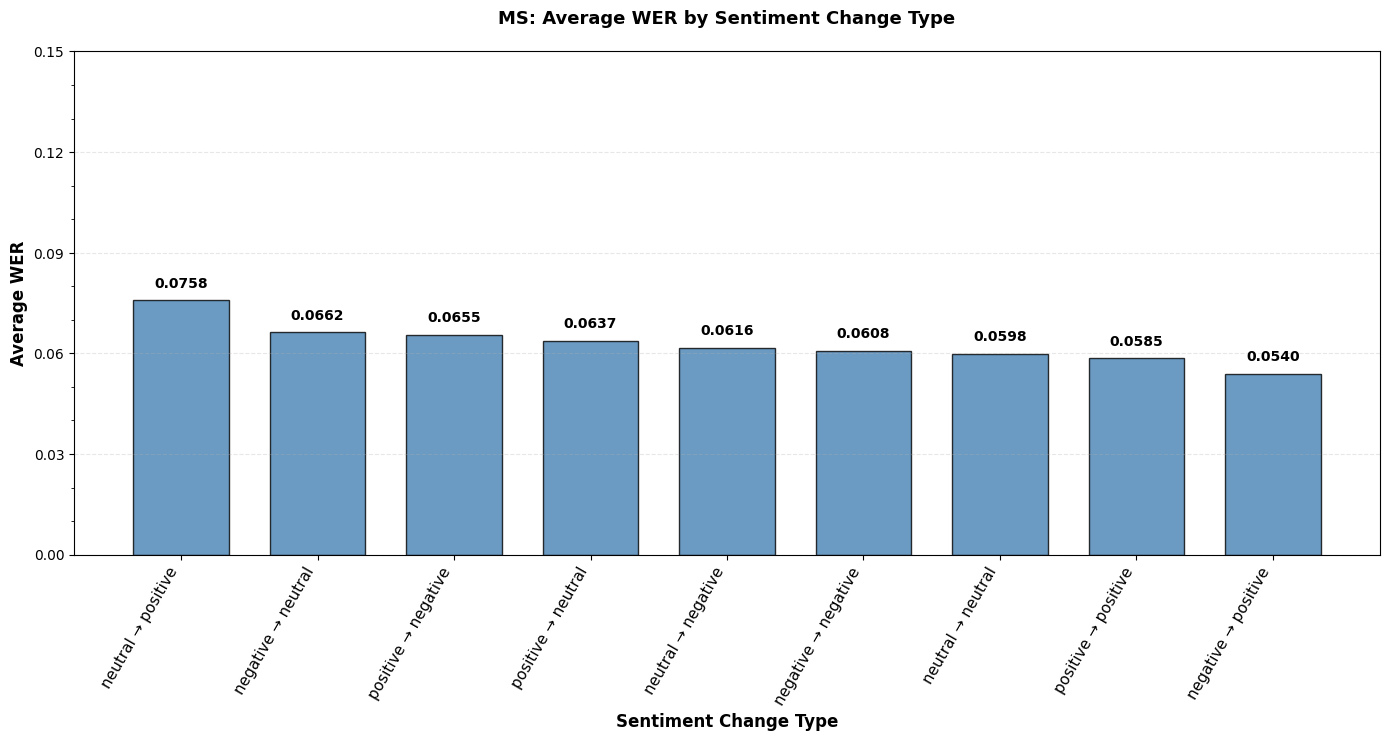


--- Processing Platform: WX ---
✓ CSV saved: plots_partB/sentiment_change_table_WX.csv
✓ Found 9 sentiment change types

--- WX: Sentiment Change Statistics ---
WX_sentiment_change  Average_WER  Row_Count
 neutral → negative     0.126792         55
 neutral → positive     0.120884         20
positive → negative     0.120782          9
 positive → neutral     0.120445         31
 negative → neutral     0.119276         45
negative → negative     0.117699        516
  neutral → neutral     0.113689         86
positive → positive     0.112402         79
negative → positive     0.078192          5
✓ PDF saved: plots_partB/sentiment_change_WX.pdf


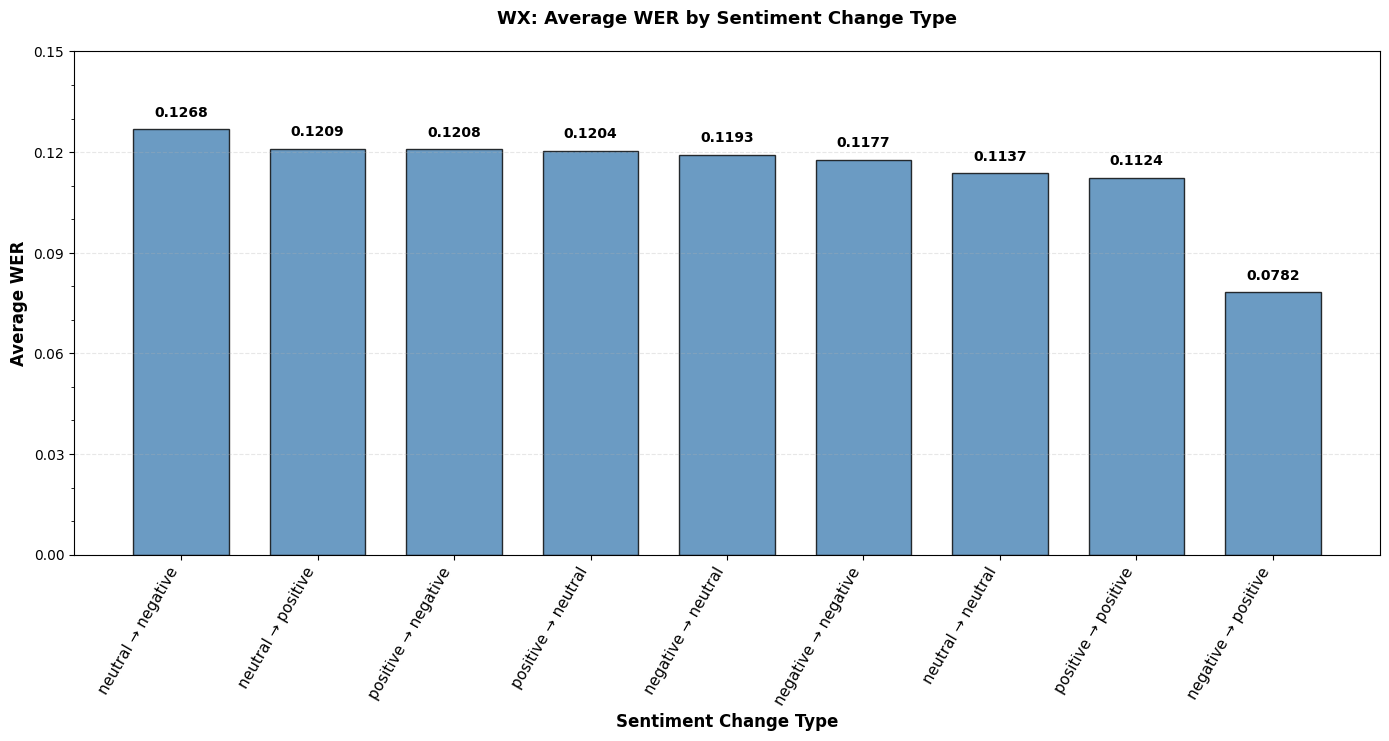


--- Processing Platform: YT ---
✓ CSV saved: plots_partB/sentiment_change_table_YT.csv
✓ Found 9 sentiment change types

--- YT: Sentiment Change Statistics ---
YT_sentiment_change  Average_WER  Row_Count
negative → positive     0.079050          3
 neutral → positive     0.056676         18
 neutral → negative     0.055626         28
 negative → neutral     0.054058         28
positive → negative     0.052847          3
negative → negative     0.050246        535
  neutral → neutral     0.048662        115
positive → positive     0.048153        105
 positive → neutral     0.039099         11
✓ PDF saved: plots_partB/sentiment_change_YT.pdf


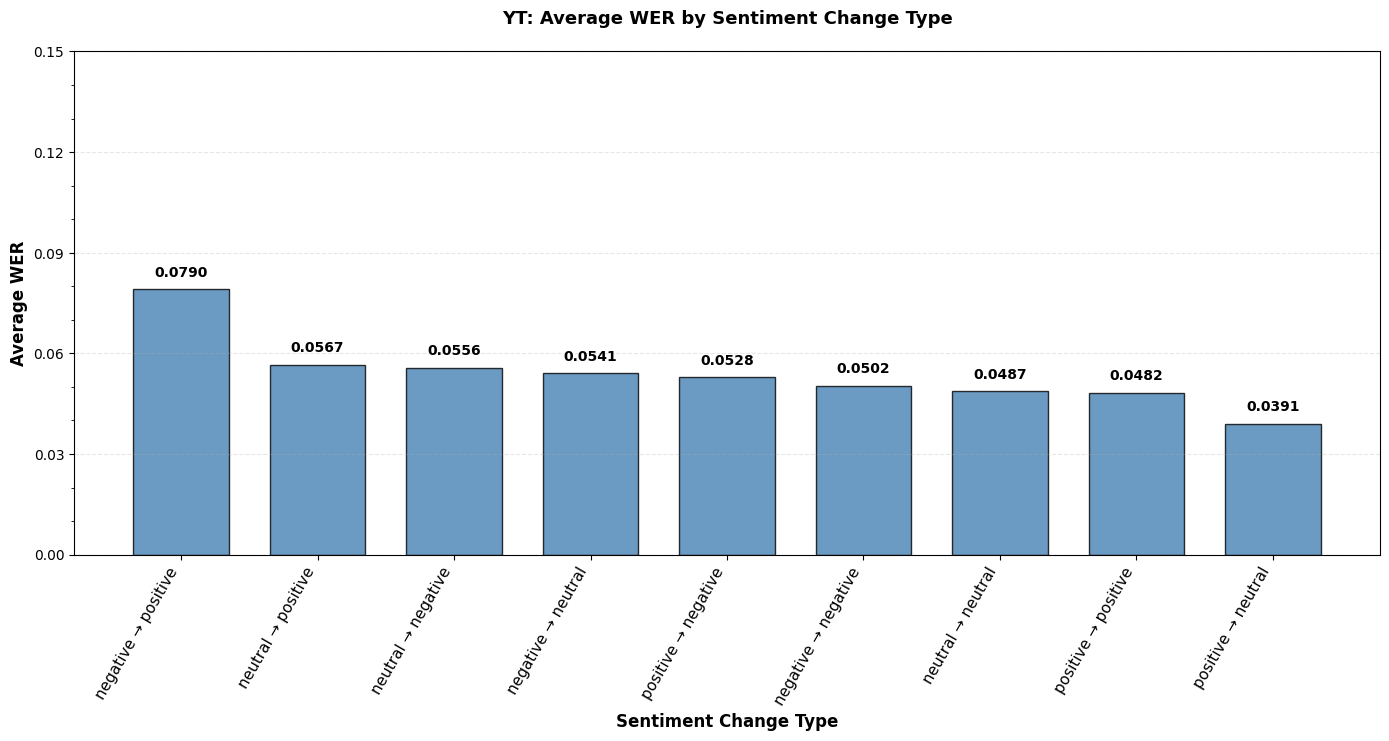


--- Processing Platform: ZM ---
✓ CSV saved: plots_partB/sentiment_change_table_ZM.csv
✓ Found 8 sentiment change types

--- ZM: Sentiment Change Statistics ---
ZM_sentiment_change  Average_WER  Row_Count
positive → negative     0.094557          6
 neutral → positive     0.092446         14
 positive → neutral     0.090288         23
 neutral → negative     0.087190         41
negative → negative     0.083037        522
  neutral → neutral     0.081389        106
 negative → neutral     0.079066         44
positive → positive     0.078915         90
✓ PDF saved: plots_partB/sentiment_change_ZM.pdf


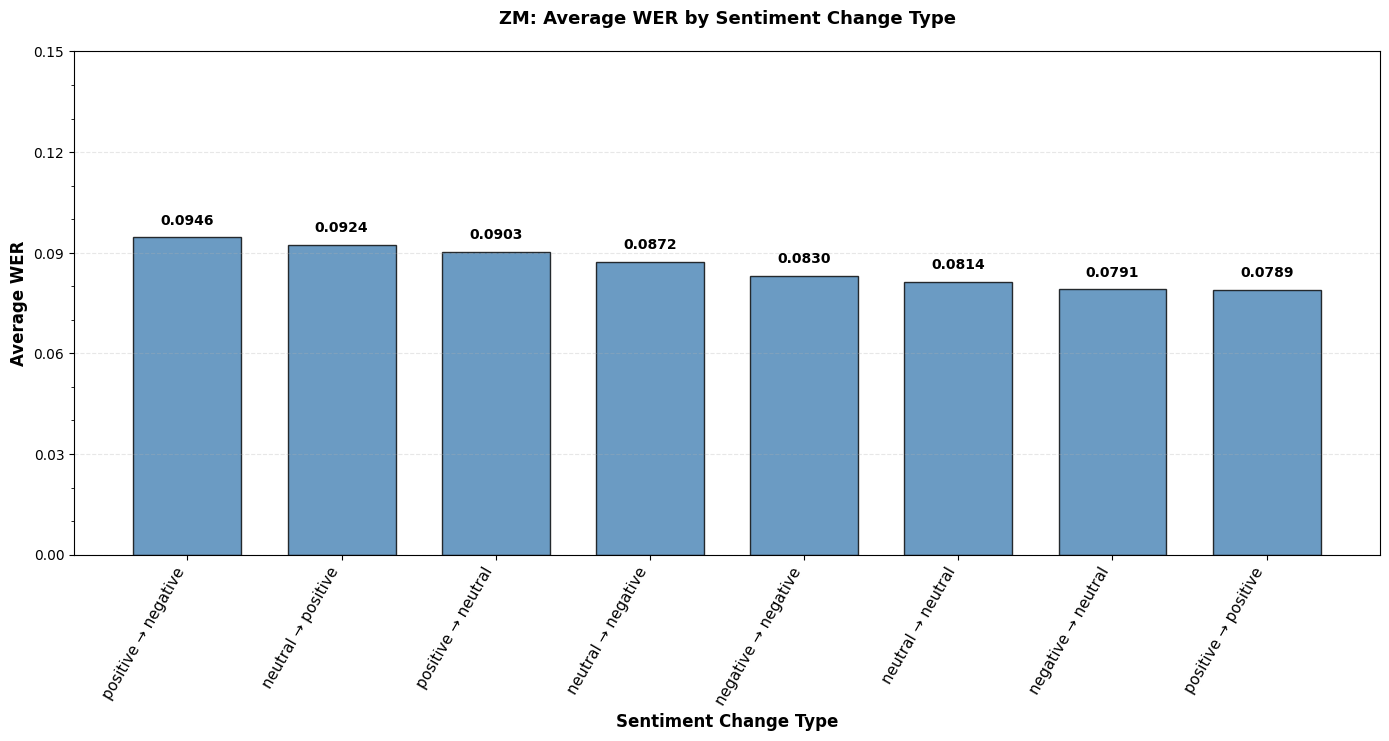


=== COMBINED RESULTS: ALL PLATFORMS (PIVOTED FORMAT) ===

✓ Total unique sentiment changes found: 9
  All changes: ['negative → negative', 'negative → neutral', 'negative → positive', 'neutral → negative', 'neutral → neutral', 'neutral → positive', 'positive → negative', 'positive → neutral', 'positive → positive']


   Sentiment_Change  BJ_WER  BJ_Count  FB_WER  FB_Count  GM_WER  GM_Count  MS_WER  MS_Count  WX_WER  WX_Count  YT_WER  YT_Count  ZM_WER  ZM_Count
 neutral → positive  0.1091        23  0.0744        28  0.0942        20  0.0758        17  0.1209        20  0.0567        18  0.0924        14
negative → positive  0.0958         6  0.0626         5  0.0436         2  0.0540         5  0.0782         5  0.0790         3  0.0000         0
 positive → neutral  0.0923        14  0.0645        19  0.0788        16  0.0637        16  0.1204        31  0.0391        11  0.0903        23
 neutral → negative  0.0871        41  0.0753        32  0.1111        41  0.0616        28  0.1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from google.colab import drive
import numpy as np

# ================================
# SETUP: Load data from previous step
# ================================

print("=" * 70)
print("PART B: WER vs SENTIMENT CHANGE TYPE")
print("=" * 70)

# Mount Google Drive
drive.mount('/content/drive')

# Load the file with WPS and sentiment data (from Block 3)
csv_to_load = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'
print(f"\nLoading data from: {csv_to_load}\n")

try:
    df = pd.read_csv(csv_to_load)
    print(f"✓ DataFrame loaded successfully.")
    print(f"  Total rows: {len(df)}")
    print(f"  Total columns: {len(df.columns)}")
except FileNotFoundError:
    print(f"✗ Error: File not found at '{csv_to_load}'.")
    raise
except Exception as e:
    print(f"✗ Error reading CSV file: {e}")
    raise

# ======================================
# PART B: WER vs SENTIMENT CHANGE TYPE
# ======================================

# Output folder
output_folder = "plots_partB"
os.makedirs(output_folder, exist_ok=True)
print(f"\n✓ Output folder created: {output_folder}/")

# Auto-detect platforms based on the _WER columns
wer_columns = [col for col in df.columns if col.endswith('_WER')]
platforms = sorted([col.replace('_WER', '') for col in wer_columns])

if not platforms:
    print("\n✗ WARNING: No '_WER' columns found in the dataset!")
    raise KeyError("No WER columns found in the dataset")

print(f"\n✓ Auto-detected platforms: {', '.join(platforms)}")

# --- Reference sentiment column (gold standard) ---
ref_sent_col = "label"

if ref_sent_col not in df.columns:
    print(f"\n✗ Error: Reference column '{ref_sent_col}' not found in DataFrame!")
    raise KeyError(f"Column '{ref_sent_col}' not found")

print(f"✓ Using '{ref_sent_col}' as the reference sentiment category")

print("\n" + "=" * 70)
print("=== PART B: WER vs Sentiment Change Type ===")
print("=" * 70)

# Store all results for combined analysis
all_results = []
all_sentiment_changes = set()  # Track all unique sentiment changes

for p in platforms:
    wer_col = f"{p}_WER"
    asr_sent_col = f"{p}_label"
    sentiment_change_col = f"{p}_sentiment_change"

    print(f"\n--- Processing Platform: {p} ---")

    # Check that all required columns exist for this platform
    if wer_col not in df.columns or asr_sent_col not in df.columns:
        print(f"⚠ Skipping {p}: missing required columns")
        continue

    # Create sentiment change column
    df[sentiment_change_col] = (
        df[ref_sent_col].fillna("N/A").astype(str) + " → " +
        df[asr_sent_col].fillna("N/A").astype(str)
    )

    # Drop rows where either WER or sentiment columns have NaN values
    temp_df = df[[wer_col, sentiment_change_col]].dropna()

    if temp_df.empty:
        print(f"⚠ Skipping {p}: No valid data")
        continue

    # Compute average WER + count for each change type
    grouped = df[[wer_col, sentiment_change_col]].dropna().groupby(sentiment_change_col, as_index=False).agg(
        Average_WER=(wer_col, "mean"),
        Median_WER=(wer_col, "median"),
        Std_WER=(wer_col, "std"),
        Row_Count=(wer_col, "size")
    ).sort_values(by="Average_WER", ascending=False)

    # Add platform name to results
    grouped['Platform'] = p
    grouped['Sentiment_Change'] = grouped[sentiment_change_col]
    grouped['Row_Count'] = grouped['Row_Count'].astype(int)

    # Track all sentiment changes
    all_sentiment_changes.update(grouped['Sentiment_Change'].unique())

    # Store results for combined table
    all_results.append(grouped)

    # Save CSV
    csv_path = f"{output_folder}/sentiment_change_table_{p}.csv"
    grouped.to_csv(csv_path, index=False)
    print(f"✓ CSV saved: {csv_path}")
    print(f"✓ Found {len(grouped)} sentiment change types")

    print(f"\n--- {p}: Sentiment Change Statistics ---")
    display_df = grouped[[sentiment_change_col, 'Average_WER', 'Row_Count']].copy()
    display_df.columns = [sentiment_change_col, 'Average_WER', 'Row_Count']
    print(display_df.to_string(index=False))

    # ------------------------------------
    # VERTICAL BAR CHART
    # ------------------------------------
    if len(grouped) > 0:
        num_items = len(grouped)
        fig_width = max(14, num_items * 1.2)
        fig_height = 7

        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        bars = ax.bar(
            range(len(grouped)),
            grouped["Average_WER"],
            color="steelblue",
            edgecolor="black",
            alpha=0.8,
            width=0.7
        )

        # Add value labels
        for i, (idx, row) in enumerate(grouped.iterrows()):
            ax.text(
                i,
                row["Average_WER"] + 0.003,
                f"{row['Average_WER']:.4f}",
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )

        ax.set_xticks(range(len(grouped)))
        ax.set_xticklabels(
            grouped[sentiment_change_col],
            rotation=60,
            ha='right',
            fontsize=11
        )

        ax.set_ylabel("Average WER", fontsize=12, fontweight='bold')
        ax.set_xlabel("Sentiment Change Type", fontsize=12, fontweight='bold')
        ax.set_title(f"{p}: Average WER by Sentiment Change Type", fontsize=13, fontweight='bold', pad=20)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.set_ylim(0, 0.15)
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.03))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.2)

        pdf_path = f"{output_folder}/sentiment_change_{p}.pdf"
        plt.savefig(pdf_path, format="pdf", dpi=300, bbox_inches='tight')
        print(f"✓ PDF saved: {pdf_path}")
        plt.show()
        plt.close()

# ========================================
# COMBINED RESULTS TABLE - REPLACE NaN WITH 0
# ========================================

if all_results:
    print("\n" + "=" * 70)
    print("=== COMBINED RESULTS: ALL PLATFORMS (PIVOTED FORMAT) ===")
    print("=" * 70)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Get all unique sentiment changes from the actual data
    unique_sentiments = sorted(list(all_sentiment_changes))

    print(f"\n✓ Total unique sentiment changes found: {len(unique_sentiments)}")
    print(f"  All changes: {unique_sentiments}\n")

    # Initialize list to store pivoted data
    pivot_data = []

    # For each unique sentiment change, create a row
    for sentiment_change in unique_sentiments:
        row_data = {'Sentiment_Change': sentiment_change}

        # For each platform, get WER and Count
        for platform in platforms:
            platform_data = combined_df[(combined_df['Platform'] == platform) &
                                       (combined_df['Sentiment_Change'] == sentiment_change)]

            if len(platform_data) > 0:
                avg_wer = platform_data.iloc[0]['Average_WER']
                count_val = platform_data.iloc[0]['Row_Count']

                row_data[f'{platform}_WER'] = round(avg_wer, 4) if pd.notna(avg_wer) else 0
                row_data[f'{platform}_Count'] = int(count_val) if pd.notna(count_val) else 0
            else:
                # FIXED: Use 0 instead of NaN for missing data
                row_data[f'{platform}_WER'] = 0
                row_data[f'{platform}_Count'] = 0

        pivot_data.append(row_data)

    # Create pivoted dataframe
    pivoted_df = pd.DataFrame(pivot_data)

    # Reorder columns
    col_order = ['Sentiment_Change']
    for platform in platforms:
        col_order.append(f'{platform}_WER')
        col_order.append(f'{platform}_Count')

    pivoted_df = pivoted_df[col_order]

    # Sort by first platform's WER descending (0 values at bottom)
    # Separate rows with 0 count from rows with actual data
    pivoted_df['has_data'] = (pivoted_df[f'{platforms[0]}_Count'] > 0).astype(int)
    pivoted_df = pivoted_df.sort_values(
        by=[f'{platforms[0]}_WER', 'has_data'],
        ascending=[False, False]
    ).drop('has_data', axis=1).reset_index(drop=True)

    print("\n" + pivoted_df.to_string(index=False))

    # Save pivoted table
    combined_csv_path = f"{output_folder}/combined_sentiment_change_all_platforms.csv"
    pivoted_df.to_csv(combined_csv_path, index=False)
    print(f"\n✓ Pivoted combined table saved: {combined_csv_path}")

    # ==========================================
    # SUMMARY STATISTICS BY PLATFORM
    # ==========================================
    print("\n" + "=" * 70)
    print("=== SUMMARY STATISTICS BY PLATFORM ===")
    print("=" * 70)

    platform_summary = combined_df.groupby('Platform').agg(
        Total_Changes=('Average_WER', 'count'),
        Min_WER=('Average_WER', 'min'),
        Max_WER=('Average_WER', 'max'),
        Mean_WER=('Average_WER', 'mean'),
        Median_WER=('Average_WER', 'median'),
        Total_Rows=('Row_Count', 'sum')
    ).reset_index()

    print("\n" + platform_summary.to_string(index=False))

    # Save platform summary
    summary_csv_path = f"{output_folder}/platform_summary.csv"
    platform_summary.to_csv(summary_csv_path, index=False)
    print(f"\n✓ Platform summary saved: {summary_csv_path}")

else:
    print("\n✗ No results generated. Please check your data and column names.")

print("\n" + "=" * 70)
print("✓ PART B COMPLETE")
print("=" * 70)
print(f"All outputs saved in folder: {output_folder}/")


COMBINED VISUALIZATION: WER by Sentiment Change (All Platforms)

Loading combined data from: plots_partB/combined_sentiment_change_all_platforms.csv

✓ Combined data loaded successfully.
  Total rows (sentiment changes): 9
  Total platforms: 7

Preparing data for combined visualization...

✓ Data prepared: 63 data points
  Sentiment changes: 9
  Platforms: 7

Creating combined grouped bar chart...

✓ PDF saved to Colab: plots_partB/combined_all_platforms_grouped_bars.pdf


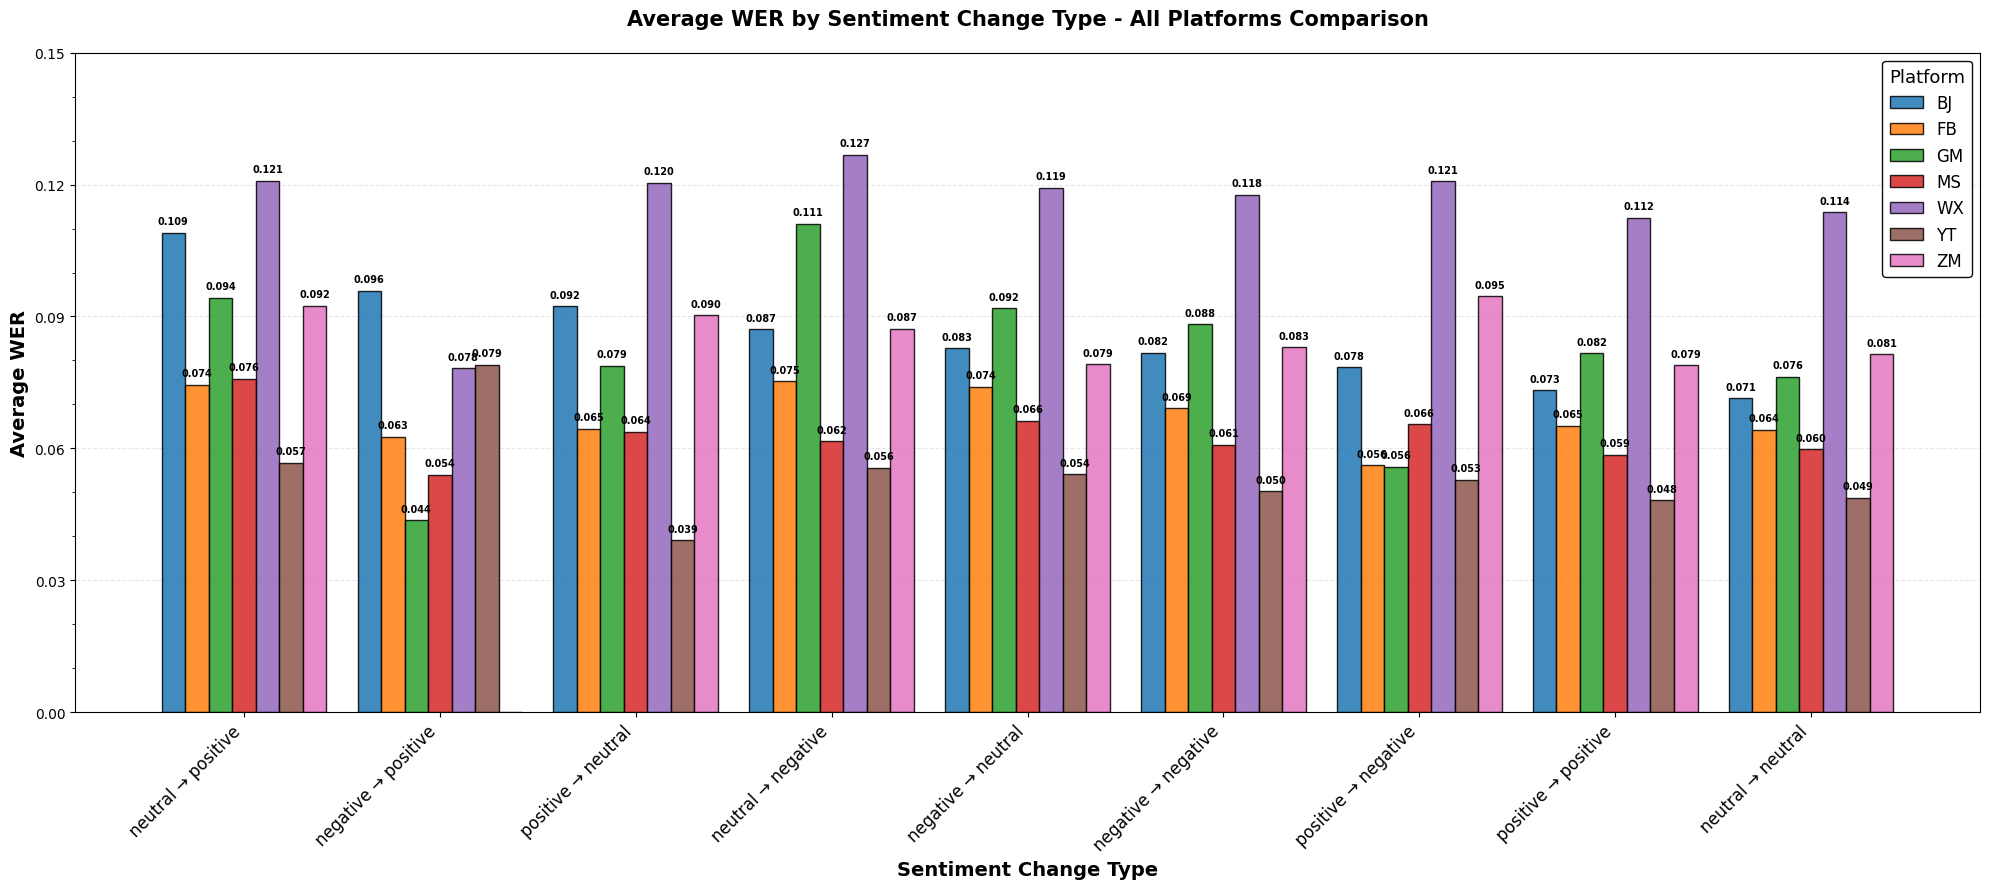


Creating alternative: line plot with all platforms overlayed...
✓ PDF saved to Colab: plots_partB/combined_all_platforms_line_plot.pdf


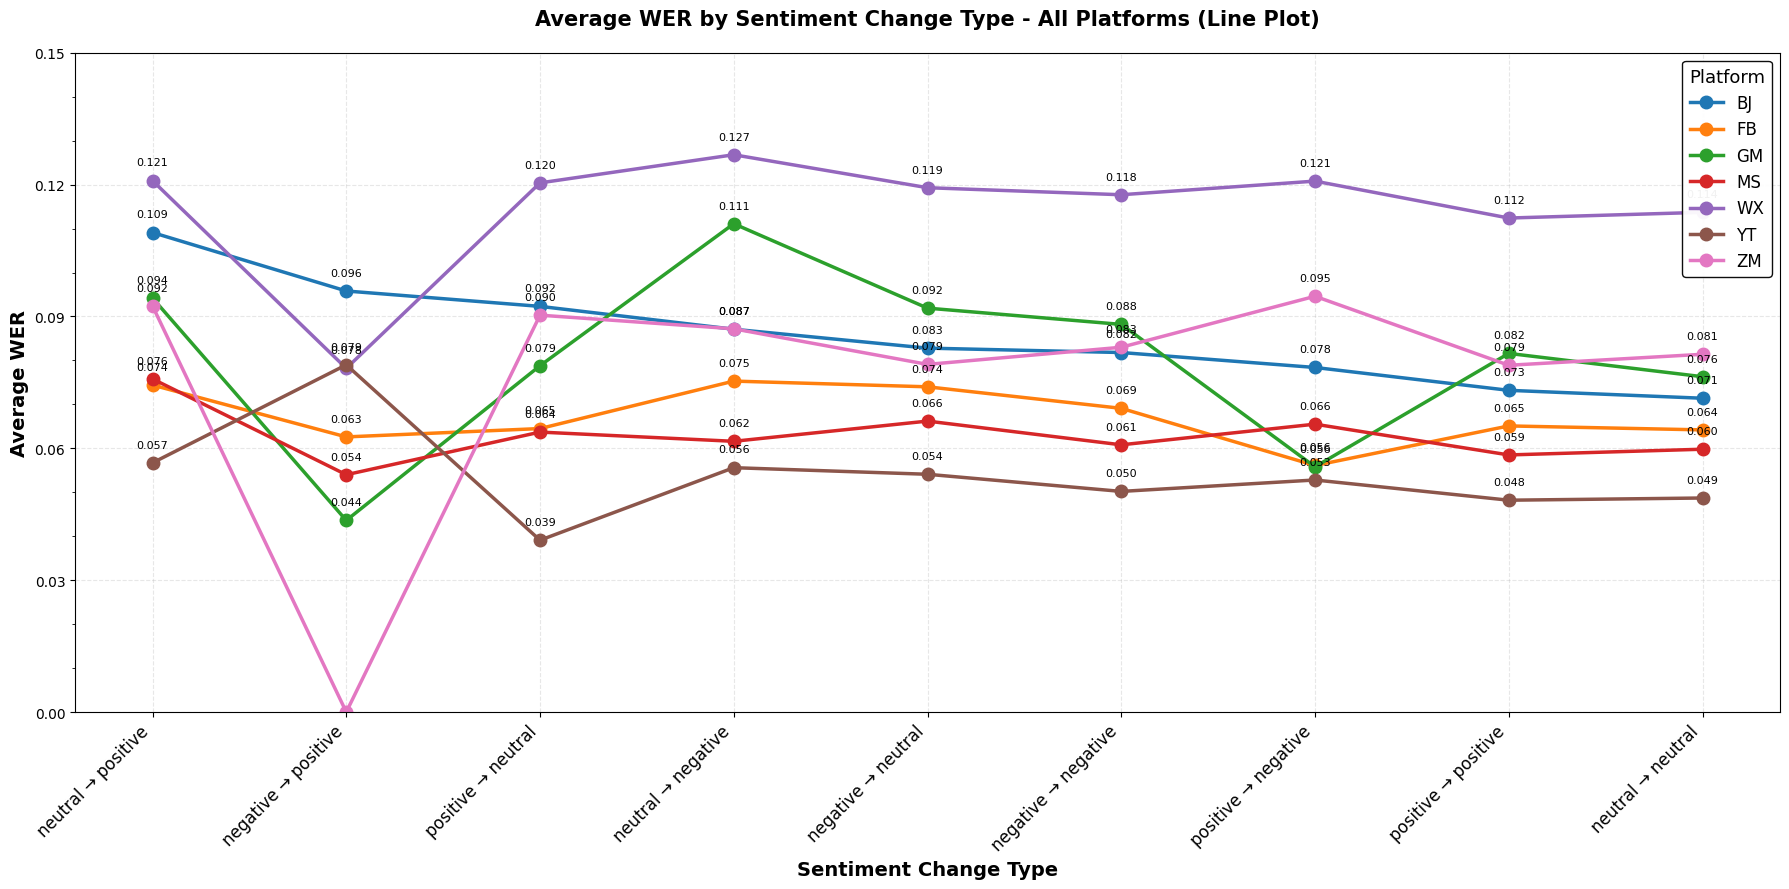


✓ COMBINED VISUALIZATION COMPLETE

Generated plots (saved in Colab local storage):

  1. plots_partB/combined_all_platforms_grouped_bars.pdf
     Grouped bar chart - compare all platforms for each sentiment change

  2. plots_partB/combined_all_platforms_line_plot.pdf
     Line plot - see trends across sentiment changes for each platform

Plot details:
  - Y-axis range: 0 to 0.15 (standardized)
  - Sentiment change types: 9
  - Platforms: 7
  - Color-coded by platform

Copying files to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Copied: plots_partB/combined_all_platforms_grouped_bars.pdf
✓ Copied: plots_partB/combined_all_platforms_line_plot.pdf

✓ All files also saved to Google Drive: /content/drive/My Drive/Analysis/plots_partB/


In [ ]:
# ============================================================================
# COMBINED VISUALIZATION: All Platforms in One Plot
# (CORRECTED: Read from Colab local storage, not Google Drive)
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

print("=" * 80)
print("COMBINED VISUALIZATION: WER by Sentiment Change (All Platforms)")
print("=" * 80)

# Use local Colab path (NOT Google Drive)
csv_path = 'plots_partB/combined_sentiment_change_all_platforms.csv'
print(f"\nLoading combined data from: {csv_path}\n")

# Check if file exists in Colab
if not os.path.exists(csv_path):
    print(f"✗ Error: File not found at {csv_path}")
    print("\nSearching for the file...")

    # List files in plots_partB directory
    if os.path.exists('plots_partB'):
        print(f"✓ Found plots_partB directory")
        files = os.listdir('plots_partB')
        print(f"  Files in plots_partB:")
        for f in files:
            print(f"    - {f}")
    else:
        print("✗ plots_partB directory not found!")
        print("  Please make sure Part B analysis has been completed.")
    raise FileNotFoundError(f"File not found: {csv_path}")

try:
    pivoted_df = pd.read_csv(csv_path)
    print(f"✓ Combined data loaded successfully.")
    print(f"  Total rows (sentiment changes): {len(pivoted_df)}")
    print(f"  Total platforms: 7\n")
except Exception as e:
    print(f"✗ Error loading file: {e}")
    raise

# ============================================================================
# PREPARE DATA FOR COMBINED PLOT
# ============================================================================

print("=" * 80)
print("Preparing data for combined visualization...")
print("=" * 80)

# Extract platforms
platforms = ['BJ', 'FB', 'GM', 'MS', 'WX', 'YT', 'ZM']

# Get sentiment changes
sentiment_changes = pivoted_df['Sentiment_Change'].tolist()

# Create data structure for grouped bar chart
plot_data = []
for _, row in pivoted_df.iterrows():
    sentiment = row['Sentiment_Change']
    for platform in platforms:
        wer_val = row[f'{platform}_WER']
        count_val = row[f'{platform}_Count']

        # Include all rows (even 0 values for visual comparison)
        plot_data.append({
            'Sentiment_Change': sentiment,
            'Platform': platform,
            'WER': wer_val if wer_val != 0 else 0,
            'Count': int(count_val)
        })

plot_df = pd.DataFrame(plot_data)

print(f"\n✓ Data prepared: {len(plot_df)} data points")
print(f"  Sentiment changes: {len(sentiment_changes)}")
print(f"  Platforms: {len(platforms)}")

# ============================================================================
# CREATE GROUPED BAR CHART
# ============================================================================

print("\n" + "=" * 80)
print("Creating combined grouped bar chart...")
print("=" * 80)

fig_height = 9
fig_width = 20

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Prepare x positions for bars
sentiment_idx = np.arange(len(sentiment_changes))
platform_count = len(platforms)
bar_width = 0.12
total_width = bar_width * platform_count

# Define colors for each platform
colors = {
    'BJ': '#1f77b4',  # Blue
    'FB': '#ff7f0e',  # Orange
    'GM': '#2ca02c',  # Green
    'MS': '#d62728',  # Red
    'WX': '#9467bd',  # Purple
    'YT': '#8c564b',  # Brown
    'ZM': '#e377c2'   # Pink
}

# Plot bars for each platform
for idx, platform in enumerate(platforms):
    # Get WER values in order of sentiment_changes
    wer_values = []
    for sentiment in sentiment_changes:
        sentiment_platform = plot_df[(plot_df['Sentiment_Change'] == sentiment) &
                                    (plot_df['Platform'] == platform)]
        if len(sentiment_platform) > 0:
            wer_val = sentiment_platform.iloc[0]['WER']
            wer_values.append(wer_val)
        else:
            wer_values.append(0)

    # Position for this platform
    x_pos = sentiment_idx + (idx - platform_count/2 + 0.5) * bar_width

    # Plot bars
    bars = ax.bar(
        x_pos,
        wer_values,
        bar_width,
        label=platform,
        color=colors[platform],
        edgecolor='black',
        alpha=0.85
    )

    # Add value labels on bars (only non-zero)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0.001:  # Only label non-zero values
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.0015,
                f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=7,
                fontweight='bold'
            )

# Customize plot
ax.set_xlabel('Sentiment Change Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Average WER', fontsize=14, fontweight='bold')
ax.set_title('Average WER by Sentiment Change Type - All Platforms Comparison',
             fontsize=15, fontweight='bold', pad=20)

# Set x-axis
ax.set_xticks(sentiment_idx)
ax.set_xticklabels(sentiment_changes, rotation=45, ha='right', fontsize=12)

# Set y-axis range
ax.set_ylim(0, 0.15)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.03))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))

# Add legend
ax.legend(
    title='Platform',
    loc='upper right',
    fontsize=12,
    title_fontsize=13,
    ncol=1,
    framealpha=0.95,
    edgecolor='black'
)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Adjust layout
plt.tight_layout()

# Save figure (locally in Colab)
output_folder = "plots_partB"
os.makedirs(output_folder, exist_ok=True)

pdf_path = f"{output_folder}/combined_all_platforms_grouped_bars.pdf"
plt.savefig(pdf_path, format="pdf", dpi=300, bbox_inches='tight')
print(f"\n✓ PDF saved to Colab: {pdf_path}")

plt.show()
plt.close()

# ============================================================================
# CREATE ALTERNATIVE: LINE PLOT (ALL PLATFORMS OVERLAY)
# ============================================================================

print("\n" + "=" * 80)
print("Creating alternative: line plot with all platforms overlayed...")
print("=" * 80)

fig, ax = plt.subplots(figsize=(18, 9))

# Plot line for each platform
for platform in platforms:
    # Get WER values in order
    wer_values = []
    for sentiment in sentiment_changes:
        sentiment_platform = plot_df[(plot_df['Sentiment_Change'] == sentiment) &
                                    (plot_df['Platform'] == platform)]
        if len(sentiment_platform) > 0:
            wer_values.append(sentiment_platform.iloc[0]['WER'])
        else:
            wer_values.append(0)

    # Plot line
    x_pos = np.arange(len(sentiment_changes))
    ax.plot(
        x_pos,
        wer_values,
        marker='o',
        linewidth=2.5,
        markersize=9,
        label=platform,
        color=colors[platform]
    )

    # Add value labels (only non-zero)
    for i, val in enumerate(wer_values):
        if val > 0.001:
            ax.text(i, val + 0.003, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# Customize plot
ax.set_xlabel('Sentiment Change Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Average WER', fontsize=14, fontweight='bold')
ax.set_title('Average WER by Sentiment Change Type - All Platforms (Line Plot)',
             fontsize=15, fontweight='bold', pad=20)

# Set x-axis
ax.set_xticks(np.arange(len(sentiment_changes)))
ax.set_xticklabels(sentiment_changes, rotation=45, ha='right', fontsize=12)

# Set y-axis range
ax.set_ylim(0, 0.15)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.03))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))

# Add legend
ax.legend(
    title='Platform',
    loc='upper right',
    fontsize=12,
    title_fontsize=13,
    ncol=1,
    framealpha=0.95,
    edgecolor='black'
)

# Add grid
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Adjust layout
plt.tight_layout()

# Save figure
pdf_path_line = f"{output_folder}/combined_all_platforms_line_plot.pdf"
plt.savefig(pdf_path_line, format="pdf", dpi=300, bbox_inches='tight')
print(f"✓ PDF saved to Colab: {pdf_path_line}")

plt.show()
plt.close()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("✓ COMBINED VISUALIZATION COMPLETE")
print("=" * 80)
print(f"\nGenerated plots (saved in Colab local storage):")
print(f"\n  1. {pdf_path}")
print(f"     Grouped bar chart - compare all platforms for each sentiment change")
print(f"\n  2. {pdf_path_line}")
print(f"     Line plot - see trends across sentiment changes for each platform")
print(f"\nPlot details:")
print(f"  - Y-axis range: 0 to 0.15 (standardized)")
print(f"  - Sentiment change types: {len(sentiment_changes)}")
print(f"  - Platforms: {len(platforms)}")
print(f"  - Color-coded by platform")
print("=" * 80)


## C: Sentiment Disagreement & WER


FINDING C: SENTIMENT DISAGREEMENT & WER ANALYSIS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loading data from: /content/drive/My Drive/Analysis/labels_sentiment_with_shifts.csv
✓ DataFrame loaded successfully.
  Total rows: 846
  Total columns: 50

✓ Output folder: plots_findingC/

SETUP: Auto-detecting column names

✓ Auto-detected platforms from WER columns:
  BJ, FB, GM, MS, WX, YT, ZM

✓ Column detection summary:
  Sentiment columns: 8 found
  Label columns: 8 found
  WER columns: 7 found
  Shift columns: 7 found

✓ All required column types found.

1. SENTIMENT CORRELATION HEATMAP

Creating correlation matrix from 8 sentiment columns...


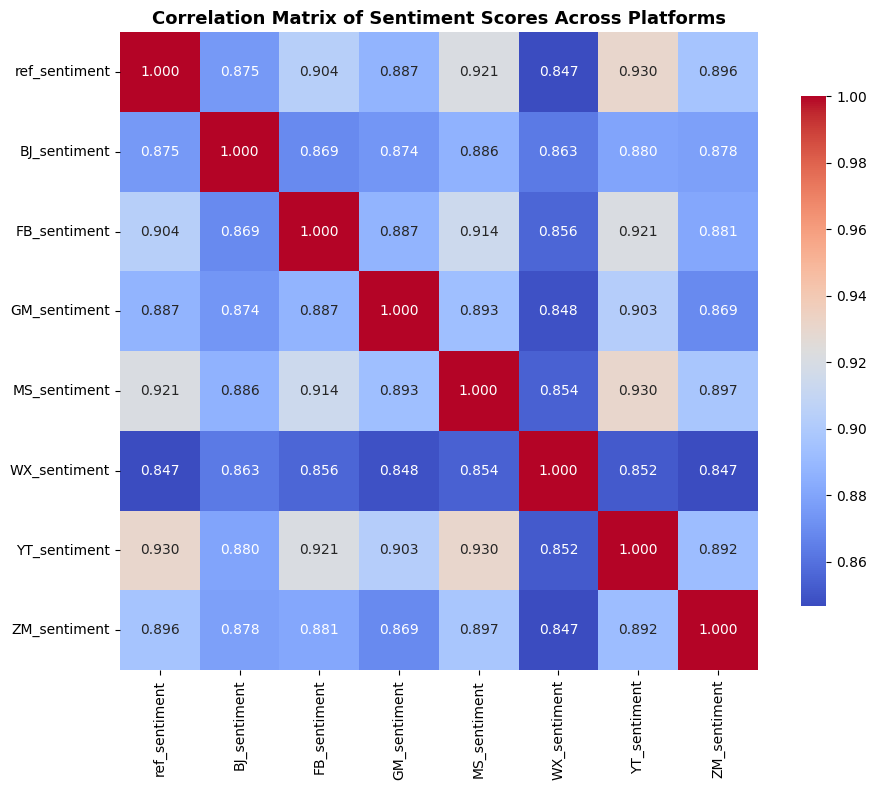

✓ Saved: plots_findingC/sentiment_correlation_heatmap.pdf

2. SENTIMENT AGREEMENT vs DISAGREEMENT

Analyzing disagreement across 8 platforms...

--- Sentiment Agreement Statistics ---
Agreement (all platforms same):      537 rows (63.48%)
Disagreement (platforms differ):    309 rows (36.52%)

3. AVERAGE WER WITH/WITHOUT DISAGREEMENT

Comparing WER across all platforms grouped by agreement:

Agreement Status          |     BJ_WER |     FB_WER |     GM_WER |     MS_WER |     WX_WER |     YT_WER |     ZM_WER
-------------------------------------------------------------------------------------------------------------------
No Disagreement           | 0.0793 | 0.0680 | 0.0858 | 0.0598 | 0.1148 | 0.0494 | 0.0811
Has Disagreement          | 0.0838 | 0.0694 | 0.0890 | 0.0631 | 0.1220 | 0.0515 | 0.0858

✓ Saved: plots_findingC/wer_by_agreement.csv

4. OVERALL SENTIMENT SHIFT RATES BY PLATFORM (%)

Calculating shift rates across all 7 platforms...

--- Shift Rate per Platform ---
Platform     | 

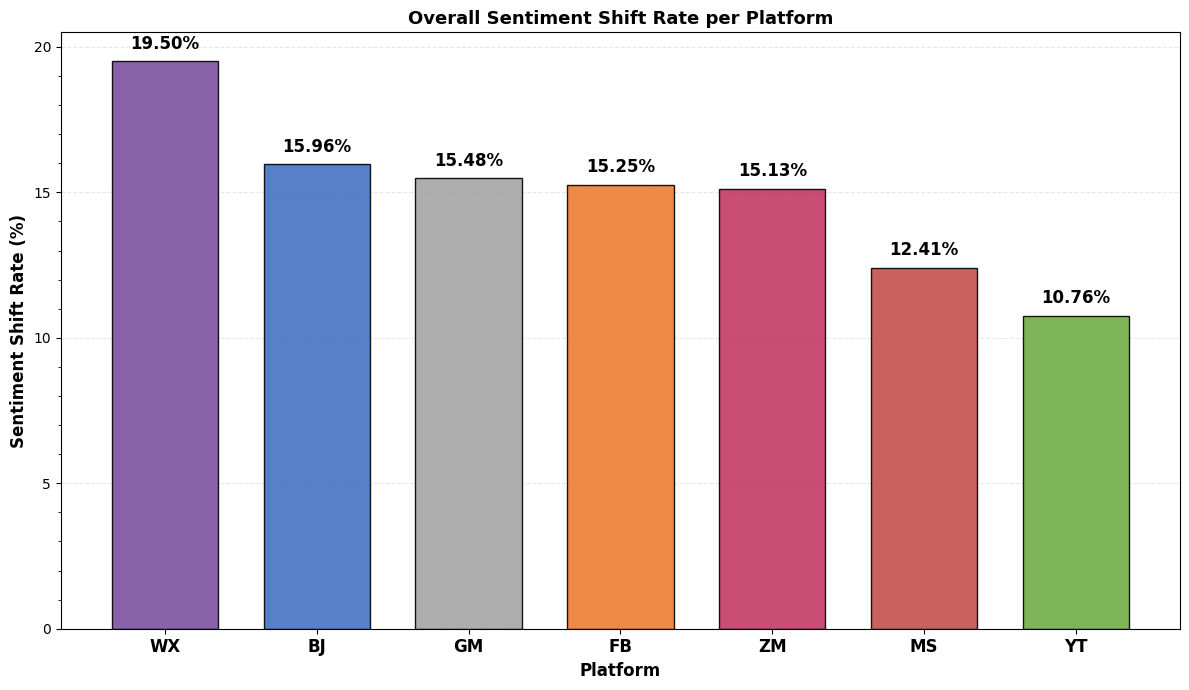

✓ Saved: plots_findingC/shift_rate_by_platform.pdf

5. DISAGREEMENT vs WER (BOXPLOT FOR EACH PLATFORM)

Creating boxplots for all 7 platforms...


/tmp/ipython-input-1697596227.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([df[df["had_disagreement"] == False][wer_col].dropna(),
/tmp/ipython-input-1697596227.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([df[df["had_disagreement"] == False][wer_col].dropna(),
/tmp/ipython-input-1697596227.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([df[df["had_disagreement"] == False][wer_col].dropna(),
/tmp/ipython-input-1697596227.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; 

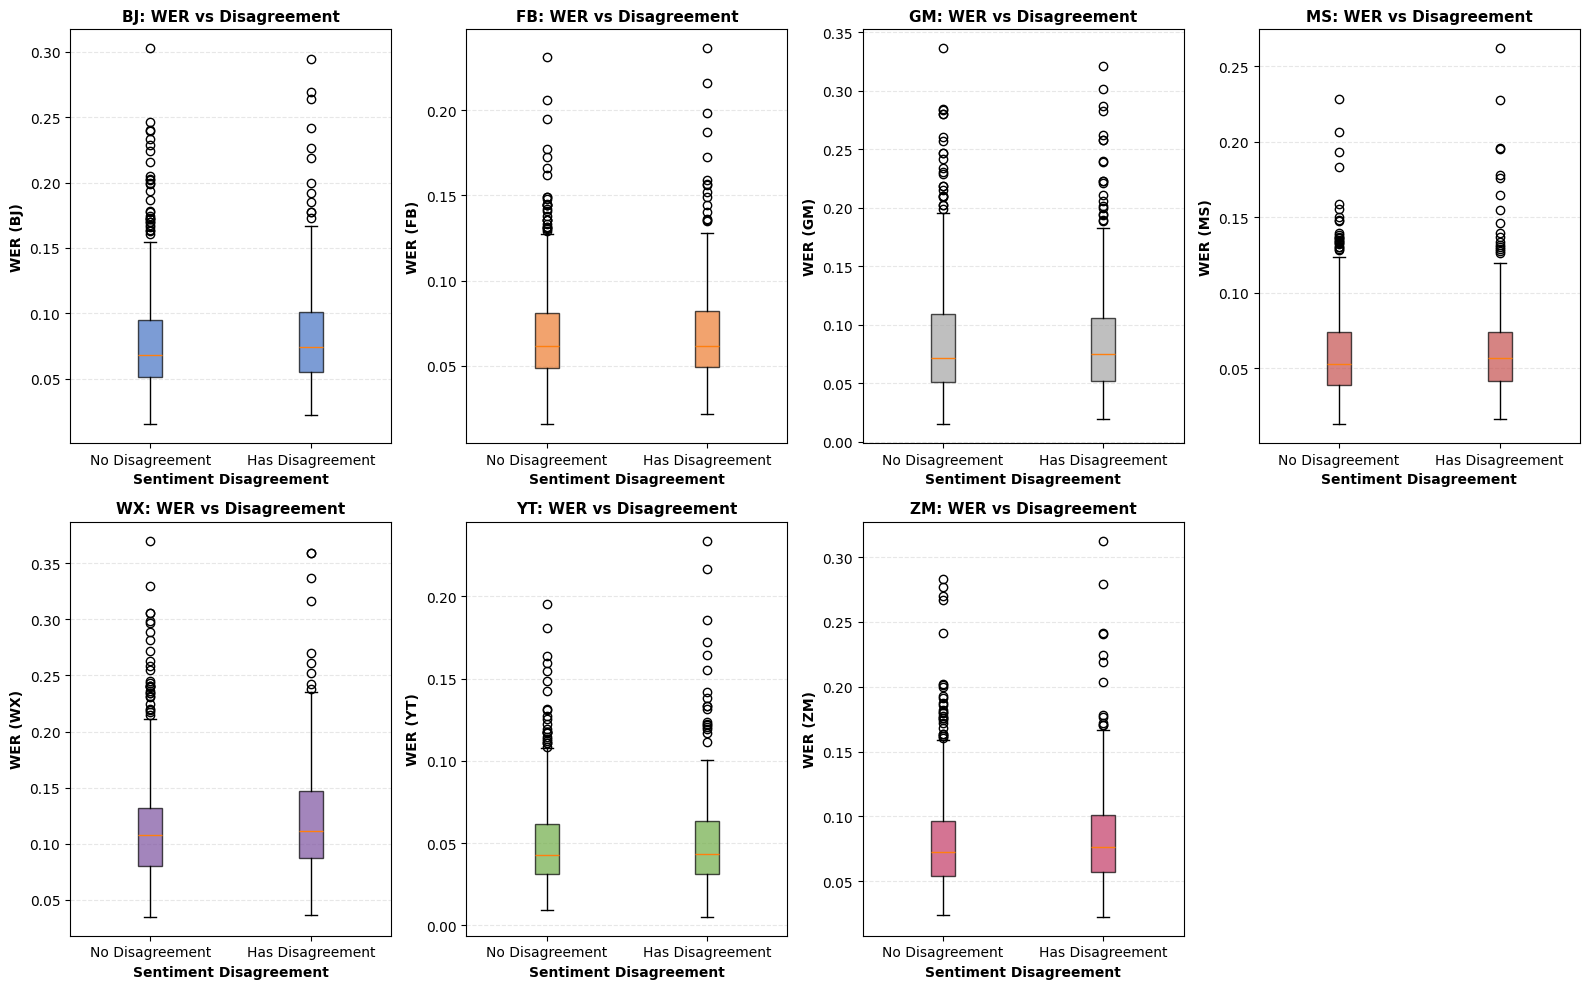

✓ Saved: plots_findingC/disagreement_vs_wer_boxplot_all.pdf

✓ FINDING C ANALYSIS COMPLETE

Generated outputs:
  1. plots_findingC/sentiment_correlation_heatmap.pdf
  2. plots_findingC/wer_by_agreement.csv
  3. plots_findingC/shift_rate_by_platform.csv
  4. plots_findingC/shift_rate_by_platform.pdf (Y-axis: 0-20.5, Custom Colors)
  5. plots_findingC/disagreement_vs_wer_boxplot_all.pdf (Custom Colors)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import numpy as np

# ============================================
# FINDING C – Sentiment Disagreement & WER
# ============================================

print("\n" + "=" * 70)
print("FINDING C: SENTIMENT DISAGREEMENT & WER ANALYSIS")
print("=" * 70)

# Mount Google Drive
drive.mount('/content/drive')

# Load the data with shifts
csv_to_load = '/content/drive/My Drive/Analysis/labels_sentiment_with_shifts.csv'
print(f"\nLoading data from: {csv_to_load}")

try:
    df = pd.read_csv(csv_to_load)
    print(f"✓ DataFrame loaded successfully.")
    print(f"  Total rows: {len(df)}")
    print(f"  Total columns: {len(df.columns)}\n")
except Exception as e:
    print(f"✗ Error loading file: {e}")
    raise

# Output folder
output_plot_folder = "plots_findingC"
os.makedirs(output_plot_folder, exist_ok=True)
print(f"✓ Output folder: {output_plot_folder}/\n")

# ================================
# DEFINE CUSTOM COLORS
# ================================
platform_colors = {
    'BJ': '#4472C4',   # Blue
    'FB': '#ED7D31',   # Orange
    'GM': '#A5A5A5',   # Gray
    'MS': '#C5504E',   # Red
    'WX': '#7C51A0',   # Purple
    'YT': '#70AD47',   # Green
    'ZM': '#C33965'    # Pink/Magenta
}

# ============================================
# SETUP: Auto-detect correct column names
# ============================================

print("=" * 70)
print("SETUP: Auto-detecting column names")
print("=" * 70)

# Detect platforms from WER columns
wer_columns = [col for col in df.columns if col.endswith('_WER')]
platforms = sorted([col.replace('_WER', '') for col in wer_columns])

print(f"\n✓ Auto-detected platforms from WER columns:")
print(f"  {', '.join(platforms)}")

# Define column lists based on actual column names
ref_sentiment_col = 'ref_sentiment'
ref_label_col = 'label'

sentiment_cols = [ref_sentiment_col] + [f"{p}_sentiment" for p in platforms
                                         if f"{p}_sentiment" in df.columns]
label_cols = [ref_label_col] + [f"{p}_label" for p in platforms
                                 if f"{p}_label" in df.columns]
wer_cols = [f"{p}_WER" for p in platforms if f"{p}_WER" in df.columns]
shift_cols = [f"{p}_shift" for p in platforms if f"{p}_shift" in df.columns]

print(f"\n✓ Column detection summary:")
print(f"  Sentiment columns: {len(sentiment_cols)} found")
print(f"  Label columns: {len(label_cols)} found")
print(f"  WER columns: {len(wer_cols)} found")
print(f"  Shift columns: {len(shift_cols)} found")

# Check that we have columns to work with
if not platforms or not sentiment_cols or not label_cols or not wer_cols or not shift_cols:
    print("\n✗ Error: Missing one or more critical column types.")
    print("Please check your 'labels_sentiment_with_shifts.csv' file.")
    raise KeyError("Missing critical columns")
else:
    print("\n✓ All required column types found.\n")

# ============================================
# 1. SENTIMENT CORRELATION HEATMAP
# ============================================

print("=" * 70)
print("1. SENTIMENT CORRELATION HEATMAP")
print("=" * 70)

if len(sentiment_cols) > 1:
    print(f"\nCreating correlation matrix from {len(sentiment_cols)} sentiment columns...")

    corr_matrix = df[sentiment_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm",
                square=True, cbar_kws={"shrink": 0.8})
    plt.title("Correlation Matrix of Sentiment Scores Across Platforms", fontsize=13, fontweight='bold')
    plt.tight_layout()

    pdf_path = f"{output_plot_folder}/sentiment_correlation_heatmap.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_path}")
else:
    print("⚠ Skipping heatmap: Not enough sentiment columns found.")

# ============================================
# 2. SENTIMENT AGREEMENT / DISAGREEMENT
# ============================================

print("\n" + "=" * 70)
print("2. SENTIMENT AGREEMENT vs DISAGREEMENT")
print("=" * 70)

if len(label_cols) < 2:
    print("⚠ Skipping disagreement analysis: Need at least 2 platform labels to compare.")
else:
    print(f"\nAnalyzing disagreement across {len(label_cols)} platforms...")

    # Count unique sentiments per row across all platforms
    df["sentiment_uniqueness"] = df[label_cols].nunique(axis=1)
    df["had_disagreement"] = df["sentiment_uniqueness"] > 1

    agreement_stats = df["had_disagreement"].value_counts()
    agreement_pct = df["had_disagreement"].value_counts(normalize=True) * 100

    print(f"\n--- Sentiment Agreement Statistics ---")
    print(f"Agreement (all platforms same):   {agreement_stats[False]:6} rows ({agreement_pct[False]:5.2f}%)")
    print(f"Disagreement (platforms differ): {agreement_stats[True]:6} rows ({agreement_pct[True]:5.2f}%)")

    # ============================================
    # 3. AVERAGE WER WITH/WITHOUT DISAGREEMENT
    # ============================================

    print("\n" + "=" * 70)
    print("3. AVERAGE WER WITH/WITHOUT DISAGREEMENT")
    print("=" * 70)

    print(f"\nComparing WER across all platforms grouped by agreement:")
    print(f"\n{'Agreement Status':<25} | {'BJ_WER':>10} | {'FB_WER':>10} | {'GM_WER':>10} | {'MS_WER':>10} | {'WX_WER':>10} | {'YT_WER':>10} | {'ZM_WER':>10}")
    print("-" * 115)

    wer_by_agreement = df.groupby("had_disagreement")[wer_cols].mean()

    for idx, (agreement, row) in enumerate(wer_by_agreement.iterrows()):
        agreement_str = "No Disagreement" if not agreement else "Has Disagreement"
        wer_vals = " | ".join([f"{val:.4f}" for val in row.values])
        print(f"{agreement_str:<25} | {wer_vals}")

    # Save to CSV
    wer_csv_path = f"{output_plot_folder}/wer_by_agreement.csv"
    wer_by_agreement.to_csv(wer_csv_path)
    print(f"\n✓ Saved: {wer_csv_path}")

# ============================================
# 4. OVERALL SENTIMENT SHIFT RATE (Platform-wise)
# ============================================

print("\n" + "=" * 70)
print("4. OVERALL SENTIMENT SHIFT RATES BY PLATFORM (%)")
print("=" * 70)

if not shift_cols:
    print("⚠ Skipping shift rate analysis: No '_shift' columns found.")
else:
    print(f"\nCalculating shift rates across all {len(shift_cols)} platforms...")

    shift_rates = (df[shift_cols].mean() * 100).reset_index()
    shift_rates.columns = ["Column", "Shift_Rate_Percent"]
    shift_rates['Platform'] = shift_rates['Column'].str.replace('_shift', '')
    shift_rates = shift_rates[['Platform', 'Shift_Rate_Percent']].sort_values('Shift_Rate_Percent', ascending=False)

    print(f"\n--- Shift Rate per Platform ---")
    print(f"{'Platform':<12} | {'Shift Rate (%)':<15}")
    print("-" * 30)
    for _, row in shift_rates.iterrows():
        print(f"{row['Platform']:<12} | {row['Shift_Rate_Percent']:>6.2f}%")

    # Save to CSV
    shift_csv_path = f"{output_plot_folder}/shift_rate_by_platform.csv"
    shift_rates.to_csv(shift_csv_path, index=False)
    print(f"\n✓ Saved: {shift_csv_path}")

    # ============================================
    # 5. PLOT: SHIFT RATE PER PLATFORM (CORRECTED)
    # ============================================

    print(f"\nCreating bar plot with custom colors and Y-axis range 0-20.5...")

    fig, ax = plt.subplots(figsize=(12, 7))

    # Create bars with custom colors for each platform
    bars = []
    for idx, (platform, rate) in enumerate(zip(shift_rates['Platform'], shift_rates['Shift_Rate_Percent'])):
        bar = ax.bar(idx, rate, color=platform_colors[platform],
                    edgecolor='black', alpha=0.90, width=0.7)
        bars.append(bar)

    # Add value labels on bars
    for idx, (bar, rate) in enumerate(zip(bars, shift_rates['Shift_Rate_Percent'])):
        ax.text(idx, rate + 0.3, f'{rate:.2f}%',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Set X-axis
    ax.set_xticks(range(len(shift_rates)))
    ax.set_xticklabels(shift_rates['Platform'], fontsize=12, fontweight='bold')

    # Set Y-axis: 0 to 20.5
    ax.set_ylim(0, 20.5)
    ax.set_ylabel("Sentiment Shift Rate (%)", fontsize=12, fontweight='bold')
    ax.set_xlabel("Platform", fontsize=12, fontweight='bold')
    ax.set_title("Overall Sentiment Shift Rate per Platform", fontsize=13, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)

    # Add grid lines at 5% intervals
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))

    plt.tight_layout()

    pdf_path = f"{output_plot_folder}/shift_rate_by_platform.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_path}")

# ============================================
# 6. DISAGREEMENT vs WER (Boxplot)
# ============================================

print("\n" + "=" * 70)
print("5. DISAGREEMENT vs WER (BOXPLOT FOR EACH PLATFORM)")
print("=" * 70)

if 'had_disagreement' in df.columns and len(platforms) > 0:
    print(f"\nCreating boxplots for all {len(platforms)} platforms...")

    # Create subplots for each platform
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))
    axes = axes.flatten()

    for idx, platform in enumerate(platforms):
        wer_col = f"{platform}_WER"

        if wer_col in df.columns:
            ax = axes[idx]

            # Create boxplot
            bp = ax.boxplot([df[df["had_disagreement"] == False][wer_col].dropna(),
                            df[df["had_disagreement"] == True][wer_col].dropna()],
                           labels=['No Disagreement', 'Has Disagreement'],
                           patch_artist=True)

            # Color the boxes with platform color
            for patch in bp['boxes']:
                patch.set_facecolor(platform_colors[platform])
                patch.set_alpha(0.70)

            ax.set_xlabel("Sentiment Disagreement", fontsize=10, fontweight='bold')
            ax.set_ylabel(f"WER ({platform})", fontsize=10, fontweight='bold')
            ax.set_title(f"{platform}: WER vs Disagreement", fontsize=11, fontweight='bold')
            ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Hide unused subplots
    for idx in range(len(platforms), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()

    pdf_path = f"{output_plot_folder}/disagreement_vs_wer_boxplot_all.pdf"
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_path}")
else:
    print("⚠ Skipping disagreement vs. WER plot.")

# ============================================
# SUMMARY
# ============================================

print("\n" + "=" * 70)
print("✓ FINDING C ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nGenerated outputs:")
print(f"  1. {output_plot_folder}/sentiment_correlation_heatmap.pdf")
print(f"  2. {output_plot_folder}/wer_by_agreement.csv")
print(f"  3. {output_plot_folder}/shift_rate_by_platform.csv")
print(f"  4. {output_plot_folder}/shift_rate_by_platform.pdf (Y-axis: 0-20.5, Custom Colors)")
print(f"  5. {output_plot_folder}/disagreement_vs_wer_boxplot_all.pdf (Custom Colors)")
print("=" * 70)


# ANALYSIS 2: Demographic Bias

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

# ================================
# SETUP: Load Data
# ================================
drive.mount('/content/drive', force_remount=True)

shifts_file = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'
output_folder = "demographic_impact_analysis"
os.makedirs(output_folder, exist_ok=True)

print("=" * 80)
print("DEMOGRAPHIC BIAS TABLE: SENTIMENT IMPACT & VULNERABILITY")
print("=" * 80)

try:
    df = pd.read_csv(shifts_file)
    print(f"\n✓ File loaded successfully.")
    print(f"  Rows: {len(df)}")
    print(f"  Columns: {len(df.columns)}\n")
except Exception as e:
    print(f"❌ ERROR: {e}")
    raise

# ================================
# AUTO-DETECT COLUMNS
# ================================
# Detect platforms
shift_cols = sorted([col for col in df.columns if col.endswith('_shift')])
platforms = [col.replace('_shift', '') for col in shift_cols]

# Demographics
demographics = ['gender', 'race', 'language', 'wps_category']
available_demographics = [d for d in demographics if d in df.columns]

print(f"✓ Platforms: {', '.join(platforms)}")
print(f"✓ Demographics: {', '.join(available_demographics)}")

# ================================
# SENTIMENT IMPACT & VULNERABILITY
# ================================
print("\n" + "=" * 80)
print("SENTIMENT SHIFT ANALYSIS BY DEMOGRAPHIC GROUP")
print("=" * 80)

results = []

for demo in available_demographics:
    print(f"\n{'─' * 80}")
    print(f"DEMOGRAPHIC: {demo.upper()}")
    print(f"{'─' * 80}\n")

    demo_groups = sorted([v for v in df[demo].dropna().unique() if pd.notna(v)])

    for group in demo_groups:
        group_data = df[df[demo] == group]
        group_name = str(group)

        # Calculate sentiment shift rates for each platform
        platform_shifts = {}
        overall_shifts = []

        for platform in platforms:
            shift_col = f"{platform}_shift"
            if shift_col in df.columns:
                shift_rate = (group_data[shift_col].mean() * 100)
                platform_shifts[platform] = shift_rate
                overall_shifts.append(shift_rate)

        # Calculate metrics
        if overall_shifts:
            avg_shift = np.mean(overall_shifts)
            max_shift = np.max(overall_shifts)
            min_shift = np.min(overall_shifts)
            variation = max_shift - min_shift

            # Determine vulnerability level
            if avg_shift < 10:
                vulnerability = "Low"
            elif avg_shift < 15:
                vulnerability = "Medium"
            else:
                vulnerability = "High"

            # Create sentiment impact description
            high_platform = max(platform_shifts, key=platform_shifts.get)
            low_platform = min(platform_shifts, key=platform_shifts.get)

            impact_desc = f"Shift rates: {low_platform} {platform_shifts[low_platform]:.1f}% to {high_platform} {platform_shifts[high_platform]:.1f}%"

            print(f"{group_name}:")
            print(f"  Average Sentiment Shift: {avg_shift:.2f}%")
            print(f"  Range: {min_shift:.1f}% - {max_shift:.1f}%")
            print(f"  Impact: {impact_desc}")
            print(f"  Vulnerability: {vulnerability}\n")

            results.append({
                'Demographic_Group': demo,
                'Group_Value': group_name,
                'Avg_Sentiment_Shift_%': round(avg_shift, 2),
                'Min_Shift_%': round(min_shift, 2),
                'Max_Shift_%': round(max_shift, 2),
                'Shift_Variation': round(variation, 2),
                'Sentiment_Impact': impact_desc,
                'Sentiment_Vulnerability': vulnerability
            })

# ================================
# CREATE OUTPUT TABLE
# ================================
if results:
    results_df = pd.DataFrame(results)

    print("\n" + "=" * 80)
    print("DEMOGRAPHIC IMPACT TABLE (FOR YOUR SUMMARY)")
    print("=" * 80)
    print()

    # Create a cleaner table for visualization
    for demo in available_demographics:
        demo_data = results_df[results_df['Demographic_Group'] == demo]

        print(f"\n{demo.upper()}")
        print("─" * 80)

        for _, row in demo_data.iterrows():
            print(f"\nGroup: {row['Group_Value']}")
            print(f"  Sentiment Impact: {row['Sentiment_Impact']}")
            print(f"  Sentiment Vulnerability: {row['Sentiment_Vulnerability']}")

    # Save to CSV
    csv_path = f"{output_folder}/sentiment_demographic_impact.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\n\n✓ Full results saved to: {csv_path}")

    # Create formatted table for easy copy-paste
    print("\n" + "=" * 80)
    print("FORMATTED TABLE (Copy-paste ready)")
    print("=" * 80)

    formatted_rows = []
    for demo in available_demographics:
        demo_data = results_df[results_df['Demographic_Group'] == demo]
        for _, row in demo_data.iterrows():
            formatted_rows.append({
                'Demographic Group': row['Group_Value'],
                'Sentiment Impact': row['Sentiment_Impact'],
                'Sentiment Vulnerability': row['Sentiment_Vulnerability']
            })

    formatted_df = pd.DataFrame(formatted_rows)
    print("\n" + formatted_df.to_string(index=False))

    # Save formatted table
    formatted_path = f"{output_folder}/demographic_bias_table_formatted.csv"
    formatted_df.to_csv(formatted_path, index=False)
    print(f"\n✓ Formatted table saved to: {formatted_path}")

print("\n" + "=" * 80)
print("✓ ANALYSIS COMPLETE")
print("=" * 80)


Mounted at /content/drive
DEMOGRAPHIC BIAS TABLE: SENTIMENT IMPACT & VULNERABILITY

✓ File loaded successfully.
  Rows: 846
  Columns: 50

✓ Platforms: BJ, FB, GM, MS, WX, YT, ZM
✓ Demographics: gender, race, language, wps_category

SENTIMENT SHIFT ANALYSIS BY DEMOGRAPHIC GROUP

────────────────────────────────────────────────────────────────────────────────
DEMOGRAPHIC: GENDER
────────────────────────────────────────────────────────────────────────────────

female:
  Average Sentiment Shift: 15.72%
  Range: 10.7% - 20.8%
  Impact: Shift rates: YT 10.7% to WX 20.8%
  Vulnerability: High

male:
  Average Sentiment Shift: 14.49%
  Range: 10.8% - 18.8%
  Impact: Shift rates: YT 10.8% to WX 18.8%
  Vulnerability: Medium


────────────────────────────────────────────────────────────────────────────────
DEMOGRAPHIC: RACE
────────────────────────────────────────────────────────────────────────────────

asian:
  Average Sentiment Shift: 20.60%
  Range: 14.4% - 24.0%
  Impact: Shift rates: YT 1

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

DEMOGRAPHIC BIAS PLOTS: CONFERENCE READY (DISPLAY ENABLED)

✓ File loaded successfully.
  Rows: 846
  Columns: 50

Generating Plot 1: Grouped Bars (Multi-Page PDF)...
✓ Saved: plots_demographic_sentiment/01_grouped_bars_sentiment_shift.pdf
Generating Plot 2: Heatmaps...


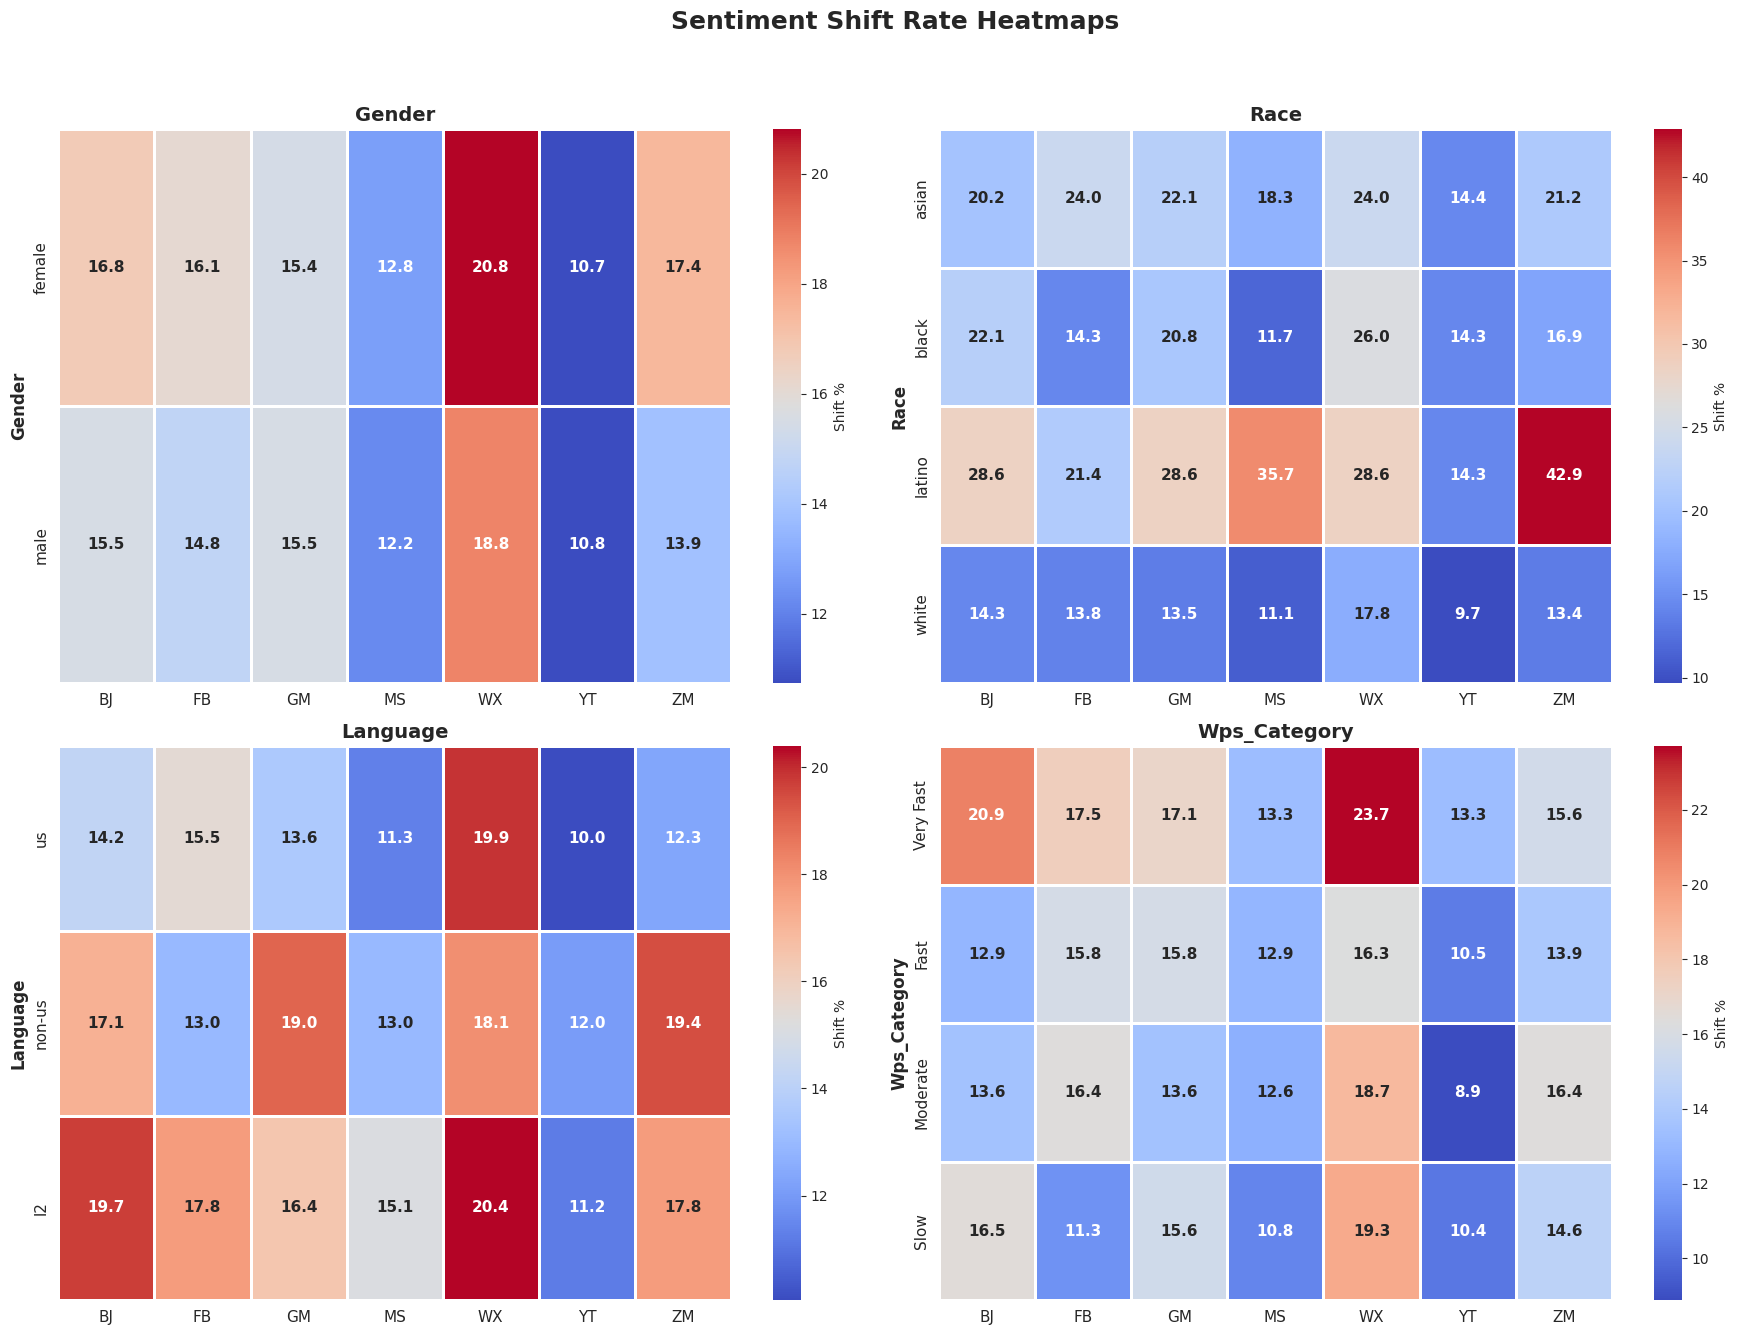

✓ Saved: plots_demographic_sentiment/02_heatmaps_sentiment_shift.pdf
Generating Plot 3: Violin Plots...


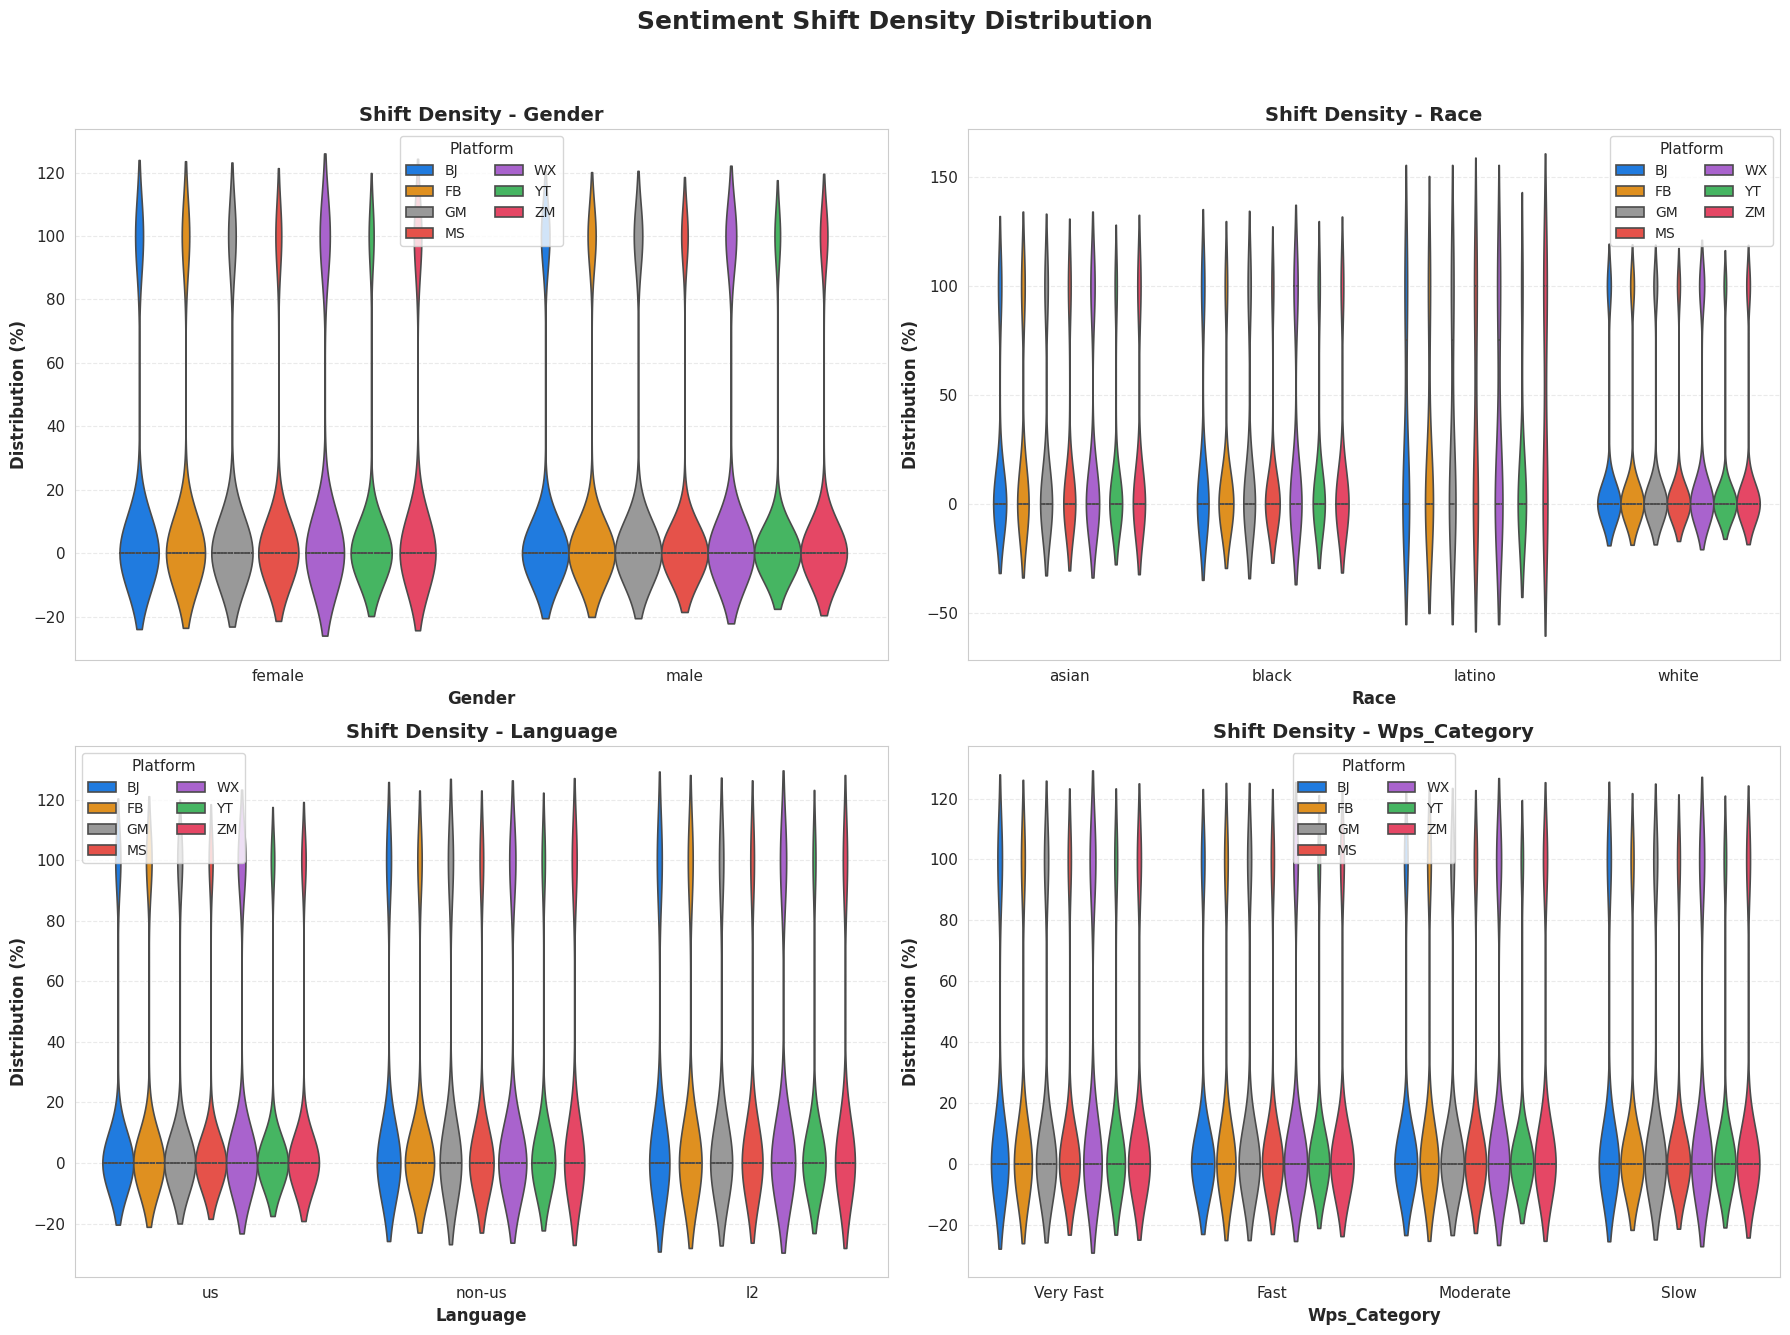

✓ Saved: plots_demographic_sentiment/03_violinplots_sentiment_shift.pdf
Generating Plot 4: Trend Lines...


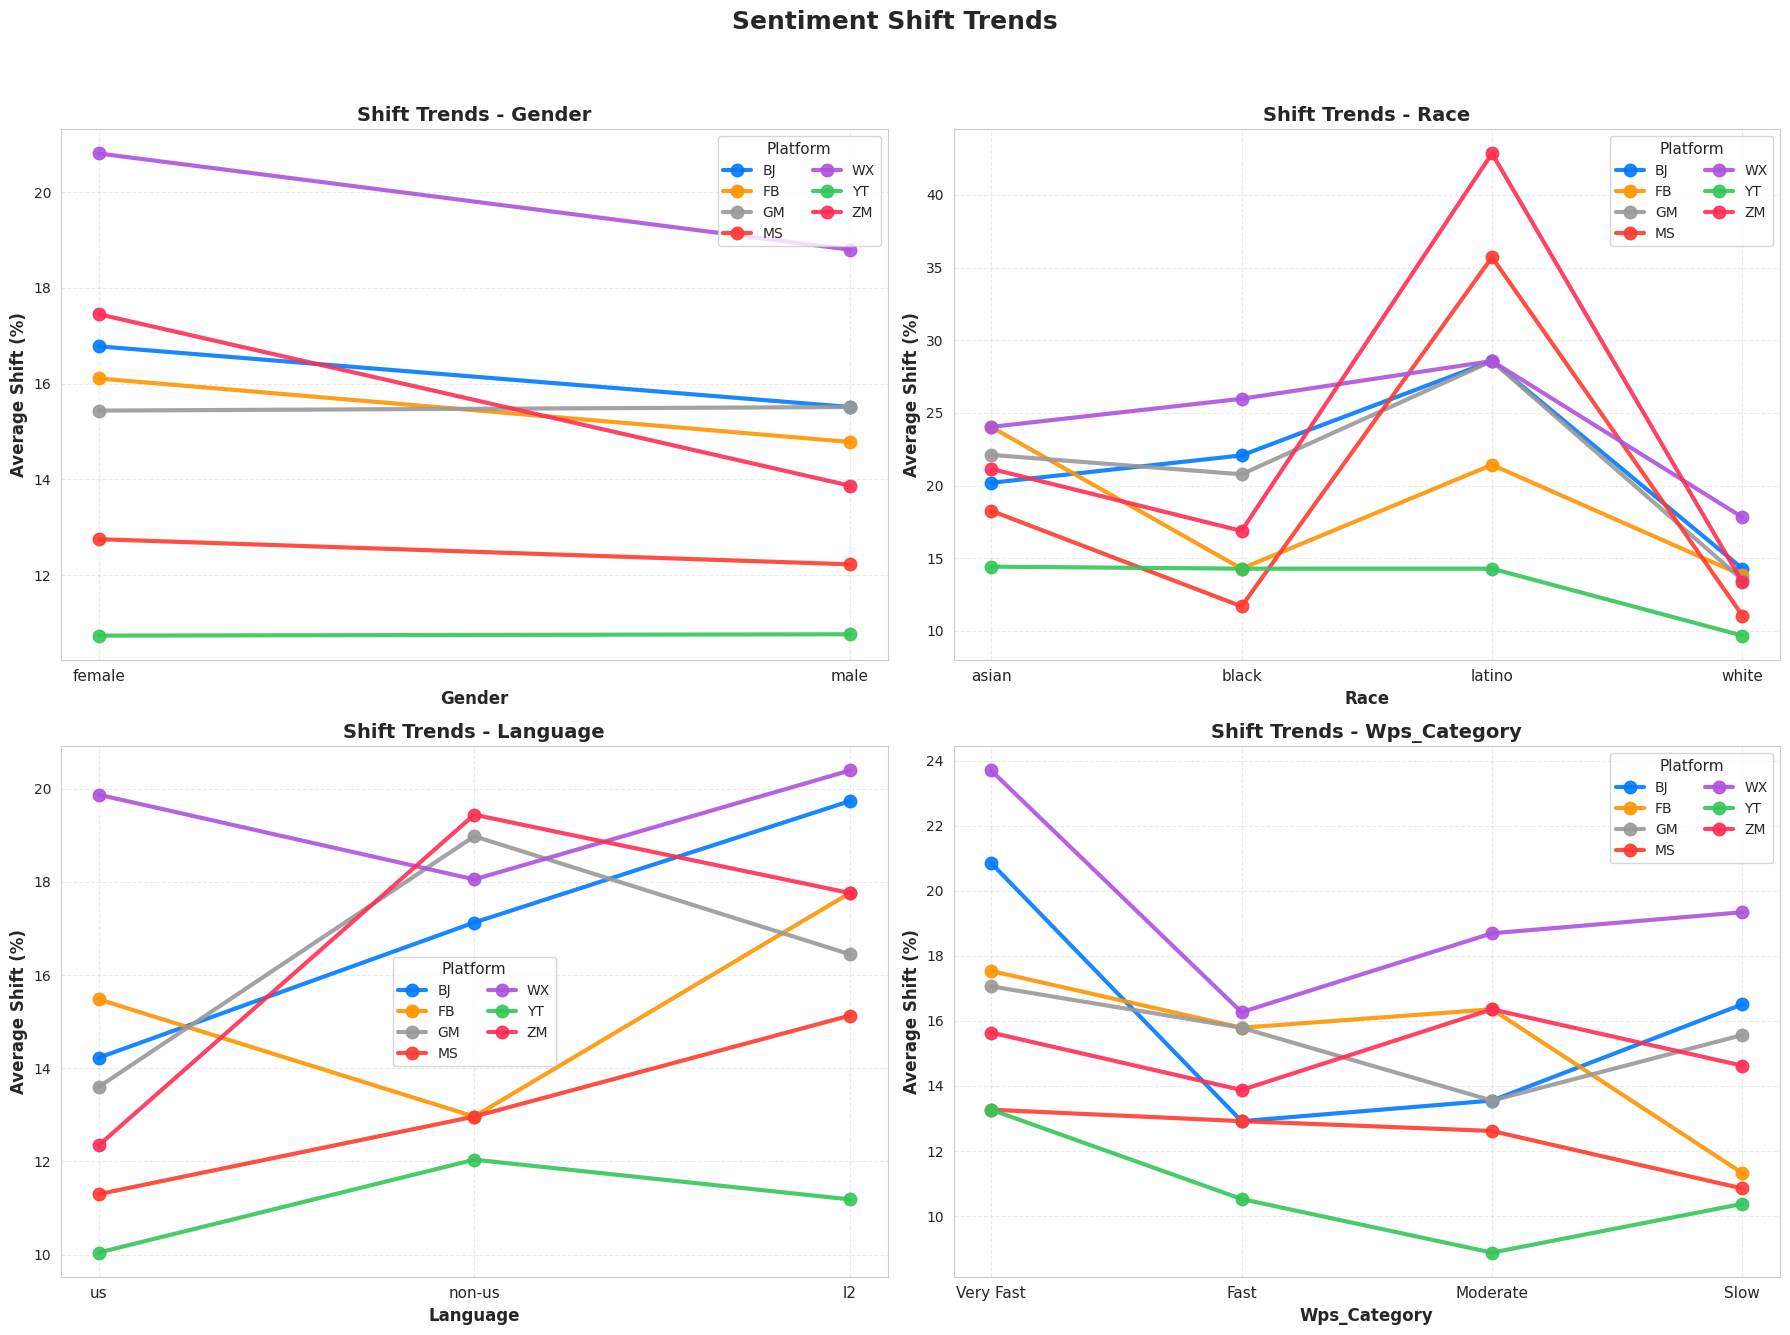

✓ Saved: plots_demographic_sentiment/04_lineplots_sentiment_shift.pdf

✓ GENERATION COMPLETE. PLOTS SAVED TO 'plots_demographic_sentiment/'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ================================
# SETUP: Load Data
# ================================
# drive.mount('/content/drive', force_remount=True) # Uncomment if needed

shifts_file = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'
output_folder = "plots_demographic_sentiment"
os.makedirs(output_folder, exist_ok=True)

# Use a clean style for research papers
sns.set_style("whitegrid")
plt.rcParams.update({'font.family': 'sans-serif'})

print("=" * 80)
print("DEMOGRAPHIC BIAS PLOTS: CONFERENCE READY (DISPLAY ENABLED)")
print("=" * 80)

try:
    if not os.path.exists(shifts_file):
        raise FileNotFoundError(f"Critical Error: Input file not found at {shifts_file}")

    df = pd.read_csv(shifts_file)
    print(f"\n✓ File loaded successfully.")
    print(f"  Rows: {len(df)}")
    print(f"  Columns: {len(df.columns)}\n")
except Exception as e:
    print(f"❌ CRITICAL ERROR: {e}")
    raise  # Stop execution immediately if data is missing

# ================================
# DEFINITIONS: COLORS & ORDER
# ================================
# High-contrast/Bright palette for publication clarity
platform_colors = {
    'BJ': '#007AFF',   # Bright Blue
    'FB': '#FF9500',   # Bright Orange
    'GM': '#999999',   # Neutral Gray
    'MS': '#FF3B30',   # Bright Red
    'WX': '#AF52DE',   # Bright Purple
    'YT': '#34C759',   # Bright Green
    'ZM': '#FF2D55'    # Bright Pink
}

shift_cols = sorted([col for col in df.columns if col.endswith('_shift')])
platforms = [col.replace('_shift', '') for col in shift_cols]

demographics = ['gender', 'race', 'language', 'wps_category']
available_demographics = [d for d in demographics if d in df.columns]

# ================================
# HELPER: SORTING STRATEGY
# ================================
def get_sorted_groups(demo_name, unique_values):
    """Returns a list of groups sorted by specific research criteria."""
    cleaned_vals = [v for v in unique_values if pd.notna(v)]

    if demo_name == 'language':
        # Research Order: Native -> Non-Native -> L2
        order = ['us', 'non-us', 'l2']
        return [x for x in order if x in cleaned_vals] + sorted([x for x in cleaned_vals if x not in order])

    elif demo_name == 'wps_category':
        # logical speed order
        order = ['Very Fast', 'Fast', 'Moderate', 'Slow']
        # Case-insensitive matching
        matched = []
        for o in order:
            found = next((x for x in cleaned_vals if str(x).lower() == o.lower()), None)
            if found: matched.append(found)

        remaining = [x for x in cleaned_vals if x not in matched]
        return matched + sorted(remaining)

    else:
        # Alphabetical for others
        return sorted(cleaned_vals)

# ================================
# PLOT 1: GROUPED BARS (Sentiment Shift Rate)
# ================================
print("Generating Plot 1: Grouped Bars (Multi-Page PDF)...")

save_path_1 = f"{output_folder}/01_grouped_bars_sentiment_shift.pdf"

try:
    with PdfPages(save_path_1) as pdf:
        for demo in available_demographics:
            # Create a distinct figure for each page
            fig, ax = plt.subplots(figsize=(10, 6))

            groups = get_sorted_groups(demo, df[demo].unique())

            # Aggregation
            plot_data = []
            for group in groups:
                group_data = df[df[demo] == group]
                for platform in platforms:
                    shift_col = f"{platform}_shift"
                    if shift_col in df.columns:
                        val = group_data[shift_col].mean() * 100
                        plot_data.append({demo: str(group), 'Platform': platform, 'Shift_Rate': val})

            if not plot_data:
                plt.close(fig)
                continue

            plot_df = pd.DataFrame(plot_data)

            sns.barplot(
                data=plot_df, x=demo, y='Shift_Rate', hue='Platform',
                palette=platform_colors, ax=ax, edgecolor='black', linewidth=1, alpha=0.95
            )

            # Styling
            ax.set_title(f"Sentiment Shift Rate by {demo.title()}", fontsize=16, fontweight='bold', pad=15)
            ax.set_xlabel(demo.title(), fontsize=12, fontweight='bold')
            ax.set_ylabel("Shift Rate (%)", fontsize=12, fontweight='bold')
            ax.set_ylim(0, 45)
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.grid(axis='y', linestyle='--', alpha=0.4)
            ax.set_axisbelow(True)
            ax.legend(title='Platform', fontsize=10, title_fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

            plt.tight_layout()

            # Save the current figure to the PDF page
            pdf.savefig(fig)
            plt.close(fig) # Close to free memory

    print(f"✓ Saved: {save_path_1}")

except Exception as e:
    print(f"❌ Error on Plot 1: {e}")

# ================================
# PLOT 2: HEATMAPS
# ================================
print("Generating Plot 2: Heatmaps...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    for idx, demo in enumerate(available_demographics):
        ax = axes[idx]
        groups = get_sorted_groups(demo, df[demo].unique())

        heatmap_data = []
        for group in groups:
            row = []
            group_data = df[df[demo] == group]
            for platform in platforms:
                val = group_data[f"{platform}_shift"].mean() * 100
                row.append(val)
            heatmap_data.append(row)

        heatmap_df = pd.DataFrame(heatmap_data, index=groups, columns=platforms)

        sns.heatmap(
            heatmap_df, annot=True, fmt='.1f', cmap='coolwarm',
            cbar_kws={'label': 'Shift %'}, ax=ax,
            linewidths=1, linecolor='white', square=False,
            annot_kws={"size": 11, "weight": "bold"}
        )

        ax.set_title(f"{demo.title()}", fontsize=14, fontweight='bold')
        ax.set_ylabel(demo.title(), fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', labelsize=11)

    plt.suptitle("Sentiment Shift Rate Heatmaps", fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = f"{output_folder}/02_heatmaps_sentiment_shift.pdf"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() # <--- Added to display in console
    plt.close()
    print(f"✓ Saved: {save_path}")

except Exception as e:
    print(f"❌ Error on Plot 2: {e}")

# ================================
# PLOT 3: VIOLIN PLOTS
# ================================
print("Generating Plot 3: Violin Plots...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    for idx, demo in enumerate(available_demographics):
        ax = axes[idx]
        groups = get_sorted_groups(demo, df[demo].unique())

        # Prepare flat data for violin
        violin_data = []
        for group in groups:
            group_data = df[df[demo] == group]
            for platform in platforms:
                shifts = group_data[f"{platform}_shift"].values * 100
                for s in shifts:
                    violin_data.append({demo: str(group), 'Platform': platform, 'Shift': s})

        if not violin_data: continue

        sns.violinplot(
            data=pd.DataFrame(violin_data), x=demo, y='Shift', hue='Platform',
            palette=platform_colors, ax=ax, inner='quartile', linewidth=1.2, width=0.8
        )

        ax.set_title(f"Shift Density - {demo.title()}", fontsize=14, fontweight='bold')
        ax.set_xlabel(demo.title(), fontsize=12, fontweight='bold')
        ax.set_ylabel("Distribution (%)", fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        ax.legend(title='Platform', fontsize=10, title_fontsize=11, ncol=2)

    plt.suptitle("Sentiment Shift Density Distribution", fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = f"{output_folder}/03_violinplots_sentiment_shift.pdf"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() # <--- Added to display in console
    plt.close()
    print(f"✓ Saved: {save_path}")

except Exception as e:
    print(f"❌ Error on Plot 3: {e}")

# ================================
# PLOT 4: TREND LINES
# ================================
print("Generating Plot 4: Trend Lines...")

try:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    for idx, demo in enumerate(available_demographics):
        ax = axes[idx]
        groups = get_sorted_groups(demo, df[demo].unique())

        # Calculate means for lines
        for platform in platforms:
            means = []
            for group in groups:
                val = df[(df[demo] == group)][f"{platform}_shift"].mean() * 100
                means.append(val)

            ax.plot(range(len(groups)), means, marker='o', linewidth=3, markersize=9,
                   label=platform, color=platform_colors[platform], alpha=0.9)

        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels([str(g) for g in groups], fontsize=11)
        ax.set_title(f"Shift Trends - {demo.title()}", fontsize=14, fontweight='bold')
        ax.set_xlabel(demo.title(), fontsize=12, fontweight='bold')
        ax.set_ylabel("Average Shift (%)", fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(title='Platform', fontsize=10, title_fontsize=11, ncol=2)

    plt.suptitle("Sentiment Shift Trends", fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = f"{output_folder}/04_lineplots_sentiment_shift.pdf"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() # <--- Added to display in console
    plt.close()
    print(f"✓ Saved: {save_path}")

except Exception as e:
    print(f"❌ Error on Plot 4: {e}")

print("\n" + "=" * 80)
print("✓ GENERATION COMPLETE. PLOTS SAVED TO 'plots_demographic_sentiment/'")
print("=" * 80)

# ANALYSIS 3 — SENTIMENT CLASSIFICATION (FAILURE ANALYSIS)

Mounted at /content/drive
Loading data from: /content/drive/My Drive/Analysis/labels_sentiment_with_shifts.csv

✓ DataFrame loaded successfully.

✓ Plots will be saved to: plots_analysis_3/

ANALYSIS 3: SENTIMENT CLASSIFIER (Text Classification)

--- Step 1: Preparing Data ---

✓ Total samples: 846
✓ Found class labels: ['negative', 'neutral', 'positive']
✓ Number of classes: 3

Class distribution:
label
negative    566
neutral     161
positive    119
Name: count, dtype: int64

Class distribution (%):
label
negative    66.903073
neutral     19.030733
positive    14.066194
Name: proportion, dtype: float64

✓ Train: 676, Val: 85, Test: 85

--- Step 2: Visualizing Class Distribution ---



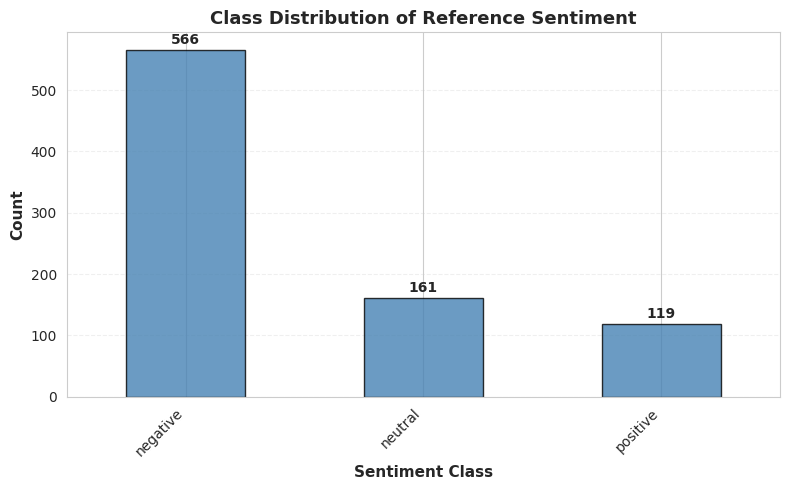

✓ Saved: plots_analysis_3/01_class_distribution.pdf

--- Step 3: Training Models ---


Training: Logistic Regression

Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}
Best CV F1-Weighted Score: 0.5989

Validation F1-Weighted Score: 0.6816
Test Accuracy: 0.6235
Test F1-Weighted: 0.5999

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative     0.7460    0.8246    0.7833        57
     neutral     0.3333    0.1250    0.1818        16
    positive     0.2500    0.3333    0.2857        12

    accuracy                         0.6235        85
   macro avg     0.4431    0.4276    0.4170        85
weighted avg     0.5983    0.6235    0.5999        85



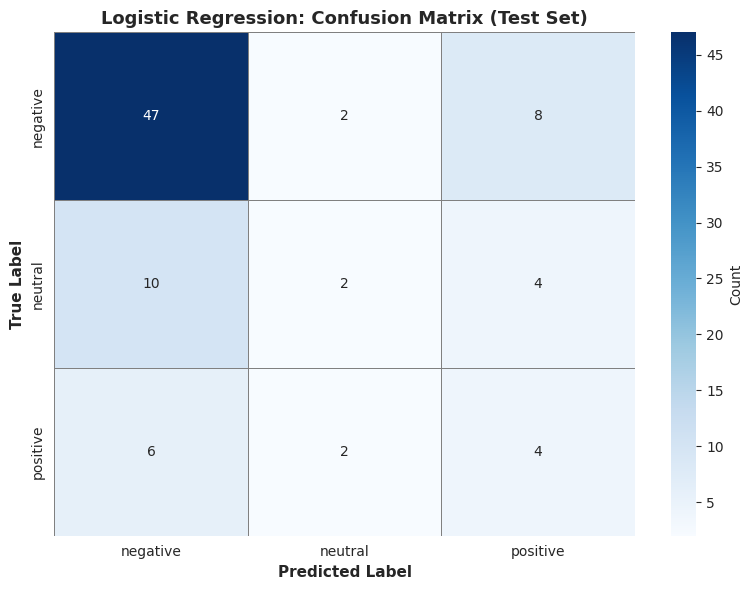

✓ Saved: plots_analysis_3/02_confusion_matrix_logistic_regression.pdf


Training: Naive Bayes

Best params: {'clf__alpha': 0.1}
Best CV F1-Weighted Score: 0.5378

Validation F1-Weighted Score: 0.5422
Test Accuracy: 0.6706
Test F1-Weighted: 0.5384

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative     0.6706    1.0000    0.8028        57
     neutral     0.0000    0.0000    0.0000        16
    positive     0.0000    0.0000    0.0000        12

    accuracy                         0.6706        85
   macro avg     0.2235    0.3333    0.2676        85
weighted avg     0.4497    0.6706    0.5384        85



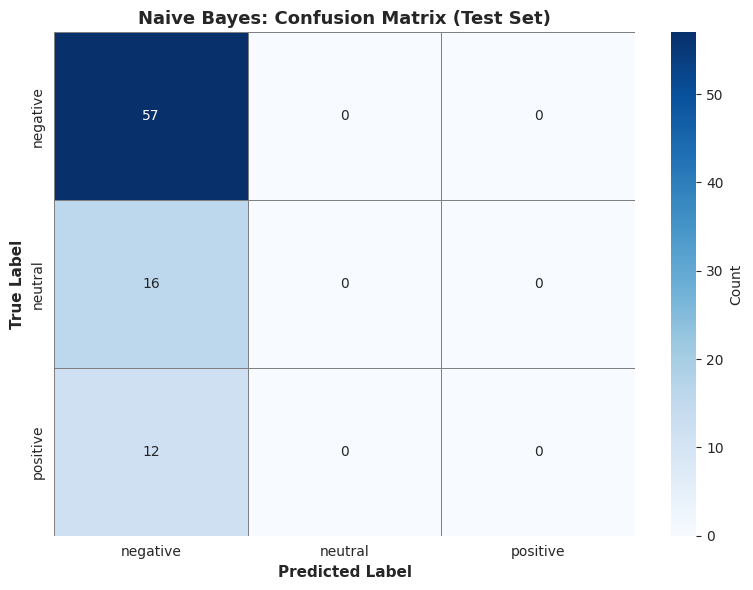

✓ Saved: plots_analysis_3/02_confusion_matrix_naive_bayes.pdf


Training: Random Forest

Best params: {'clf__max_depth': 10}
Best CV F1-Weighted Score: 0.5378

Validation F1-Weighted Score: 0.5422
Test Accuracy: 0.6588
Test F1-Weighted: 0.5365

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative     0.6747    0.9825    0.8000        57
     neutral     0.0000    0.0000    0.0000        16
    positive     0.0000    0.0000    0.0000        12

    accuracy                         0.6588        85
   macro avg     0.2249    0.3275    0.2667        85
weighted avg     0.4524    0.6588    0.5365        85



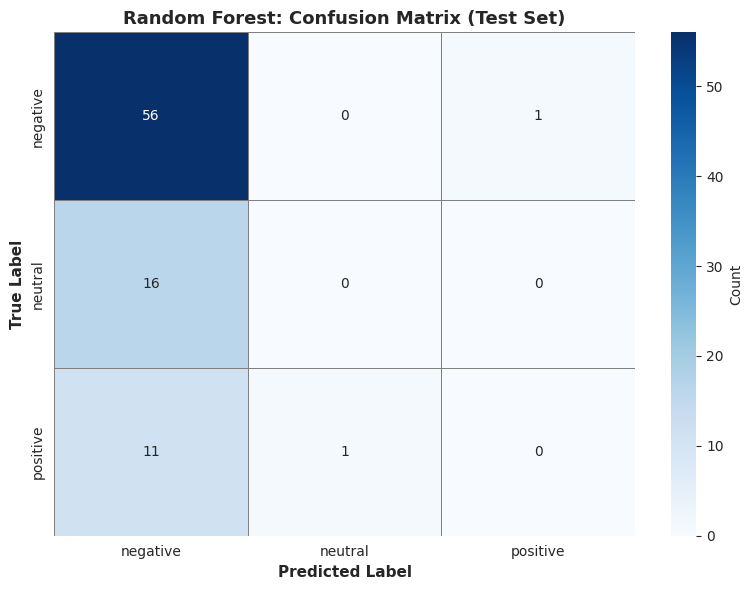

✓ Saved: plots_analysis_3/02_confusion_matrix_random_forest.pdf


MODEL COMPARISON SUMMARY

              Model  CV_F1  Val_F1  Test_F1  Test_Accuracy
Logistic Regression 0.5989  0.6816   0.5999         0.6235
        Naive Bayes 0.5378  0.5422   0.5384         0.6706
      Random Forest 0.5378  0.5422   0.5365         0.6588

✓ Saved: plots_analysis_3/03_model_scores_summary.csv

--- Creating Model Comparison Plot ---



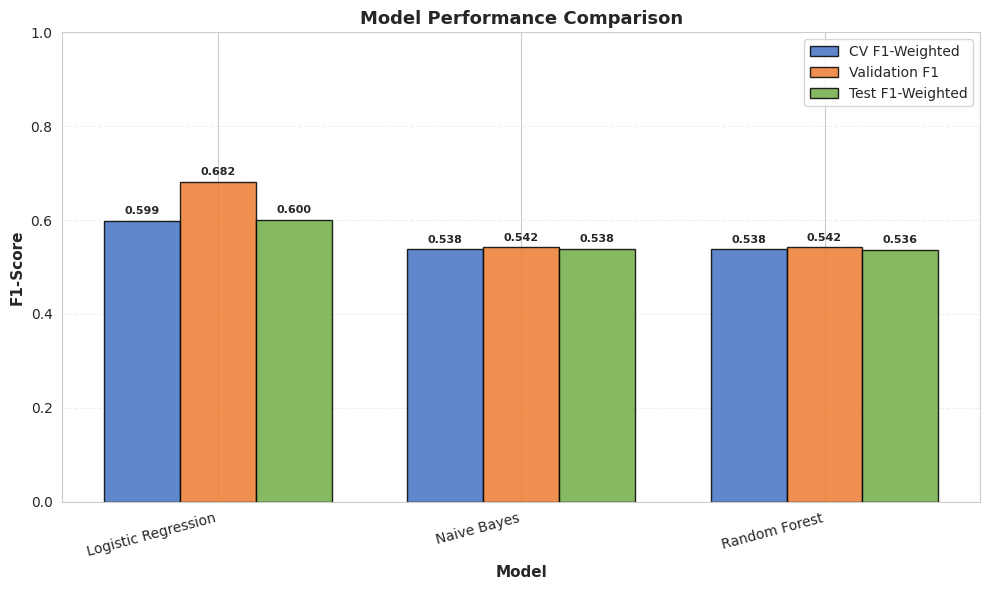

✓ Saved: plots_analysis_3/04_model_comparison.pdf


--- Creating Combined Confusion Matrix Grid ---



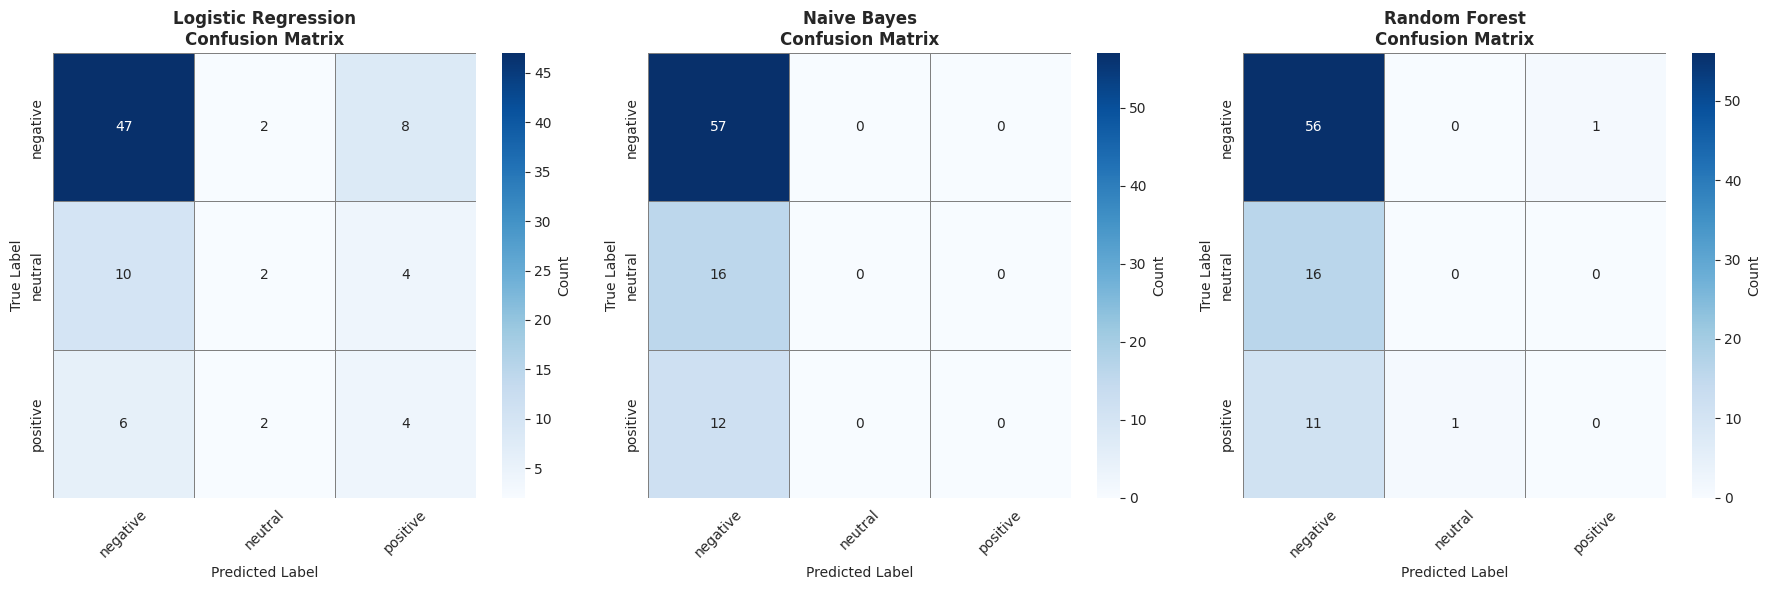

✓ Saved: plots_analysis_3/05_combined_confusion_matrices.pdf


--- Creating Comprehensive Comparison Table ---

COMPREHENSIVE MODEL COMPARISON TABLE
              Model  CV_F1  Val_F1  Test_F1  Test_Accuracy  Macro_Precision  Macro_Recall  Macro_F1  Weighted_Precision  Weighted_Recall  Weighted_F1
Logistic Regression 0.5989  0.6816   0.5999         0.6235           0.4431        0.4276    0.4170              0.5983           0.6235       0.5999
        Naive Bayes 0.5378  0.5422   0.5384         0.6706           0.2235        0.3333    0.2676              0.4497           0.6706       0.5384
      Random Forest 0.5378  0.5422   0.5365         0.6588           0.2249        0.3275    0.2667              0.4524           0.6588       0.5365
✓ Saved: plots_analysis_3/06_comprehensive_comparison_table.csv

✓ ANALYSIS 3 COMPLETE

Generated outputs in: plots_analysis_3/

Files created:
  1. 01_class_distribution.pdf
  2. 02_confusion_matrix_*.pdf (for each model)
  3. 03_model_scores_summary

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# ================================
# SETUP: Load Data
# ================================
drive.mount('/content/drive', force_remount=True)

csv_to_load = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'
print(f"Loading data from: {csv_to_load}\n")

try:
    df = pd.read_csv(csv_to_load)
    print("✓ DataFrame loaded successfully.\n")
except FileNotFoundError:
    print(f"❌ Error: File not found at '{csv_to_load}'.")
    raise
except Exception as e:
    print(f"❌ Error reading CSV file: {e}")
    raise

# Create output folder
output_plot_folder = "plots_analysis_3"
os.makedirs(output_plot_folder, exist_ok=True)
print(f"✓ Plots will be saved to: {output_plot_folder}/\n")

# ============================================================
# ANALYSIS 3 — SENTIMENT CLASSIFICATION
# ============================================================
print("=" * 70)
print("ANALYSIS 3: SENTIMENT CLASSIFIER (Text Classification)")
print("=" * 70)

# ─────────────────────────────────────────────────────────
# 1. Prepare Data
# ─────────────────────────────────────────────────────────
print("\n--- Step 1: Preparing Data ---\n")

# Check for required columns
if 'transcript' not in df.columns:
    print("❌ Error: 'transcript' column not found")
    raise KeyError("Column 'transcript' not found")

if 'label' not in df.columns:
    print("❌ Error: 'label' column not found")
    raise KeyError("Column 'label' not found")

# Drop rows with missing data
cleaned_df = df[['transcript', 'label']].dropna().copy()
cleaned_df['transcript'] = cleaned_df['transcript'].astype(str)

print(f"✓ Total samples: {len(cleaned_df)}")

X = cleaned_df["transcript"]
y = cleaned_df["label"]

# Get class labels dynamically
class_labels = sorted(y.unique())
print(f"✓ Found class labels: {class_labels}")
print(f"✓ Number of classes: {len(class_labels)}\n")

# Check class distribution
class_dist = y.value_counts().sort_index()
print("Class distribution:")
print(class_dist)
print(f"\nClass distribution (%):")
print(y.value_counts(normalize=True).sort_index() * 100)

# Train/validation/test split (80-10-10)
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )
    print(f"\n✓ Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
except ValueError as e:
    print(f"❌ Error during split: {e}")
    raise

# ─────────────────────────────────────────────────────────
# 2. Visualize Class Distribution
# ─────────────────────────────────────────────────────────
print("\n--- Step 2: Visualizing Class Distribution ---\n")

fig, ax = plt.subplots(figsize=(8, 5))
y.value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue',
                                   edgecolor='black', alpha=0.8)
ax.set_title("Class Distribution of Reference Sentiment", fontsize=13, fontweight='bold')
ax.set_xlabel("Sentiment Class", fontsize=11, fontweight='bold')
ax.set_ylabel("Count", fontsize=11, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add count labels on bars
for i, v in enumerate(y.value_counts().sort_index()):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
pdf_path = f"{output_plot_folder}/01_class_distribution.pdf"
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_path}\n")

# ─────────────────────────────────────────────────────────
# 3. Define Models + Hyperparameters
# ─────────────────────────────────────────────────────────
print("--- Step 3: Training Models ---\n")

models = {
    "Logistic Regression": {
        "clf": LogisticRegression(max_iter=200, class_weight='balanced', random_state=42),
        "params": {"clf__C": [0.1, 1, 10], "clf__solver": ["lbfgs"]}
    },
    "Naive Bayes": {
        "clf": MultinomialNB(),
        "params": {"clf__alpha": [0.1, 0.5, 1.0]}
    },
    "Random Forest": {
        "clf": RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        "params": {"clf__max_depth": [None, 10, 20]}
    }
}

results = {}
model_scores = []

# NEW: to reuse later in combined confusion matrix
grids = {}
test_predictions = {}

# ─────────────────────────────────────────────────────────
# 4. Train + Evaluate Each Model
# ─────────────────────────────────────────────────────────
for model_name, cfg in models.items():
    print(f"\n{'=' * 70}")
    print(f"Training: {model_name}")
    print(f"{'=' * 70}\n")

    # Create pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            ngram_range=(1, 2)
        )),
        ("clf", cfg["clf"])
    ])

    # Grid search with cross-validation
    grid = GridSearchCV(
        pipeline,
        cfg["params"],
        cv=3,
        n_jobs=-1,
        scoring='f1_weighted',
        verbose=0
    )

    grid.fit(X_train, y_train)

    # NEW: store fitted grid for this model
    grids[model_name] = grid

    print(f"Best params: {grid.best_params_}")
    print(f"Best CV F1-Weighted Score: {grid.best_score_:.4f}\n")

    # Validation score
    val_score = grid.score(X_val, y_val)
    print(f"Validation F1-Weighted Score: {val_score:.4f}")

    # Test set evaluation
    y_pred = grid.predict(X_test)
    test_predictions[model_name] = y_pred    # NEW: store test predictions

    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = np.mean(y_pred == y_test)

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-Weighted: {test_f1:.4f}\n")

    # Classification report
    cr = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        labels=class_labels
    )
    results[model_name] = cr

    print("Classification Report (Test Set):")
    print(classification_report(
        y_test,
        y_pred,
        labels=class_labels,
        digits=4
    ))

    model_scores.append({
        'Model': model_name,
        'CV_F1': round(grid.best_score_, 4),
        'Val_F1': round(val_score, 4),
        'Test_F1': round(test_f1, 4),
        'Test_Accuracy': round(test_acc, 4)
    })

    # ─────────────────────────────────────────────────────
    # Confusion Matrix Visualization (per-model)
    # ─────────────────────────────────────────────────────
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
        ax=ax,
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray'
    )

    ax.set_title(
        f"{model_name}: Confusion Matrix (Test Set)",
        fontsize=13,
        fontweight='bold'
    )
    ax.set_ylabel("True Label", fontsize=11, fontweight='bold')
    ax.set_xlabel("Predicted Label", fontsize=11, fontweight='bold')

    plt.tight_layout()

    pdf_name = f"{output_plot_folder}/02_confusion_matrix_{model_name.replace(' ', '_').lower()}.pdf"
    plt.savefig(pdf_name, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✓ Saved: {pdf_name}\n")

# ─────────────────────────────────────────────────────────
# 5. Model Comparison Summary (basic)
# ─────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

scores_df = pd.DataFrame(model_scores)
print(f"\n{scores_df.to_string(index=False)}\n")

# Save scores
scores_path = f"{output_plot_folder}/03_model_scores_summary.csv"
scores_df.to_csv(scores_path, index=False)
print(f"✓ Saved: {scores_path}")

# ─────────────────────────────────────────────────────────
# 6. Model Performance Comparison Plot
# ─────────────────────────────────────────────────────────
print("\n--- Creating Model Comparison Plot ---\n")

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(scores_df))
width = 0.25

bars1 = ax.bar(
    x - width,
    scores_df['CV_F1'],
    width,
    label='CV F1-Weighted',
    color='#4472C4',
    edgecolor='black',
    alpha=0.85
)
bars2 = ax.bar(
    x,
    scores_df['Val_F1'],
    width,
    label='Validation F1',
    color='#ED7D31',
    edgecolor='black',
    alpha=0.85
)
bars3 = ax.bar(
    x + width,
    scores_df['Test_F1'],
    width,
    label='Test F1-Weighted',
    color='#70AD47',
    edgecolor='black',
    alpha=0.85
)

ax.set_xlabel('Model', fontsize=11, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scores_df['Model'], rotation=15, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=8,
            fontweight='bold'
        )

plt.tight_layout()

pdf_name = f"{output_plot_folder}/04_model_comparison.pdf"
plt.savefig(pdf_name, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_name}\n")

# ─────────────────────────────────────────────────────────
# 7. NEW: Combined Confusion Matrix Grid (all models)
# ─────────────────────────────────────────────────────────
print("\n--- Creating Combined Confusion Matrix Grid ---\n")

n_models = len(models)
fig, axes = plt.subplots(
    1,
    n_models,
    figsize=(6 * n_models, 6),
    squeeze=False
)
axes = axes.flatten()

for idx, (model_name, _) in enumerate(models.items()):
    y_pred = test_predictions[model_name]  # already stored
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
        ax=axes[idx],
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray'
    )
    axes[idx].set_title(
        f"{model_name}\nConfusion Matrix",
        fontsize=12,
        fontweight='bold'
    )
    axes[idx].set_ylabel("True Label")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
pdf_name = f"{output_plot_folder}/05_combined_confusion_matrices.pdf"
plt.savefig(pdf_name, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_name}\n")

# ─────────────────────────────────────────────────────────
# 8. NEW: Comprehensive Comparison Table (all scores)
# ─────────────────────────────────────────────────────────
print("\n--- Creating Comprehensive Comparison Table ---\n")

comparison_rows = []

# create a simple lookup from model name to basic scores
basic_scores_lookup = {row['Model']: row for row in model_scores}

for model_name, cr in results.items():
    base = basic_scores_lookup[model_name]
    row = {
        'Model': model_name,
        'CV_F1': base['CV_F1'],
        'Val_F1': base['Val_F1'],
        'Test_F1': base['Test_F1'],
        'Test_Accuracy': base['Test_Accuracy'],
        'Macro_Precision': round(cr['macro avg']['precision'], 4),
        'Macro_Recall': round(cr['macro avg']['recall'], 4),
        'Macro_F1': round(cr['macro avg']['f1-score'], 4),
        'Weighted_Precision': round(cr['weighted avg']['precision'], 4),
        'Weighted_Recall': round(cr['weighted avg']['recall'], 4),
        'Weighted_F1': round(cr['weighted avg']['f1-score'], 4)
    }
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print("=" * 70)
print(comparison_df.to_string(index=False))

comparison_path = f"{output_plot_folder}/06_comprehensive_comparison_table.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Saved: {comparison_path}")

# ─────────────────────────────────────────────────────────
# 9. Summary
# ─────────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("✓ ANALYSIS 3 COMPLETE")
print("=" * 70)
print(f"\nGenerated outputs in: {output_plot_folder}/")
print("\nFiles created:")
print("  1. 01_class_distribution.pdf")
print("  2. 02_confusion_matrix_*.pdf (for each model)")
print("  3. 03_model_scores_summary.csv")
print("  4. 04_model_comparison.pdf")
print("  5. 05_combined_confusion_matrices.pdf")
print("  6. 06_comprehensive_comparison_table.csv")
print("\n" + "=" * 70)


## FULL MULTIMODAL ABLATION

ANALYSIS 3C: MULTIMODAL ABLATION STUDY
Mounted at /content/drive
✓ Output folder: plots_analysis_3C_final/

Loading main data...
✓ Loaded: 846 rows

✓ Platforms: BJ, FB, GM, MS, WX, YT, ZM

CHECKING EXISTING FEATURES
✓ Audio features: (846, 16) (no NaNs)
✓ Reference embeddings: (846, 768) (no NaNs)
✓ Platform embeddings: All 7 platforms present (no NaNs)

✓ All features already present. Skipping extraction.

LOADING FEATURES

✓ Loading audio features...
✓ Loaded: (846, 16)

✓ Loading text embeddings...
✓ Loaded: ['ORIGINAL', 'BJ', 'FB', 'GM', 'MS', 'WX', 'YT', 'ZM']

CREATING LABELS

Sentiment distribution:
label
negative    566
neutral     161
positive    119
Name: count, dtype: int64

MULTIMODAL ABLATION STUDY

──────────────────────────────────────────────────────────────────────
ORIGINAL
──────────────────────────────────────────────────────────────────────
  ✓ Clean samples: 846
  Training Text-Only...
    ✓ Accuracy: 0.6706, F1: 0.2676
  Training Audio-Only...
    ✓ Accuracy: 0.6

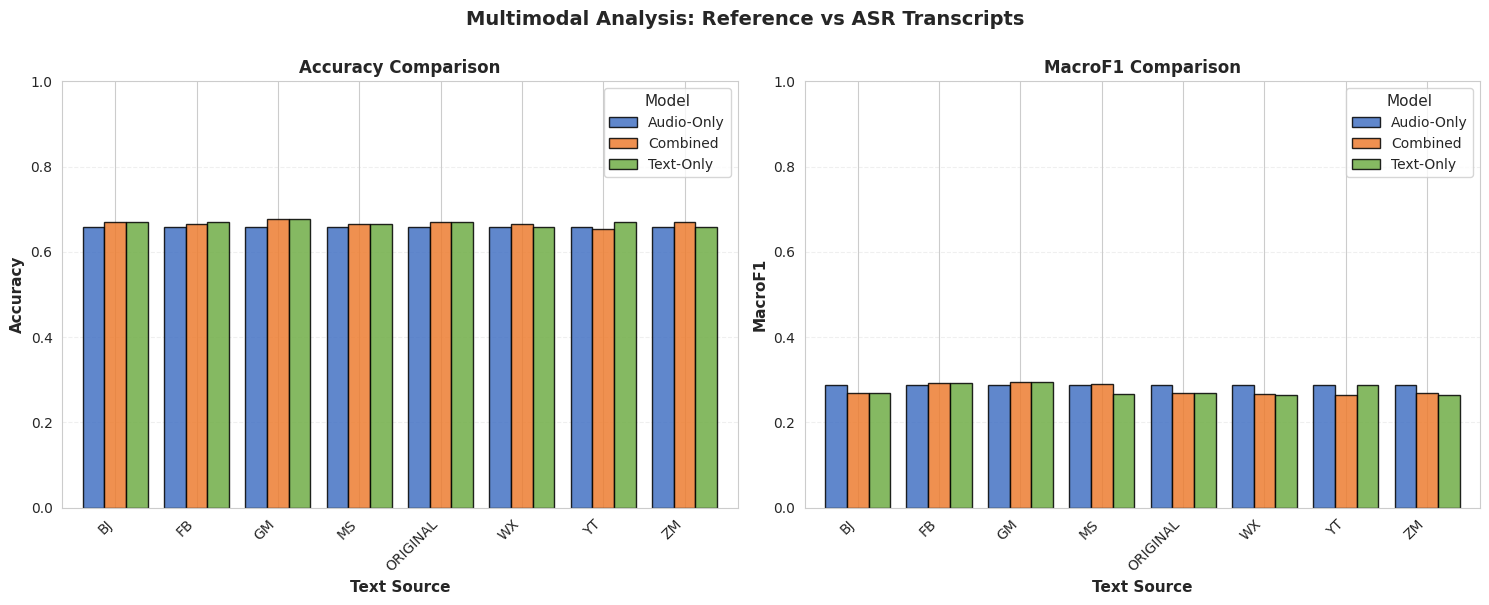

✓ Saved: plots_analysis_3C_final/03_comparison_bars.pdf


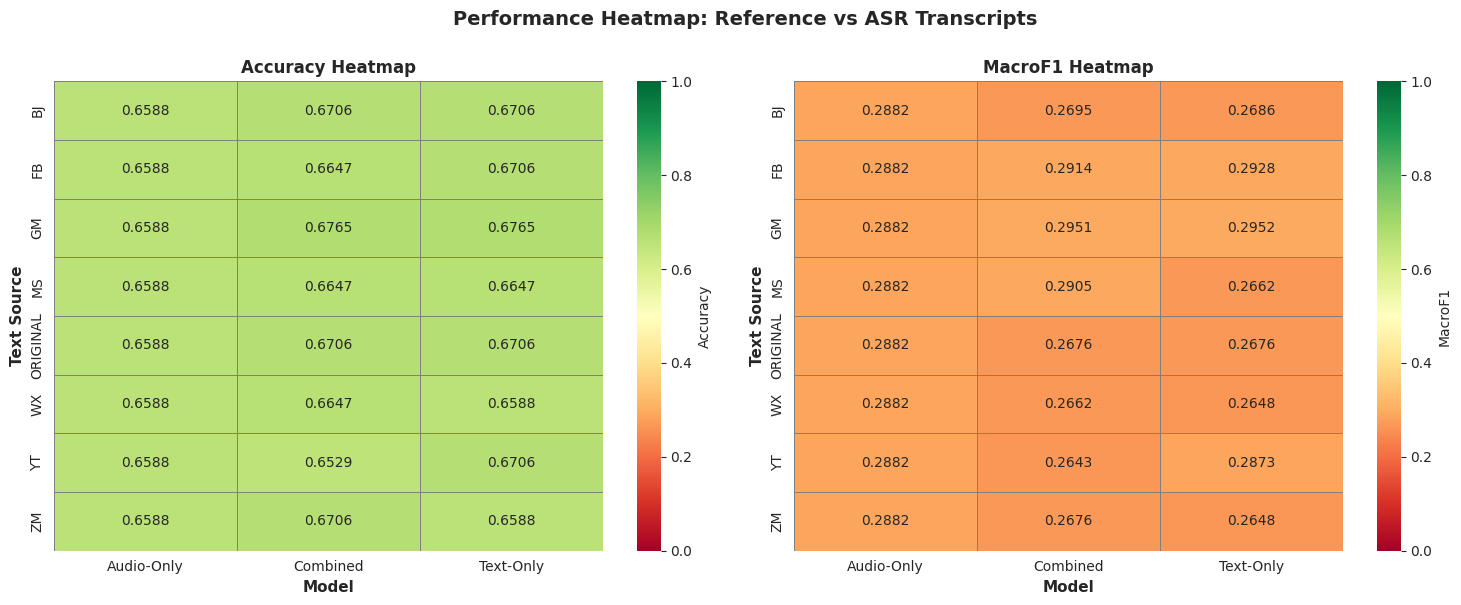

✓ Saved: plots_analysis_3C_final/04_heatmap.pdf

Calculating ASR degradation...



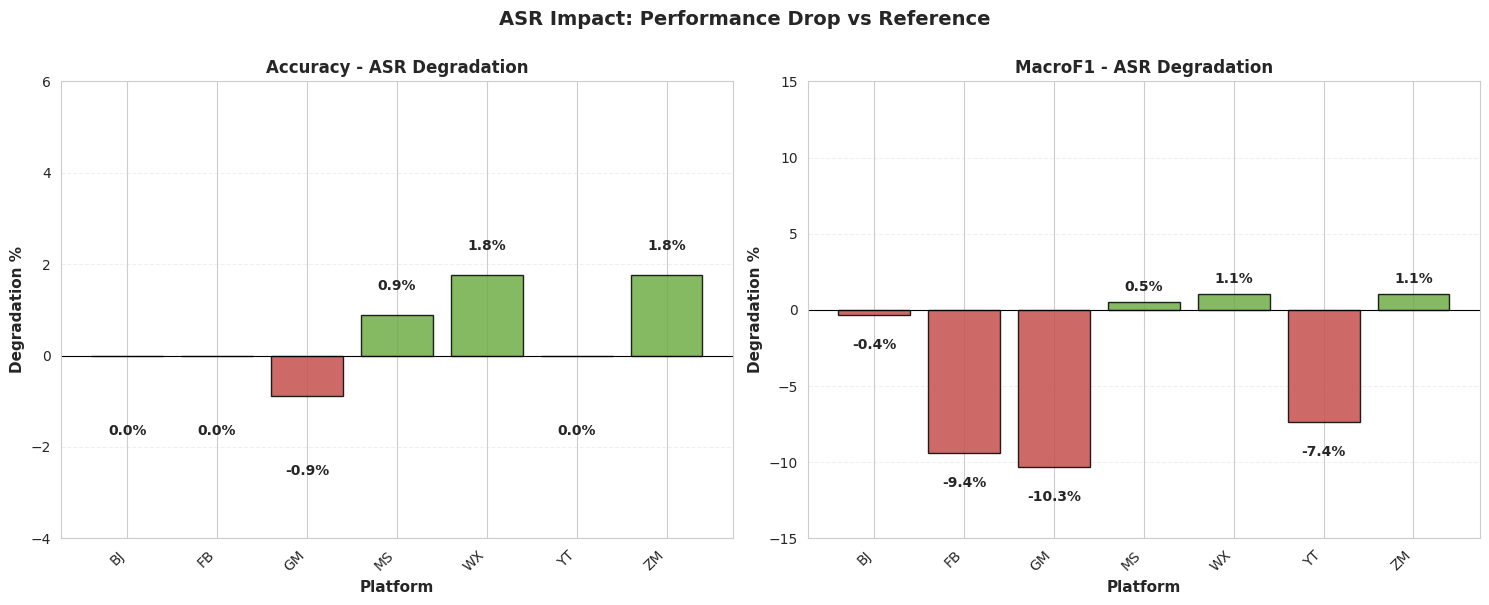

✓ Saved: plots_analysis_3C_final/05_asr_degradation.pdf

✓ Saved: plots_analysis_3C_final/06_asr_degradation.csv

✓ ANALYSIS 3C COMPLETE

Results saved in: plots_analysis_3C_final/

Generated files:
  1. 01_results_reference_vs_platforms.csv - Raw results
  2. 02_results_pivot.csv - Pivot table
  3. 03_comparison_bars.pdf - Comparison charts
  4. 04_heatmap.pdf - Performance heatmap
  5. 05_asr_degradation.pdf - ASR impact analysis
  6. 06_asr_degradation.csv - Degradation metrics


Key Insights:
────────────────────────────────────────────────────────────────────────────────

Accuracy:
  Average degradation: 0.50%
  Worst platform: WX (1.75%)

MacroF1:
  Average degradation: -3.54%
  Worst platform: WX (1.06%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import librosa
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ANALYSIS 3C: MULTIMODAL ABLATION STUDY")
print("=" * 80)

# ─────────────────────────────────────────────────────────
# SETUP
# ─────────────────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/My Drive/Analysis/Sentiment_Analysis"
input_csv_path = os.path.join(base_path, 'labels_sentiment_with_shifts.csv')
audio_features_path = os.path.join(base_path, 'audio_features_df.csv')
embeddings_path = os.path.join(base_path, 'platform_embeddings_with_reference.npz')

output_folder = "plots_analysis_3C_final"
os.makedirs(output_folder, exist_ok=True)

print(f"✓ Output folder: {output_folder}/\n")

# Load data
print("Loading main data...")
df = pd.read_csv(input_csv_path)
print(f"✓ Loaded: {len(df)} rows\n")

# Detect platforms
platforms = [col.replace('_label', '') for col in df.columns
            if col.endswith('_label') and col != 'label']
platforms = sorted(platforms)
print(f"✓ Platforms: {', '.join(platforms)}\n")

# ─────────────────────────────────────────────────────────
# CHECK IF ALL FEATURES EXIST
# ─────────────────────────────────────────────────────────
print("=" * 80)
print("CHECKING EXISTING FEATURES")
print("=" * 80)

def check_features_complete(df, audio_path, embeddings_path, platforms):
    """Check if all audio and text features exist and are complete"""

    # Check audio features file
    if not os.path.exists(audio_path):
        print("✗ Audio features file not found")
        return False

    try:
        audio_df = pd.read_csv(audio_path)
        if len(audio_df) != len(df):
            print(f"✗ Audio features row count mismatch: {len(audio_df)} vs {len(df)}")
            return False

        nan_count = audio_df.isna().sum().sum()
        if nan_count > 0:
            print(f"✗ Audio features contain {nan_count} NaN values")
            return False

        print(f"✓ Audio features: {audio_df.shape} (no NaNs)")
    except Exception as e:
        print(f"✗ Error reading audio features: {e}")
        return False

    # Check embeddings file
    if not os.path.exists(embeddings_path):
        print("✗ Embeddings file not found")
        return False

    try:
        data = np.load(embeddings_path, allow_pickle=True)
        keys = list(data.files)

        # Check for Reference
        if 'ORIGINAL' not in keys:
            print("✗ Missing Reference embeddings")
            return False

        ref_emb = data['ORIGINAL']
        if ref_emb.shape[0] != len(df):
            print(f"✗ Reference embeddings shape mismatch: {ref_emb.shape[0]} vs {len(df)}")
            return False

        if np.isnan(ref_emb).sum() > 0:
            print(f"✗ Reference embeddings contain NaNs")
            return False

        print(f"✓ Reference embeddings: {ref_emb.shape} (no NaNs)")

        # Check for all platforms
        for platform in platforms:
            if platform not in keys:
                print(f"✗ Missing embeddings for platform: {platform}")
                return False

            emb = data[platform]
            if emb.shape[0] != len(df):
                print(f"✗ {platform} embeddings shape mismatch: {emb.shape[0]} vs {len(df)}")
                return False

            if np.isnan(emb).sum() > 0:
                print(f"✗ {platform} embeddings contain NaNs")
                return False

        print(f"✓ Platform embeddings: All {len(platforms)} platforms present (no NaNs)")
        return True

    except Exception as e:
        print(f"✗ Error reading embeddings: {e}")
        return False

# Check if features exist
features_complete = check_features_complete(df, audio_features_path, embeddings_path, platforms)

# ─────────────────────────────────────────────────────────
# EXTRACT FEATURES IF NEEDED
# ─────────────────────────────────────────────────────────
if not features_complete:
    print("\n" + "=" * 80)
    print("EXTRACTING MISSING FEATURES")
    print("=" * 80)

    # Extract Audio Features
    print("\nExtracting audio features...")
    NUM_FEATURES = 16
    mfcc_cols = [f"mfcc_mean_{i}" for i in range(1, 14)]
    audio_feature_cols = ['energy_mean', 'energy_std', 'pause_ratio'] + mfcc_cols

    def get_acoustic_features(file_path):
        try:
            if pd.isna(file_path) or not str(file_path).strip():
                return np.full(NUM_FEATURES, np.nan)

            y, sr = librosa.load(file_path, sr=None)
            if len(y) == 0:
                return np.full(NUM_FEATURES, np.nan)

            rms = librosa.feature.rms(y=y)[0]
            energy_mean = np.mean(rms)
            energy_std = np.std(rms)

            non_silent_intervals = librosa.effects.split(y, top_db=30)
            non_silent_samples = sum(end - start for start, end in non_silent_intervals)
            pause_ratio = 1 - (non_silent_samples / len(y)) if len(y) > 0 else 1.0

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_means = np.mean(mfcc, axis=1)

            return np.concatenate(([energy_mean, energy_std, pause_ratio], mfcc_means))
        except Exception as e:
            return np.full(NUM_FEATURES, np.nan)

    acoustic_vectors = []
    for fp in tqdm(df['audio_filepath'], desc="Audio features"):
        acoustic_vectors.append(get_acoustic_features(fp))

    audio_features_df = pd.DataFrame(acoustic_vectors, columns=audio_feature_cols)
    audio_features_df.to_csv(audio_features_path, index=False)
    print(f"✓ Audio features saved: {audio_features_df.shape}\n")

    # Extract Text Embeddings
    print("Extracting text embeddings...")
    print("Loading DistilBERT model...")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    bert_model.to(device)
    bert_model.eval()
    print(f"✓ Using device: {device}\n")

    def get_embedding(text):
        text = str(text) if pd.notna(text) else ""
        if not text.strip():
            return np.zeros(768)
        try:
            enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
            enc = {k: v.to(device) for k, v in enc.items()}
            with torch.no_grad():
                out = bert_model(**enc).last_hidden_state[:, 0, :].cpu().numpy().flatten()
            return out
        except:
            return np.zeros(768)

    platform_embeddings = {}

    # Extract Reference transcript embeddings
    print("Extracting Reference transcript embeddings...")
    ref_emb = []
    for text in tqdm(df['transcript'], desc="ORIGINAL"):
        ref_emb.append(get_embedding(text))
    platform_embeddings['ORIGINAL'] = np.vstack(ref_emb)
    print(f"✓ Reference: {len(ref_emb)} embeddings\n")

    # Extract platform transcript embeddings
    for p in platforms:
        if p in df.columns:
            print(f"Extracting {p} transcript embeddings...")
            emb_list = []
            for text in tqdm(df[p], desc=p):
                emb_list.append(get_embedding(text))
            platform_embeddings[p] = np.vstack(emb_list)
            print(f"✓ {p}: {len(emb_list)} embeddings\n")

    # Save embeddings
    print("Saving embeddings...")
    np.savez(embeddings_path, **platform_embeddings)
    print(f"✓ Saved to: {embeddings_path}\n")
else:
    print("\n✓ All features already present. Skipping extraction.\n")

# ─────────────────────────────────────────────────────────
# LOAD FEATURES
# ─────────────────────────────────────────────────────────
print("=" * 80)
print("LOADING FEATURES")
print("=" * 80)

print("\n✓ Loading audio features...")
audio_features_df = pd.read_csv(audio_features_path)
print(f"✓ Loaded: {audio_features_df.shape}")

print("\n✓ Loading text embeddings...")
data = np.load(embeddings_path, allow_pickle=True)
platform_embeddings = {key: data[key] for key in data.files}
print(f"✓ Loaded: {list(platform_embeddings.keys())}\n")

# ─────────────────────────────────────────────────────────
# CREATE LABELS
# ─────────────────────────────────────────────────────────
print("=" * 80)
print("CREATING LABELS")
print("=" * 80)

def categorize_sentiment(x):
    if x > 0.2:
        return "positive"
    elif x < -0.2:
        return "negative"
    else:
        return "neutral"

df['label'] = df['ref_sentiment'].apply(categorize_sentiment)
y = df['label'].values

print(f"\nSentiment distribution:")
print(df['label'].value_counts().sort_index())
print()

# ─────────────────────────────────────────────────────────
# MULTIMODAL TRAINING
# ─────────────────────────────────────────────────────────
print("=" * 80)
print("MULTIMODAL ABLATION STUDY")
print("=" * 80)

results_list = []
text_sources = ['ORIGINAL'] + platforms

for text_source in text_sources:
    if text_source not in platform_embeddings:
        print(f"\n⚠ Skipping {text_source}: No embeddings")
        continue

    print(f"\n{'─' * 70}")
    print(f"{text_source}")
    print(f"{'─' * 70}")

    X_text = platform_embeddings[text_source]
    X_audio = audio_features_df.values

    # Find clean rows
    clean_idx = ~np.isnan(X_text).any(axis=1) & ~np.isnan(X_audio).any(axis=1)

    X_text_clean = X_text[clean_idx]
    X_audio_clean = X_audio[clean_idx]
    y_clean = y[clean_idx]

    if len(y_clean) == 0:
        print(f"  ❌ No clean data")
        continue

    print(f"  ✓ Clean samples: {len(y_clean)}")

    # Split data
    (X_text_train, X_text_test,
     X_audio_train, X_audio_test,
     y_train, y_test) = train_test_split(
        X_text_clean, X_audio_clean, y_clean,
        test_size=0.2, random_state=42, stratify=y_clean
    )

    rf_params = {"n_estimators": 100, "random_state": 42, "n_jobs": -1, "max_depth": 10}

    # Text-Only
    print(f"  Training Text-Only...")
    rf_text = RandomForestClassifier(**rf_params)
    rf_text.fit(X_text_train, y_train)
    y_pred_text = rf_text.predict(X_text_test)
    acc_text = accuracy_score(y_test, y_pred_text)
    f1_text = f1_score(y_test, y_pred_text, average="macro", zero_division=0)
    print(f"    ✓ Accuracy: {acc_text:.4f}, F1: {f1_text:.4f}")

    # Audio-Only
    print(f"  Training Audio-Only...")
    rf_audio = RandomForestClassifier(**rf_params)
    rf_audio.fit(X_audio_train, y_train)
    y_pred_audio = rf_audio.predict(X_audio_test)
    acc_audio = accuracy_score(y_test, y_pred_audio)
    f1_audio = f1_score(y_test, y_pred_audio, average="macro", zero_division=0)
    print(f"    ✓ Accuracy: {acc_audio:.4f}, F1: {f1_audio:.4f}")

    # Combined
    print(f"  Training Combined...")
    X_train_comb = np.hstack([X_text_train, X_audio_train])
    X_test_comb = np.hstack([X_text_test, X_audio_test])

    rf_comb = RandomForestClassifier(**rf_params)
    rf_comb.fit(X_train_comb, y_train)
    y_pred_comb = rf_comb.predict(X_test_comb)
    acc_comb = accuracy_score(y_test, y_pred_comb)
    f1_comb = f1_score(y_test, y_pred_comb, average="macro", zero_division=0)
    print(f"    ✓ Accuracy: {acc_comb:.4f}, F1: {f1_comb:.4f}")

    # Store results
    results_list.append({
        "Text Source": text_source,
        "Model": "Text-Only",
        "Accuracy": acc_text,
        "MacroF1": f1_text
    })
    results_list.append({
        "Text Source": text_source,
        "Model": "Audio-Only",
        "Accuracy": acc_audio,
        "MacroF1": f1_audio
    })
    results_list.append({
        "Text Source": text_source,
        "Model": "Combined",
        "Accuracy": acc_comb,
        "MacroF1": f1_comb
    })

# ─────────────────────────────────────────────────────────
# RESULTS & VISUALIZATION
# ─────────────────────────────────────────────────────────
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)

df_results = pd.DataFrame(results_list)

pivot = df_results.pivot_table(
    index="Text Source",
    columns="Model",
    values=["Accuracy", "MacroF1"]
)

print(f"\n{pivot.to_string()}\n")

# Save results
csv_raw = os.path.join(output_folder, "01_results_reference_vs_platforms.csv")
csv_pivot = os.path.join(output_folder, "02_results_pivot.csv")

df_results.to_csv(csv_raw, index=False)
pivot.to_csv(csv_pivot)

print(f"✓ Saved: {csv_raw}")
print(f"✓ Saved: {csv_pivot}\n")

# Plot 1: Comparison Bar Chart
print("Creating visualizations...\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, metric in enumerate(['Accuracy', 'MacroF1']):
    ax = axes[idx]

    pivot_metric = df_results.pivot(index='Text Source', columns='Model', values=metric)

    pivot_metric.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.85,
                     color=['#4472C4', '#ED7D31', '#70AD47'],
                     width=0.8)

    ax.set_title(f"{metric} Comparison", fontsize=12, fontweight='bold')
    ax.set_xlabel("Text Source", fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.legend(title='Model', fontsize=10, title_fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle("Multimodal Analysis: Reference vs ASR Transcripts",
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

pdf_path = os.path.join(output_folder, "03_comparison_bars.pdf")
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_path}")

# Plot 2: Heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, metric in enumerate(['Accuracy', 'MacroF1']):
    ax = axes[idx]

    pivot_metric = df_results.pivot(index='Text Source', columns='Model', values=metric)

    sns.heatmap(pivot_metric, annot=True, fmt='.4f', cmap='RdYlGn',
               ax=ax, cbar_kws={'label': metric}, vmin=0, vmax=1,
               linewidths=0.5, linecolor='gray')

    ax.set_title(f"{metric} Heatmap", fontsize=12, fontweight='bold')
    ax.set_xlabel("Model", fontsize=11, fontweight='bold')
    ax.set_ylabel("Text Source", fontsize=11, fontweight='bold')

plt.suptitle("Performance Heatmap: Reference vs ASR Transcripts",
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

pdf_path = os.path.join(output_folder, "04_heatmap.pdf")
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_path}")

# Plot 3: ASR Degradation Analysis
print(f"\nCalculating ASR degradation...\n")

degradation_data = []
for metric in ['Accuracy', 'MacroF1']:
    ref_results = df_results[(df_results['Text Source'] == 'ORIGINAL') &
                             (df_results['Model'] == 'Text-Only')]

    if len(ref_results) > 0:
        ref_score = ref_results[metric].values[0]

        for p in platforms:
            platform_results = df_results[(df_results['Text Source'] == p) &
                                         (df_results['Model'] == 'Text-Only')]

            if len(platform_results) > 0:
                platform_score = platform_results[metric].values[0]
                degradation = ref_score - platform_score
                degradation_pct = (degradation / ref_score * 100) if ref_score > 0 else 0

                degradation_data.append({
                    'Metric': metric,
                    'Platform': p,
                    'ORIGINAL': ref_score,
                    'ASR': platform_score,
                    'Degradation': degradation,
                    'Degradation_%': degradation_pct
                })

df_degradation = pd.DataFrame(degradation_data)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, metric in enumerate(['Accuracy', 'MacroF1']):
    ax = axes[idx]

    metric_data = df_degradation[df_degradation['Metric'] == metric]

    colors = ['#70AD47' if x >= 0 else '#C5504E' for x in metric_data['Degradation']]
    bars = ax.bar(metric_data['Platform'], metric_data['Degradation_%'],
                  color=colors, edgecolor='black', alpha=0.85)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1.5),
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_title(f"{metric} - ASR Degradation", fontsize=12, fontweight='bold')
    ax.set_xlabel("Platform", fontsize=11, fontweight='bold')
    ax.set_ylabel("Degradation %", fontsize=11, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Set fixed y-axis limits
    if metric == 'Accuracy':
        ax.set_ylim([-4, 6])
    elif metric == 'MacroF1':
        ax.set_ylim([-15, 15])

plt.suptitle("ASR Impact: Performance Drop vs Reference",
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

pdf_path = os.path.join(output_folder, "05_asr_degradation.pdf")
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"✓ Saved: {pdf_path}\n")

# Save degradation data
csv_deg = os.path.join(output_folder, "06_asr_degradation.csv")
df_degradation.to_csv(csv_deg, index=False)
print(f"✓ Saved: {csv_deg}\n")

# ─────────────────────────────────────────────────────────
# FINAL SUMMARY
# ─────────────────────────────────────────────────────────
print("=" * 80)
print("✓ ANALYSIS 3C COMPLETE")
print("=" * 80)
print(f"\nResults saved in: {output_folder}/")
print("\nGenerated files:")
print("  1. 01_results_reference_vs_platforms.csv - Raw results")
print("  2. 02_results_pivot.csv - Pivot table")
print("  3. 03_comparison_bars.pdf - Comparison charts")
print("  4. 04_heatmap.pdf - Performance heatmap")
print("  5. 05_asr_degradation.pdf - ASR impact analysis")
print("  6. 06_asr_degradation.csv - Degradation metrics")
print("\n" + "=" * 80)

print("\nKey Insights:")
print("─" * 80)
for metric in ['Accuracy', 'MacroF1']:
    metric_data = df_degradation[df_degradation['Metric'] == metric]
    avg_deg = metric_data['Degradation_%'].mean()
    worst_p = metric_data.loc[metric_data['Degradation_%'].idxmax(), 'Platform']
    worst_deg = metric_data['Degradation_%'].max()

    print(f"\n{metric}:")
    print(f"  Average degradation: {avg_deg:.2f}%")
    print(f"  Worst platform: {worst_p} ({worst_deg:.2f}%)")


ANALYSIS 3C: ASR DEGRADATION
✓ Loaded Data: 846 rows
✓ Using ORIGINAL labels from CSV (No overwriting)

Calculating metrics (expecting ~0.62 for ORIGINAL)...
  ✓ ORIGINAL: Acc=0.6706, F1w=0.6400
  ✓ BJ: Acc=0.6471, F1w=0.6175
  ✓ FB: Acc=0.6412, F1w=0.6121
  ✓ GM: Acc=0.6353, F1w=0.6032
  ✓ MS: Acc=0.6412, F1w=0.6091
  ✓ WX: Acc=0.6353, F1w=0.6138
  ✓ YT: Acc=0.6471, F1w=0.6163
  ✓ ZM: Acc=0.6353, F1w=0.6129


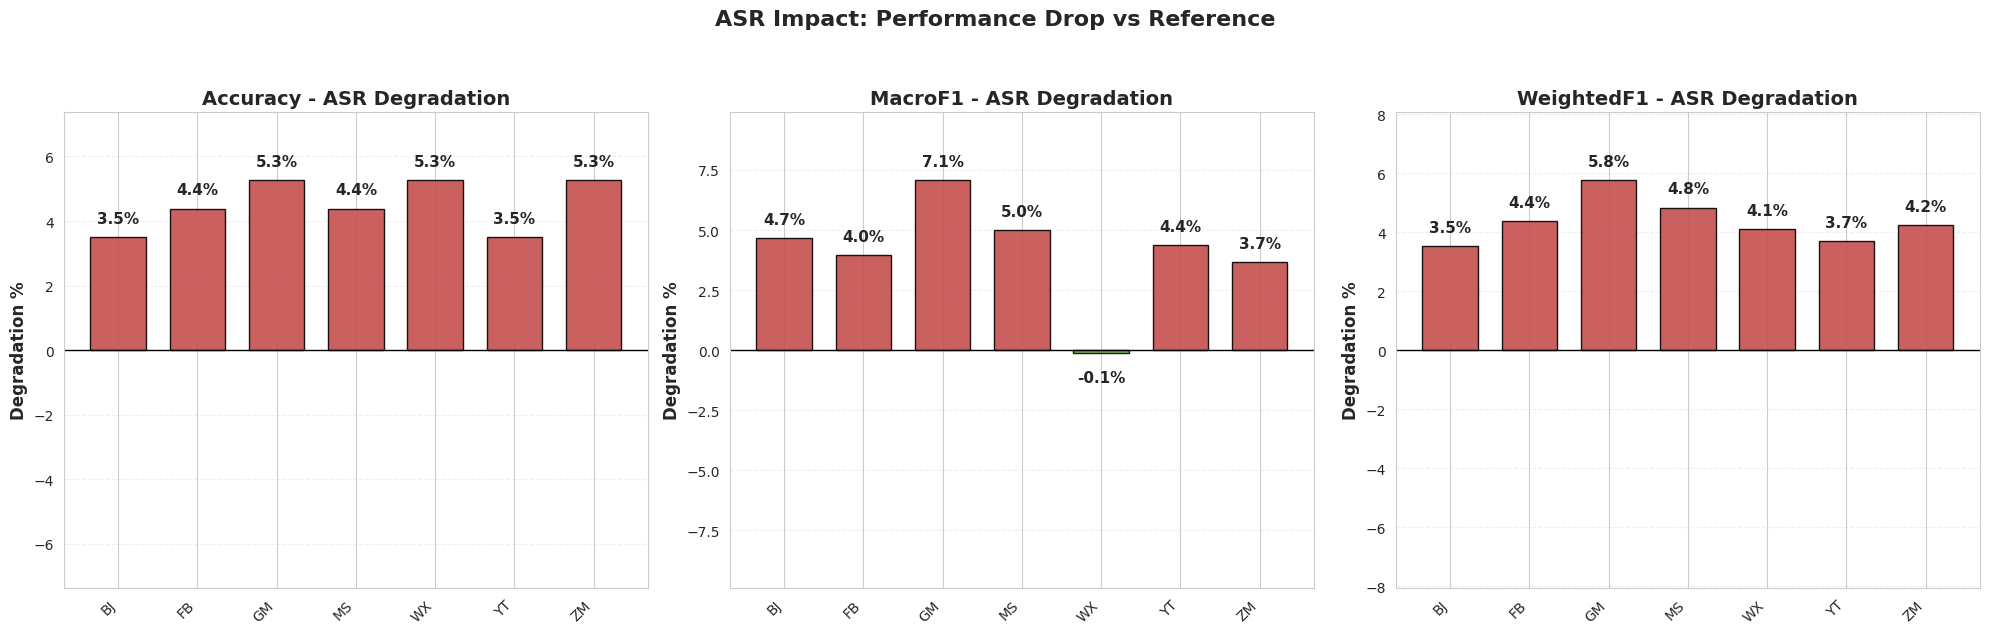


✓ Plot saved to: plots_analysis_3C_ASR_Degradation/03_ASR_Degradation_final.pdf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

print("=" * 80)
print("ANALYSIS 3C: ASR DEGRADATION")
print("=" * 80)

# ─────────────────────────────────────────────────────────
# 1. SETUP & LOAD DATA
# ─────────────────────────────────────────────────────────
output_folder = "plots_analysis_3C_ASR_Degradation"
os.makedirs(output_folder, exist_ok=True)

csv_path = '/content/drive/My Drive/Analysis/Sentiment_Analysis/labels_sentiment_with_shifts.csv'
df = pd.read_csv(csv_path)

# ⚠ CRITICAL FIX: DO NOT OVERWRITE LABELS
# We comment this out to use the EXACT labels from your CSV (matching your 62% run)
# def categorize_sentiment(x):
#     if x > 0.2: return "positive"
#     elif x < -0.2: return "negative"
#     else: return "neutral"
# df['label'] = df['ref_sentiment'].apply(categorize_sentiment)

print(f"✓ Loaded Data: {len(df)} rows")
print(f"✓ Using ORIGINAL labels from CSV (No overwriting)")

# Identify Platforms
platforms = sorted([col.replace('_label', '') for col in df.columns
                   if col.endswith('_label') and col != 'label'])
text_sources = ['transcript'] + platforms

# ─────────────────────────────────────────────────────────
# 2. TRAINING LOOP
# ─────────────────────────────────────────────────────────
lr_params = {
    "C": 1,
    "solver": "lbfgs",
    "max_iter": 200,
    "class_weight": "balanced",
    "random_state": 42
}

tfidf_params = {
    "max_features": 5000,
    "stop_words": "english",
    "ngram_range": (1, 2)
}

results_list = []

print("\nCalculating metrics (expecting ~0.62 for ORIGINAL)...")

for source in text_sources:
    display_name = "ORIGINAL" if source == 'transcript' else source

    if source not in df.columns: continue

    # Prepare Data
    temp_df = df[[source, 'label']].dropna()
    X = temp_df[source].astype(str)
    y = temp_df['label']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(**tfidf_params)),
        ("clf", LogisticRegression(**lr_params))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    results_list.append({
        "Platform": display_name,
        "Accuracy": acc,
        "MacroF1": f1_macro,
        "WeightedF1": f1_weighted
    })
    print(f"  ✓ {display_name}: Acc={acc:.4f}, F1w={f1_weighted:.4f}")

# ─────────────────────────────────────────────────────────
# 3. PLOT (REVERSED COLORS: Red=Bad, Green=Good)
# ─────────────────────────────────────────────────────────
df_res = pd.DataFrame(results_list)
df_res.to_csv(os.path.join(output_folder, "01_raw_scores_strict.csv"), index=False)

ref_row = df_res[df_res['Platform'] == 'ORIGINAL'].iloc[0]

degradation_data = []
for idx, row in df_res.iterrows():
    if row['Platform'] == 'ORIGINAL': continue

    p = row['Platform']
    # Degradation Formula
    deg_acc = (ref_row['Accuracy'] - row['Accuracy']) / ref_row['Accuracy'] * 100
    deg_mac = (ref_row['MacroF1'] - row['MacroF1']) / ref_row['MacroF1'] * 100
    deg_wgt = (ref_row['WeightedF1'] - row['WeightedF1']) / ref_row['WeightedF1'] * 100

    degradation_data.append({
        "Platform": p,
        "Accuracy": deg_acc,
        "MacroF1": deg_mac,
        "WeightedF1": deg_wgt
    })

df_deg = pd.DataFrame(degradation_data)
df_deg.to_csv(os.path.join(output_folder, "02_degradation_strict.csv"), index=False)

# Plot
metrics_to_plot = ['Accuracy', 'MacroF1', 'WeightedF1']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = df_deg[metric]
    platforms_plot = df_deg['Platform']

    # Colors: Red if Positive (Degradation), Green if Negative (Improvement)
    colors = ['#C5504E' if x >= 0 else '#70AD47' for x in values]

    bars = ax.bar(platforms_plot, values, color=colors, edgecolor='black', alpha=0.9, width=0.7)

    ax.set_title(f"{metric} - ASR Degradation", fontsize=14, fontweight='bold')
    ax.set_ylabel("Degradation %", fontsize=12, fontweight='bold')
    ax.axhline(0, color='black', linewidth=1)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    max_val = values.abs().max()
    limit = max_val * 1.4 if max_val > 0 else 5
    ax.set_ylim(-limit, limit)

    for bar in bars:
        height = bar.get_height()
        label = f"{height:.1f}%"
        xy_pos = (bar.get_x() + bar.get_width() / 2, height)
        xy_text = (0, 8 if height >= 0 else -12)
        ax.annotate(label, xy=xy_pos, xytext=xy_text, textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=11, fontweight='bold')

    ax.set_xticklabels(platforms_plot, rotation=45, ha='right')

plt.suptitle("ASR Impact: Performance Drop vs Reference",
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plot_path = os.path.join(output_folder, "03_ASR_Degradation_final.pdf")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

In [ ]:
import os
print(os.getcwd())
os.listdir(os.getcwd())


/content


['.config',
 'demographic_impact_analysis',
 'plots_analysis_3C_final',
 'plots_partA',
 'plots_analysis_3',
 'plots_findingC',
 'plots_partB',
 'plots_demographic_sentiment',
 'drive',
 'sample_data']